## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


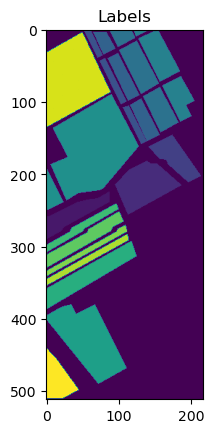

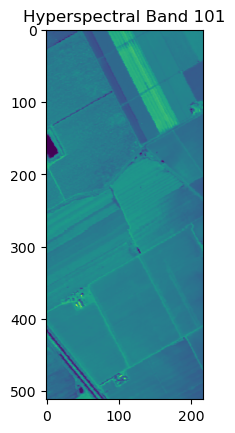

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53729 samples
	shape (53729, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(320, 5, 5, 204)
(80, 5, 5, 204)
(53729, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1534, PSNR: 7.3085


	 Training Batch [200/677], Loss: 0.0871, PSNR: 9.7011


	 Training Batch [400/677], Loss: 0.0447, PSNR: 12.6367


	 Training Batch [600/677], Loss: 0.0246, PSNR: 15.2527


Epoch [1/50] Training Loss: 0.0658, PSNR: 11.6915
	[Val]   Batch [1/170] Loss: 0.0210, PSNR: 15.8621
	[Val]   Batch [10/170] Loss: 0.0206, PSNR: 16.0452
	[Val]   Batch [20/170] Loss: 0.0207, PSNR: 15.9366
	[Val]   Batch [30/170] Loss: 0.0215, PSNR: 15.7211
	[Val]   Batch [40/170] Loss: 0.0216, PSNR: 15.7995


	[Val]   Batch [50/170] Loss: 0.0204, PSNR: 16.0183
	[Val]   Batch [60/170] Loss: 0.0214, PSNR: 15.8793
	[Val]   Batch [70/170] Loss: 0.0210, PSNR: 15.9556
	[Val]   Batch [80/170] Loss: 0.0213, PSNR: 15.7893
	[Val]   Batch [90/170] Loss: 0.0207, PSNR: 16.0180


	[Val]   Batch [100/170] Loss: 0.0207, PSNR: 15.9407
	[Val]   Batch [110/170] Loss: 0.0207, PSNR: 15.9394
	[Val]   Batch [120/170] Loss: 0.0195, PSNR: 14.2505
	[Val]   Batch [130/170] Loss: 0.0206, PSNR: 16.0235
	[Val]   Batch [140/170] Loss: 0.0202, PSNR: 16.0920


	[Val]   Batch [150/170] Loss: 0.0216, PSNR: 15.8304
	[Val]   Batch [160/170] Loss: 0.0213, PSNR: 15.8633
	[Val]   Batch [170/170] Loss: 0.0220, PSNR: 15.1721
Epoch [1/50] Validation Loss: 0.0210, PSNR: 15.8570

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0207, PSNR: 15.6864


	 Training Batch [200/677], Loss: 0.0145, PSNR: 17.4845


	 Training Batch [400/677], Loss: 0.0105, PSNR: 18.9466


	 Training Batch [600/677], Loss: 0.0092, PSNR: 19.5266


Epoch [2/50] Training Loss: 0.0127, PSNR: 18.1895
	[Val]   Batch [1/170] Loss: 0.0084, PSNR: 19.8643
	[Val]   Batch [10/170] Loss: 0.0079, PSNR: 20.1866
	[Val]   Batch [20/170] Loss: 0.0080, PSNR: 20.0576
	[Val]   Batch [30/170] Loss: 0.0087, PSNR: 19.6724
	[Val]   Batch [40/170] Loss: 0.0089, PSNR: 19.6668


	[Val]   Batch [50/170] Loss: 0.0078, PSNR: 20.2010
	[Val]   Batch [60/170] Loss: 0.0087, PSNR: 19.8100
	[Val]   Batch [70/170] Loss: 0.0084, PSNR: 19.9137
	[Val]   Batch [80/170] Loss: 0.0085, PSNR: 19.7689
	[Val]   Batch [90/170] Loss: 0.0082, PSNR: 20.0537


	[Val]   Batch [100/170] Loss: 0.0082, PSNR: 19.9683
	[Val]   Batch [110/170] Loss: 0.0081, PSNR: 20.0265
	[Val]   Batch [120/170] Loss: 0.0071, PSNR: 18.6565
	[Val]   Batch [130/170] Loss: 0.0082, PSNR: 20.0564


	[Val]   Batch [140/170] Loss: 0.0076, PSNR: 20.3334
	[Val]   Batch [150/170] Loss: 0.0089, PSNR: 19.7080
	[Val]   Batch [160/170] Loss: 0.0086, PSNR: 19.8049
	[Val]   Batch [170/170] Loss: 0.0089, PSNR: 19.1169
Epoch [2/50] Validation Loss: 0.0083, PSNR: 19.9000

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0077, PSNR: 20.2622


	 Training Batch [200/677], Loss: 0.0073, PSNR: 20.4965


	 Training Batch [400/677], Loss: 0.0063, PSNR: 21.1973


	 Training Batch [600/677], Loss: 0.0046, PSNR: 22.4706


Epoch [3/50] Training Loss: 0.0062, PSNR: 21.2455
	[Val]   Batch [1/170] Loss: 0.0044, PSNR: 22.6505
	[Val]   Batch [10/170] Loss: 0.0042, PSNR: 22.9002
	[Val]   Batch [20/170] Loss: 0.0043, PSNR: 22.8068
	[Val]   Batch [30/170] Loss: 0.0046, PSNR: 22.4040
	[Val]   Batch [40/170] Loss: 0.0047, PSNR: 22.4455


	[Val]   Batch [50/170] Loss: 0.0042, PSNR: 22.8549
	[Val]   Batch [60/170] Loss: 0.0046, PSNR: 22.5627
	[Val]   Batch [70/170] Loss: 0.0044, PSNR: 22.7105
	[Val]   Batch [80/170] Loss: 0.0045, PSNR: 22.5570
	[Val]   Batch [90/170] Loss: 0.0044, PSNR: 22.7764


	[Val]   Batch [100/170] Loss: 0.0044, PSNR: 22.6292
	[Val]   Batch [110/170] Loss: 0.0043, PSNR: 22.7517
	[Val]   Batch [120/170] Loss: 0.0039, PSNR: 21.2684
	[Val]   Batch [130/170] Loss: 0.0044, PSNR: 22.7364
	[Val]   Batch [140/170] Loss: 0.0040, PSNR: 23.0794


	[Val]   Batch [150/170] Loss: 0.0047, PSNR: 22.4758
	[Val]   Batch [160/170] Loss: 0.0045, PSNR: 22.5934
	[Val]   Batch [170/170] Loss: 0.0046, PSNR: 21.9413
Epoch [3/50] Validation Loss: 0.0044, PSNR: 22.6464

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0045, PSNR: 22.6150


	 Training Batch [200/677], Loss: 0.0037, PSNR: 23.1877


	 Training Batch [400/677], Loss: 0.0038, PSNR: 23.3302


	 Training Batch [600/677], Loss: 0.0028, PSNR: 24.6594


Epoch [4/50] Training Loss: 0.0035, PSNR: 23.6795
	[Val]   Batch [1/170] Loss: 0.0026, PSNR: 24.9393
	[Val]   Batch [10/170] Loss: 0.0025, PSNR: 25.1723
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 25.0391
	[Val]   Batch [30/170] Loss: 0.0028, PSNR: 24.5949
	[Val]   Batch [40/170] Loss: 0.0027, PSNR: 24.8238


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 25.0291
	[Val]   Batch [60/170] Loss: 0.0027, PSNR: 24.8326
	[Val]   Batch [70/170] Loss: 0.0026, PSNR: 25.0662
	[Val]   Batch [80/170] Loss: 0.0026, PSNR: 24.8657


	[Val]   Batch [90/170] Loss: 0.0026, PSNR: 25.0449
	[Val]   Batch [100/170] Loss: 0.0027, PSNR: 24.7822
	[Val]   Batch [110/170] Loss: 0.0025, PSNR: 25.0833
	[Val]   Batch [120/170] Loss: 0.0024, PSNR: 23.3169


	[Val]   Batch [130/170] Loss: 0.0027, PSNR: 24.8732
	[Val]   Batch [140/170] Loss: 0.0024, PSNR: 25.3300
	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.7749
	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.9016
	[Val]   Batch [170/170] Loss: 0.0027, PSNR: 24.2105
Epoch [4/50] Validation Loss: 0.0026, PSNR: 24.8956

LOG: Epoch [5/50]


	 Training Batch [1/677], Loss: 0.0027, PSNR: 24.8589


	 Training Batch [200/677], Loss: 0.0024, PSNR: 25.2633


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.8291


	 Training Batch [600/677], Loss: 0.0021, PSNR: 25.9414


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.4004
	[Val]   Batch [1/170] Loss: 0.0018, PSNR: 26.4758
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.7300
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.5368
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 26.0340
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.4324


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.5243
	[Val]   Batch [60/170] Loss: 0.0019, PSNR: 26.3287
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.6579
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.3951
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5912


	[Val]   Batch [100/170] Loss: 0.0019, PSNR: 26.2224
	[Val]   Batch [110/170] Loss: 0.0017, PSNR: 26.7196
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.7715
	[Val]   Batch [130/170] Loss: 0.0019, PSNR: 26.2867
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.8915


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2692
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.4329
	[Val]   Batch [170/170] Loss: 0.0019, PSNR: 25.7040
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.4055

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0021, PSNR: 25.9488


	 Training Batch [200/677], Loss: 0.0019, PSNR: 26.3829


	 Training Batch [400/677], Loss: 0.0016, PSNR: 27.0563


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.0217


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.6435
	[Val]   Batch [1/170] Loss: 0.0013, PSNR: 27.8127
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 28.0890
	[Val]   Batch [20/170] Loss: 0.0013, PSNR: 27.8357
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.2886
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.8256


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.7890
	[Val]   Batch [60/170] Loss: 0.0014, PSNR: 27.6375
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 28.0504
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.7463


	[Val]   Batch [90/170] Loss: 0.0013, PSNR: 27.9297
	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.4559
	[Val]   Batch [110/170] Loss: 0.0012, PSNR: 28.1815
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.9794
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.5309


	[Val]   Batch [140/170] Loss: 0.0012, PSNR: 28.2439
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.5618
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.7620
	[Val]   Batch [170/170] Loss: 0.0014, PSNR: 27.0928
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.7219

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.3219


	 Training Batch [200/677], Loss: 0.0015, PSNR: 26.9172


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.8187


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.8324


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.6259
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.7261
	[Val]   Batch [10/170] Loss: 0.0010, PSNR: 28.9704
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.7083
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.1209
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.7679


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.6357
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.5198
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 29.0278
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6498
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.8886


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.3127
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.1370
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.8427
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3996


	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.1727
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.4147
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6799
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9517
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.6059

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.2643


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.1523


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.5966


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.8173


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.4283
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6942
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 29.9673
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.6556
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 29.0582
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.7578


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.5327
	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.4715
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 30.0127
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.6528


	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.8556
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.2386
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.1597
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.7110
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.3252


	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.1456
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3597
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.6342
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 29.0030
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.5600

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.6524


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.9452


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.0326


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.0684


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.1767
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.6474
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.8945
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.5606
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.9783
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.7318


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.4007
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.4103
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.9681
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.6150
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.8643


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 30.2013
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.1587
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.5822
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.2730
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.0958


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.2935
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.5549
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 29.9792
Epoch [9/50] Validation Loss: 0.0007, PSNR: 30.4916

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.1940


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.3014


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.7460


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.2351


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7994
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.3819
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.6878
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.2869
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.7585
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.4658


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.1188
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.1819
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.6804
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.3975
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.6597


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.0080
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.9231
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.3330
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.0791
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 31.8607


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.0838
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.2597
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.8398
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.2508

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 29.9427


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.3927


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1055


	 Training Batch [600/677], Loss: 0.0007, PSNR: 31.0362


Epoch [11/50] Training Loss: 0.0007, PSNR: 30.3968
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.1830
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.4911
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.0202
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.5935
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.2635


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.9129
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 31.9880
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.4123
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.2343
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.5151


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.8267
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.7544
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.1003
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 31.8919
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.6739


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 31.8783
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.9912
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.7524
Epoch [11/50] Validation Loss: 0.0005, PSNR: 32.0448

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7549


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2106


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.2334


	 Training Batch [600/677], Loss: 0.0006, PSNR: 30.6172


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.8766
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.7314
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.0868
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.5495
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.2121
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.8345


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.4442
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.6011
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.9406
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.8419


	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.1440
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.4879
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.2938
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.6986
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.5504


	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.2318
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5227
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.5257
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.4276
Epoch [12/50] Validation Loss: 0.0004, PSNR: 32.6286

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.6990


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5343


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.0608


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9539


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.3541
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.2143
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.6064
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.0267
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.7533
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.2937


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.9098
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.1264
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3935
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.3632
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6953


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0837
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.7712
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.2545
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.1485
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7421


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0759
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.9749
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 33.0777
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.1426

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0589


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2306


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1231


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2665


Epoch [14/50] Training Loss: 0.0005, PSNR: 31.7583
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.6267
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.9544
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3741
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1895
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6577


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.2805
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.5175
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.7042
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7591
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.1415


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.5249
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1423
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.6638
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5975


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.1112
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4936
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3114
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.5173
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.5290

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0431


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.3843


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.5159


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1607


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0738
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.3365
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.7185
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.0249
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.9437
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.4562


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8745
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.3034
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.4208
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.5819
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.9044


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.2836
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8923
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2365
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.3440
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8277


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.3119
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.9800
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3936
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.2666

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4339


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.9570


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.6173


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3753


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3764
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6400
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0001
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.2780
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.2631
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6961


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1933
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.6263
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.6753
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8631
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.2421


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6162
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.1695
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5560
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.6879
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.1208


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.6215
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2656
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.6574
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5470

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.7885


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.1625


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.2024


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3204


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6446
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.1132
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4608
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6731
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.7841
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.1810


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5378
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1426
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1223
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.3986
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7607


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1700
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6235
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9486
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2292
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5584


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.1762
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6857
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.3368
Epoch [17/50] Validation Loss: 0.0003, PSNR: 35.0257

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.6073


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.1238


	 Training Batch [400/677], Loss: 0.0006, PSNR: 30.6944


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.5020


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.9214
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.4658
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.7581
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.9835
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.0980
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4847
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8658


	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.4743
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4531
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.7124
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.1545
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.4935


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.9716
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.3349
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.5832
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.9004
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.4653


	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9842
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.6630
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.3446

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.8800


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.1709


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.1692


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.6363


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.1198
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 36.0233
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.3159
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.4616
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.6797
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 36.0433


	[Val]   Batch [50/170] Loss: 0.0002, PSNR: 35.2906
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 36.0335
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.9537
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 36.3189
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.7102


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 36.0313
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.5302
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.7685
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 36.1489
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.4438


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 36.0415
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.4926
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.4214
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.8912
Early stopping triggered at epoch 19. No improvement for 3 epochs.


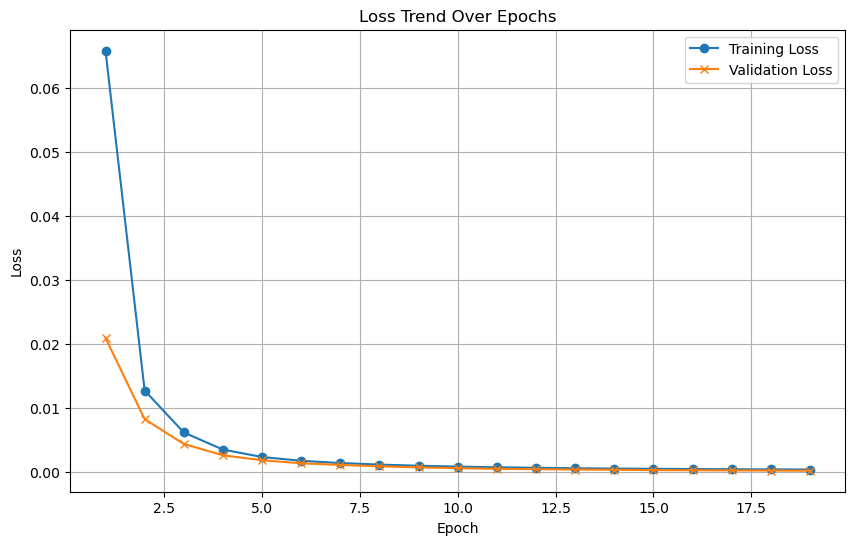

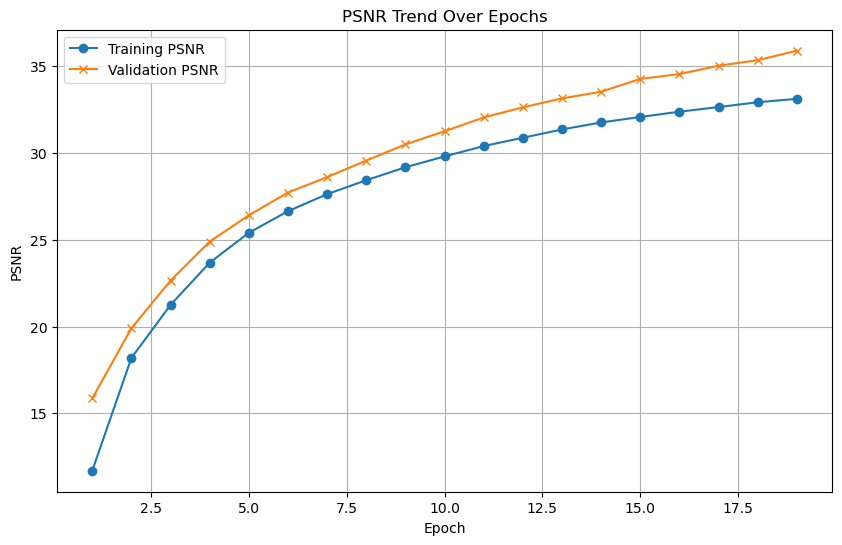

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/210 for test dataset.


    Processed batch 101/210 for test dataset.


    Processed batch 201/210 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7949
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7755. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7442
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7053
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6834
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [16/1000] completed, Average Training Loss: 2.5190
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5120
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5001
    Validation Batch [1/1], Loss: 2.7754
Validation Loss: 2.7754, Validation Accuracy: 6.25%
Validation loss improved from 2.7754 to 2.7754. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4806
    Validation Batch [1/1], Loss: 2.7754
Validation Loss: 2.7754, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4714


Epoch [39/1000] completed, Average Training Loss: 2.2767
    Validation Batch [1/1], Loss: 2.7365
Validation Loss: 2.7365, Validation Accuracy: 12.50%
Validation loss improved from 2.7427 to 2.7365. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.2643
    Validation Batch [1/1], Loss: 2.7294
Validation Loss: 2.7294, Validation Accuracy: 12.50%
Validation loss improved from 2.7365 to 2.7294. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.2594
    Validation Batch [1/1], Loss: 2.7211
Validation Loss: 2.7211, Validation Accuracy: 12.50%
Validation loss improved from 2.7294 to 2.7211. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.2467
    Validation Batch [1/1], Loss: 2.7137
Validation Loss: 2.7137, Validation Accuracy: 12.50%
Validation loss improved from 2.7211 to 2.7137. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 2.3232
Validation Loss: 2.3232, Validation Accuracy: 56.25%
Validation loss improved from 2.3545 to 2.3232. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.0698
    Validation Batch [1/1], Loss: 2.3007
Validation Loss: 2.3007, Validation Accuracy: 62.50%
Validation loss improved from 2.3232 to 2.3007. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.0294
    Validation Batch [1/1], Loss: 2.2845
Validation Loss: 2.2845, Validation Accuracy: 66.25%
Validation loss improved from 2.3007 to 2.2845. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.0202
    Validation Batch [1/1], Loss: 2.2496
Validation Loss: 2.2496, Validation Accuracy: 65.00%
Validation loss improved from 2.2845 to 2.2496. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.0239
    Vali

Epoch [74/1000] completed, Average Training Loss: 1.9418
    Validation Batch [1/1], Loss: 2.0787
Validation Loss: 2.0787, Validation Accuracy: 68.75%
Validation loss improved from 2.0811 to 2.0787. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9015
    Validation Batch [1/1], Loss: 2.0537
Validation Loss: 2.0537, Validation Accuracy: 70.00%
Validation loss improved from 2.0787 to 2.0537. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9232
    Validation Batch [1/1], Loss: 2.0250
Validation Loss: 2.0250, Validation Accuracy: 73.75%
Validation loss improved from 2.0537 to 2.0250. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9198
    Validation Batch [1/1], Loss: 2.0132
Validation Loss: 2.0132, Validation Accuracy: 73.75%
Validation loss improved from 2.0250 to 2.0132. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [7

Epoch [97/1000] completed, Average Training Loss: 1.7500
    Validation Batch [1/1], Loss: 1.8085
Validation Loss: 1.8085, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.7277
    Validation Batch [1/1], Loss: 1.7856
Validation Loss: 1.7856, Validation Accuracy: 75.00%
Validation loss improved from 1.7916 to 1.7856. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7292
    Validation Batch [1/1], Loss: 1.7716
Validation Loss: 1.7716, Validation Accuracy: 76.25%
Validation loss improved from 1.7856 to 1.7716. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.7077
    Validation Batch [1/1], Loss: 1.7475
Validation Loss: 1.7475, Validation Accuracy: 76.25%
Validation loss improved from 1.7716 to 1.7475. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] com

    Validation Batch [1/1], Loss: 1.5290
Validation Loss: 1.5290, Validation Accuracy: 82.50%
Validation loss improved from 1.5308 to 1.5290. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5297
    Validation Batch [1/1], Loss: 1.5413
Validation Loss: 1.5413, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.5085
    Validation Batch [1/1], Loss: 1.5096
Validation Loss: 1.5096, Validation Accuracy: 80.00%
Validation loss improved from 1.5290 to 1.5096. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.5071
    Validation Batch [1/1], Loss: 1.5231
Validation Loss: 1.5231, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.5167
    Validation Batch [1/1], Lo

Epoch [143/1000] completed, Average Training Loss: 1.3228
    Validation Batch [1/1], Loss: 1.3476
Validation Loss: 1.3476, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.3344
    Validation Batch [1/1], Loss: 1.3084
Validation Loss: 1.3084, Validation Accuracy: 87.50%
Validation loss improved from 1.3435 to 1.3084. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.3323
    Validation Batch [1/1], Loss: 1.3161
Validation Loss: 1.3161, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.3140
    Validation Batch [1/1], Loss: 1.3014
Validation Loss: 1.3014, Validation Accuracy: 85.00%
Validation loss improved from 1.3084 to 1.3014. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Av

Epoch [165/1000] completed, Average Training Loss: 1.1691
    Validation Batch [1/1], Loss: 1.1634
Validation Loss: 1.1634, Validation Accuracy: 87.50%
Validation loss improved from 1.1775 to 1.1634. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.1560
    Validation Batch [1/1], Loss: 1.1644
Validation Loss: 1.1644, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.1605
    Validation Batch [1/1], Loss: 1.1419
Validation Loss: 1.1419, Validation Accuracy: 88.75%
Validation loss improved from 1.1634 to 1.1419. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.1293
    Validation Batch [1/1], Loss: 1.1255
Validation Loss: 1.1255, Validation Accuracy: 85.00%
Validation loss improved from 1.1419 to 1.1255. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000

Epoch [188/1000] completed, Average Training Loss: 1.0199
    Validation Batch [1/1], Loss: 0.9997
Validation Loss: 0.9997, Validation Accuracy: 87.50%
Validation loss improved from 1.0107 to 0.9997. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.9829
    Validation Batch [1/1], Loss: 0.9974
Validation Loss: 0.9974, Validation Accuracy: 87.50%
Validation loss improved from 0.9997 to 0.9974. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.9880
    Validation Batch [1/1], Loss: 0.9716
Validation Loss: 0.9716, Validation Accuracy: 88.75%
Validation loss improved from 0.9974 to 0.9716. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.9939
    Validation Batch [1/1], Loss: 0.9601
Validation Loss: 0.9601, Validation Accuracy: 85.00%
Validation loss improved from 0.9716 to 0.9601. Saving model...

LOG: Epoch [192/1000] - Training


    Validation Batch [1/1], Loss: 0.8383
Validation Loss: 0.8383, Validation Accuracy: 90.00%
Validation loss improved from 0.8501 to 0.8383. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8333
    Validation Batch [1/1], Loss: 0.8378
Validation Loss: 0.8378, Validation Accuracy: 90.00%
Validation loss improved from 0.8383 to 0.8378. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.8369
    Validation Batch [1/1], Loss: 0.8408
Validation Loss: 0.8408, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.8126
    Validation Batch [1/1], Loss: 0.8453
Validation Loss: 0.8453, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.8459
    Validation Batch [1/1], Lo

Epoch [234/1000] completed, Average Training Loss: 0.6717
    Validation Batch [1/1], Loss: 0.7062
Validation Loss: 0.7062, Validation Accuracy: 91.25%
Validation loss improved from 0.7190 to 0.7062. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6885
    Validation Batch [1/1], Loss: 0.6783
Validation Loss: 0.6783, Validation Accuracy: 93.75%
Validation loss improved from 0.7062 to 0.6783. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.6698
    Validation Batch [1/1], Loss: 0.6939
Validation Loss: 0.6939, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7024
    Validation Batch [1/1], Loss: 0.6899
Validation Loss: 0.6899, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Av

Epoch [257/1000] completed, Average Training Loss: 0.5487
    Validation Batch [1/1], Loss: 0.5924
Validation Loss: 0.5924, Validation Accuracy: 93.75%
Validation loss improved from 0.5986 to 0.5924. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5804
    Validation Batch [1/1], Loss: 0.5795
Validation Loss: 0.5795, Validation Accuracy: 95.00%
Validation loss improved from 0.5924 to 0.5795. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5649
    Validation Batch [1/1], Loss: 0.5802
Validation Loss: 0.5802, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5443
    Validation Batch [1/1], Loss: 0.5721
Validation Loss: 0.5721, Validation Accuracy: 93.75%
Validation loss improved from 0.5795 to 0.5721. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000

    Validation Batch [1/1], Loss: 0.4932
Validation Loss: 0.4932, Validation Accuracy: 96.25%
Validation loss improved from 0.5025 to 0.4932. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4571
    Validation Batch [1/1], Loss: 0.4857
Validation Loss: 0.4857, Validation Accuracy: 95.00%
Validation loss improved from 0.4932 to 0.4857. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.4620
    Validation Batch [1/1], Loss: 0.4893
Validation Loss: 0.4893, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4428
    Validation Batch [1/1], Loss: 0.4925
Validation Loss: 0.4925, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4302
    Validation Batch [1/1], Lo

Epoch [301/1000] completed, Average Training Loss: 0.3971
    Validation Batch [1/1], Loss: 0.4539
Validation Loss: 0.4539, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3618
    Validation Batch [1/1], Loss: 0.4312
Validation Loss: 0.4312, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3730
    Validation Batch [1/1], Loss: 0.4104
Validation Loss: 0.4104, Validation Accuracy: 95.00%
Validation loss improved from 0.4157 to 0.4104. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3754
    Validation Batch [1/1], Loss: 0.4299
Validation Loss: 0.4299, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3524
Validation Loss: 0.3524, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.2820
    Validation Batch [1/1], Loss: 0.3682
Validation Loss: 0.3682, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.2710
    Validation Batch [1/1], Loss: 0.3533
Validation Loss: 0.3533, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3236
    Validation Batch [1/1], Loss: 0.3334
Validation Loss: 0.3334, Validation Accuracy: 96.25%
Validation loss improved from 0.3344 to 0.3334. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2660
    Validation Batch [1/1], Loss: 0.3290
Vali

Epoch [347/1000] completed, Average Training Loss: 0.2534
    Validation Batch [1/1], Loss: 0.3156
Validation Loss: 0.3156, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2353
    Validation Batch [1/1], Loss: 0.2963
Validation Loss: 0.2963, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2426
    Validation Batch [1/1], Loss: 0.2915
Validation Loss: 0.2915, Validation Accuracy: 96.25%
Validation loss improved from 0.2962 to 0.2915. Saving model...

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2405
    Validation Batch [1/1], Loss: 0.3244
Validation Loss: 0.3244, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training 

Epoch [369/1000] completed, Average Training Loss: 0.1880
    Validation Batch [1/1], Loss: 0.2727
Validation Loss: 0.2727, Validation Accuracy: 95.00%
Validation loss improved from 0.2731 to 0.2727. Saving model...

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.1882
    Validation Batch [1/1], Loss: 0.2563
Validation Loss: 0.2563, Validation Accuracy: 96.25%
Validation loss improved from 0.2727 to 0.2563. Saving model...

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2026
    Validation Batch [1/1], Loss: 0.2497
Validation Loss: 0.2497, Validation Accuracy: 96.25%
Validation loss improved from 0.2563 to 0.2497. Saving model...

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1817
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000

Epoch [392/1000] completed, Average Training Loss: 0.1662
    Validation Batch [1/1], Loss: 0.2394
Validation Loss: 0.2394, Validation Accuracy: 96.25%
Validation loss improved from 0.2429 to 0.2394. Saving model...

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1629
    Validation Batch [1/1], Loss: 0.2627
Validation Loss: 0.2627, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.1765
    Validation Batch [1/1], Loss: 0.2430
Validation Loss: 0.2430, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1581
    Validation Batch [1/1], Loss: 0.2834
Validation Loss: 0.2834, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training 

Epoch [415/1000] completed, Average Training Loss: 0.1488
    Validation Batch [1/1], Loss: 0.2487
Validation Loss: 0.2487, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1508
    Validation Batch [1/1], Loss: 0.2585
Validation Loss: 0.2585, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1467
    Validation Batch [1/1], Loss: 0.3157
Validation Loss: 0.3157, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1407
    Validation Batch [1/1], Loss: 0.2890
Validation Loss: 0.2890, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.143

Epoch [437/1000] completed, Average Training Loss: 0.1437
    Validation Batch [1/1], Loss: 0.2194
Validation Loss: 0.2194, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1254
    Validation Batch [1/1], Loss: 0.2076
Validation Loss: 0.2076, Validation Accuracy: 95.00%
Validation loss improved from 0.2185 to 0.2076. Saving model...

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1237
    Validation Batch [1/1], Loss: 0.1971
Validation Loss: 0.1971, Validation Accuracy: 95.00%
Validation loss improved from 0.2076 to 0.1971. Saving model...

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1122
    Validation Batch [1/1], Loss: 0.2261
Validation Loss: 0.2261, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Av

Epoch [459/1000] completed, Average Training Loss: 0.1104
    Validation Batch [1/1], Loss: 0.2162
Validation Loss: 0.2162, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1108
    Validation Batch [1/1], Loss: 0.2144
Validation Loss: 0.2144, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1198
    Validation Batch [1/1], Loss: 0.2066
Validation Loss: 0.2066, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1154
    Validation Batch [1/1], Loss: 0.2024
Validation Loss: 0.2024, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.099

Epoch [482/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 0.2179
Validation Loss: 0.2179, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0858
    Validation Batch [1/1], Loss: 0.2047
Validation Loss: 0.2047, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1009
    Validation Batch [1/1], Loss: 0.2053
Validation Loss: 0.2053, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1044
    Validation Batch [1/1], Loss: 0.2123
Validation Loss: 0.2123, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0860
  

Epoch [506/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.1941
Validation Loss: 0.1941, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0825
    Validation Batch [1/1], Loss: 0.1987
Validation Loss: 0.1987, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0892
    Validation Batch [1/1], Loss: 0.1861
Validation Loss: 0.1861, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0895
    Validation Batch [1/1], Loss: 0.2148
Validation Loss: 0.2148, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0739
  

Epoch [528/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.1746
Validation Loss: 0.1746, Validation Accuracy: 95.00%
Validation loss improved from 0.1814 to 0.1746. Saving model...

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.1848
Validation Loss: 0.1848, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0779
    Validation Batch [1/1], Loss: 0.2031
Validation Loss: 0.2031, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.1917
Validation Loss: 0.1917, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training 

Epoch [551/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.1903
Validation Loss: 0.1903, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0699
    Validation Batch [1/1], Loss: 0.1983
Validation Loss: 0.1983, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.1898
Validation Loss: 0.1898, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0738
    Validation Batch [1/1], Loss: 0.1926
Validation Loss: 0.1926, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.061

Epoch [575/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.1779
Validation Loss: 0.1779, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.1667
Validation Loss: 0.1667, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.1579
Validation Loss: 0.1579, Validation Accuracy: 95.00%
Validation loss improved from 0.1653 to 0.1579. Saving model...

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.1658
Validation Loss: 0.1658, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.1872
Validation Loss: 0.1872, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.1876
Validation Loss: 0.1876, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 0.1808
Validation Loss: 0.1808, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.2120
Validation Loss: 0.2120, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.2487
Validation Loss

Epoch [622/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.1704
Validation Loss: 0.1704, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1714
Validation Loss: 0.1714, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.1719
Validation Loss: 0.1719, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0557
    Validation Batch [1/1], Loss: 0.1735
Validation Loss: 0.1735, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.049

    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.1627
Validation Loss: 0.1627, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.1642
Validation Loss: 0.1642, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0504
    Validation Batch [1/1], Loss: 0.1719
Validation Loss: 0.1719, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.1772
Validation Loss

    Validation Batch [1/1], Loss: 0.1700
Validation Loss: 0.1700, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.1743
Validation Loss: 0.1743, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.1775
Validation Loss: 0.1775, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.1690
Validation Loss: 0.1690, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.1673
Validation Loss: 

    Validation Batch [1/1], Loss: 0.1717
Validation Loss: 0.1717, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.1663
Validation Loss: 0.1663, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.1631
Validation Loss: 0.1631, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0391
    Validation Batch [1/1], Loss: 0.1742
Validation Loss: 0.1742, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.1684
Validation Loss

Epoch [713/1000] completed, Average Training Loss: 0.0399
    Validation Batch [1/1], Loss: 0.1717
Validation Loss: 0.1717, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.1743
Validation Loss: 0.1743, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.1696
Validation Loss: 0.1696, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.1919
Validation Loss: 0.1919, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.038

Epoch [736/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.1696
Validation Loss: 0.1696, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [737/1000] - Training
Epoch [737/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.1656
Validation Loss: 0.1656, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.1738
Validation Loss: 0.1738, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [739/1000] - Training
Epoch [739/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.2094
Validation Loss: 0.2094, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [740/1000] - Training
Epoch [740/1000] completed, Average Training Loss: 0.0386
 

    Validation Batch [1/1], Loss: 0.1907
Validation Loss: 0.1907, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1911
Validation Loss: 0.1911, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.1903
Validation Loss: 0.1903, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [761/1000] - Training
Epoch [761/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1750
Validation Loss: 0.1750, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.1585
Validation Loss

    Validation Batch [1/1], Loss: 0.1975
Validation Loss: 0.1975, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.1932
Validation Loss: 0.1932, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [783/1000] - Training
Epoch [783/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.1796
Validation Loss: 0.1796, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [784/1000] - Training
Epoch [784/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.1798
Validation Loss: 0.1798, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [785/1000] - Training
Epoch [785/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1753
Validation Loss

Epoch [803/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.1821
Validation Loss: 0.1821, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.1922
Validation Loss: 0.1922, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.1992
Validation Loss: 0.1992, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [806/1000] - Training
Epoch [806/1000] completed, Average Training Loss: 0.0327
    Validation Batch [1/1], Loss: 0.1963
Validation Loss: 0.1963, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.031

Epoch [824/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.2045
Validation Loss: 0.2045, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.1882
Validation Loss: 0.1882, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.1686
Validation Loss: 0.1686, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [828/1000] - Training
Epoch [828/1000] completed, Average Training Loss: 0.027

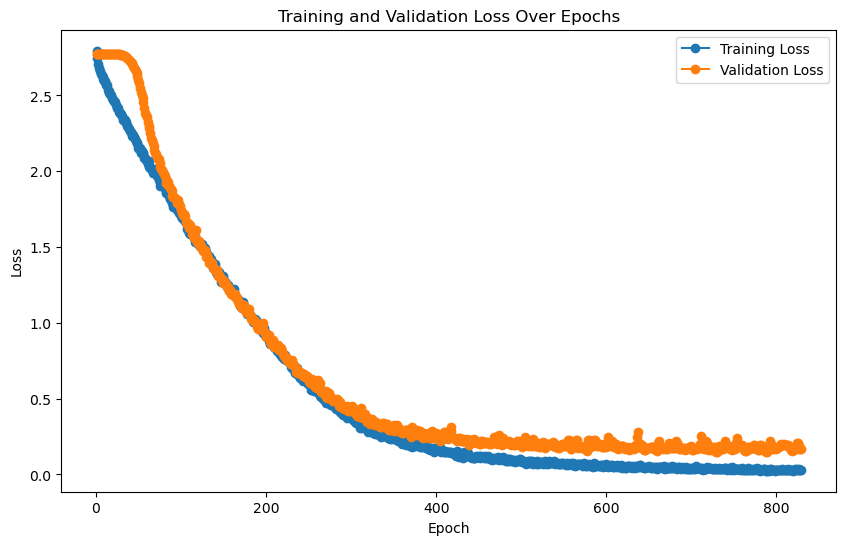

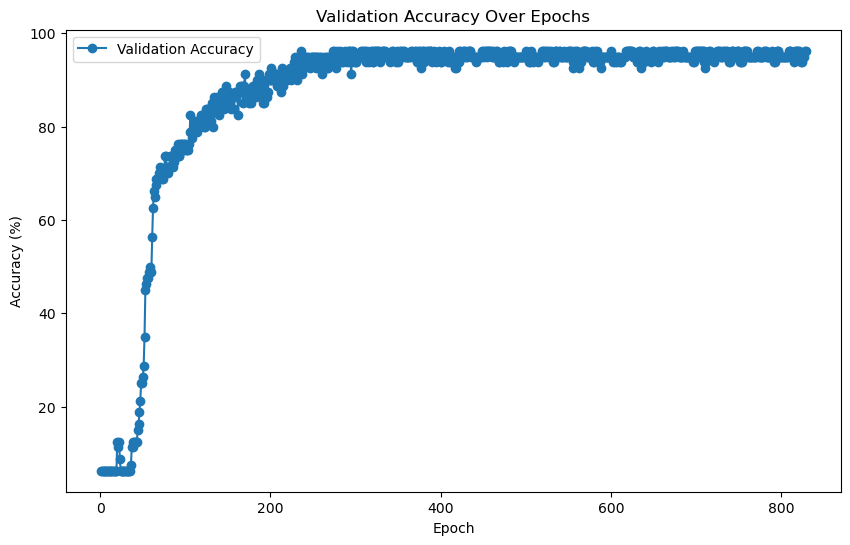


Evaluating on the test set...
    Test Batch [1/210], Loss: 0.2993



Final Test Loss: 0.4977, Test Accuracy: 89.27%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.


  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.
  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.


  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.


  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.


  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53729, 64), Test labels shape: (53729,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.38      0.60      0.46         5
           8       0.83      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53729, 64)
Test labels shape: (53729,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8192  |  Val Loss: 2.6267
Validation loss improved from inf to 2.6267.
[Epoch 2/1000] Train Loss: 2.5570  |  Val Loss: 2.4595
Validation loss improved from 2.6267 to 2.4595.
[Epoch 3/1000] Train Loss: 2.4049  |  Val Loss: 2.3308
Validation loss improved from 2.4595 to 2.3308.
[Epoch 4/1000] Train Loss: 2.2762  |  Val Loss: 2.2046
Validation loss improved from 2.3308 to 2.2046.
[Epoch 5/1000] Train Loss: 2.1389  |  Val Loss: 2.0607
Validation loss improved from 2.2046 to 2.0607.
[Epoch 6/1000] Train Loss: 1.9950  |  Val Loss: 1.9149
Validation loss improved from 2.0607 to 1.9149.
[Epoch 7/1000] Train Loss: 1.8434  |  Val Loss: 1.7654
Validation loss improved from 1.9149 to 1.7654.
[Epoch 8/1000] Train Loss: 1.6997  |  Val Loss: 1.6271
Validation loss improved from 1.7654 to 1.6271.
[Epoch 9/1000] Train Loss: 1.5610  |  Val Loss: 1.4862
Validation loss improved from 1.6271 to 1.4862.
[Epoch 10/1000] Train Loss: 1.4145  |  Val Loss: 1.3671
Validation loss impr

[Epoch 13/1000] Train Loss: 1.0743  |  Val Loss: 1.0516
Validation loss improved from 1.1448 to 1.0516.
[Epoch 14/1000] Train Loss: 0.9849  |  Val Loss: 0.9823
Validation loss improved from 1.0516 to 0.9823.
[Epoch 15/1000] Train Loss: 0.9114  |  Val Loss: 0.9163
Validation loss improved from 0.9823 to 0.9163.
[Epoch 16/1000] Train Loss: 0.8435  |  Val Loss: 0.8655
Validation loss improved from 0.9163 to 0.8655.
[Epoch 17/1000] Train Loss: 0.7825  |  Val Loss: 0.8195
Validation loss improved from 0.8655 to 0.8195.
[Epoch 18/1000] Train Loss: 0.7299  |  Val Loss: 0.7721
Validation loss improved from 0.8195 to 0.7721.
[Epoch 19/1000] Train Loss: 0.6936  |  Val Loss: 0.7359
Validation loss improved from 0.7721 to 0.7359.


[Epoch 20/1000] Train Loss: 0.6524  |  Val Loss: 0.7106
Validation loss improved from 0.7359 to 0.7106.
[Epoch 21/1000] Train Loss: 0.6189  |  Val Loss: 0.6724
Validation loss improved from 0.7106 to 0.6724.
[Epoch 22/1000] Train Loss: 0.5858  |  Val Loss: 0.6540
Validation loss improved from 0.6724 to 0.6540.
[Epoch 23/1000] Train Loss: 0.5548  |  Val Loss: 0.6212
Validation loss improved from 0.6540 to 0.6212.
[Epoch 24/1000] Train Loss: 0.5284  |  Val Loss: 0.6050
Validation loss improved from 0.6212 to 0.6050.
[Epoch 25/1000] Train Loss: 0.5039  |  Val Loss: 0.5693
Validation loss improved from 0.6050 to 0.5693.
[Epoch 26/1000] Train Loss: 0.4789  |  Val Loss: 0.5639
Validation loss improved from 0.5693 to 0.5639.
[Epoch 27/1000] Train Loss: 0.4614  |  Val Loss: 0.5447
Validation loss improved from 0.5639 to 0.5447.
[Epoch 28/1000] Train Loss: 0.4501  |  Val Loss: 0.5116
Validation loss improved from 0.5447 to 0.5116.
[Epoch 29/1000] Train Loss: 0.4198  |  Val Loss: 0.5146
!! Valid

[Epoch 31/1000] Train Loss: 0.3953  |  Val Loss: 0.4705
Validation loss improved from 0.5105 to 0.4705.
[Epoch 32/1000] Train Loss: 0.3758  |  Val Loss: 0.4635
Validation loss improved from 0.4705 to 0.4635.
[Epoch 33/1000] Train Loss: 0.3599  |  Val Loss: 0.4630
Validation loss improved from 0.4635 to 0.4630.
[Epoch 34/1000] Train Loss: 0.3449  |  Val Loss: 0.4528
Validation loss improved from 0.4630 to 0.4528.
[Epoch 35/1000] Train Loss: 0.3406  |  Val Loss: 0.4288
Validation loss improved from 0.4528 to 0.4288.
[Epoch 36/1000] Train Loss: 0.3228  |  Val Loss: 0.4272
Validation loss improved from 0.4288 to 0.4272.
[Epoch 37/1000] Train Loss: 0.3080  |  Val Loss: 0.4148
Validation loss improved from 0.4272 to 0.4148.
[Epoch 38/1000] Train Loss: 0.3035  |  Val Loss: 0.4098
Validation loss improved from 0.4148 to 0.4098.


[Epoch 39/1000] Train Loss: 0.2879  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.2889  |  Val Loss: 0.3973
Validation loss improved from 0.4098 to 0.3973.
[Epoch 41/1000] Train Loss: 0.2824  |  Val Loss: 0.3925
Validation loss improved from 0.3973 to 0.3925.
[Epoch 42/1000] Train Loss: 0.2728  |  Val Loss: 0.3807
Validation loss improved from 0.3925 to 0.3807.
[Epoch 43/1000] Train Loss: 0.2580  |  Val Loss: 0.3865
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.2507  |  Val Loss: 0.3849
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 0.2444  |  Val Loss: 0.3683
Validation loss improved from 0.3807 to 0.3683.
[Epoch 46/1000] Train Loss: 0.2437  |  Val Loss: 0.3828
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.2481  |  Val Loss: 0.3591
Validation loss improved from 0.3683 to 0.3591.
[Epoch 48/1000] Train Loss: 0.2371  |  V

[Epoch 51/1000] Train Loss: 0.2098  |  Val Loss: 0.3564
Validation loss improved from 0.3591 to 0.3564.
[Epoch 52/1000] Train Loss: 0.2127  |  Val Loss: 0.3487
Validation loss improved from 0.3564 to 0.3487.
[Epoch 53/1000] Train Loss: 0.2106  |  Val Loss: 0.3536
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.2077  |  Val Loss: 0.3530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.2084  |  Val Loss: 0.3532
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 56/1000] Train Loss: 0.1898  |  Val Loss: 0.3502
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 57/1000] Train Loss: 0.2015  |  Val Loss: 0.3316
Validation loss improved from 0.3487 to 0.3316.


[Epoch 58/1000] Train Loss: 0.1960  |  Val Loss: 0.3228
Validation loss improved from 0.3316 to 0.3228.
[Epoch 59/1000] Train Loss: 0.1926  |  Val Loss: 0.3760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.1903  |  Val Loss: 0.3358
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.1850  |  Val Loss: 0.3250
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.1690  |  Val Loss: 0.3402
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 63/1000] Train Loss: 0.1708  |  Val Loss: 0.3226
Validation loss improved from 0.3228 to 0.3226.
[Epoch 64/1000] Train Loss: 0.1684  |  Val Loss: 0.3280
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.1756  |  Val Loss: 0.3212
Validation loss improved from 0.3226 to 0.3212.
[Epoch 66/1000] Train Loss: 0.1731  |  Val Loss: 0.3406
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 

[Epoch 68/1000] Train Loss: 0.1807  |  Val Loss: 0.3429
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 69/1000] Train Loss: 0.1595  |  Val Loss: 0.3284
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 70/1000] Train Loss: 0.1484  |  Val Loss: 0.3216
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 71/1000] Train Loss: 0.1549  |  Val Loss: 0.3139
Validation loss improved from 0.3212 to 0.3139.
[Epoch 72/1000] Train Loss: 0.1464  |  Val Loss: 0.3282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.1465  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.1488  |  Val Loss: 0.3138
Validation loss improved from 0.3139 to 0.3138.
[Epoch 75/1000] Train Loss: 0.1488  |  Val Loss: 0.3195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 0.1372  |  Val Loss: 0.3117
Validation loss improved from 0.3138 to 0.3117.


[Epoch 77/1000] Train Loss: 0.1397  |  Val Loss: 0.3079
Validation loss improved from 0.3117 to 0.3079.
[Epoch 78/1000] Train Loss: 0.1345  |  Val Loss: 0.3183
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.1341  |  Val Loss: 0.3265
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.1304  |  Val Loss: 0.3061
Validation loss improved from 0.3079 to 0.3061.
[Epoch 81/1000] Train Loss: 0.1311  |  Val Loss: 0.3119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 0.1349  |  Val Loss: 0.3217
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 0.1268  |  Val Loss: 0.3176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 0.1254  |  Val Loss: 0.3099
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 85/1000] Train Loss: 0.1273  |  Val Loss: 0.2967
Validation loss improved from 0.3061 to 0.2967.
[Epoch 86/1000] Train Loss: 

[Epoch 88/1000] Train Loss: 0.1298  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 0.1303  |  Val Loss: 0.3260
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 90/1000] Train Loss: 0.1242  |  Val Loss: 0.3380
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 0.1209  |  Val Loss: 0.3227
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 0.1287  |  Val Loss: 0.3208
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 93/1000] Train Loss: 0.1230  |  Val Loss: 0.3185
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 94/1000] Train Loss: 0.1135  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 95/1000] Train Loss: 0.1151  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 96/1000] Train Loss: 0.1284  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 97/1000] Train Loss: 0.1094  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 98/1000] Train Loss: 0.1188  |  Val Loss: 0.3320
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 99/1000] Train Loss: 0.1226  |  Val Loss: 0.3499
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 100/1000] Train Loss: 0.1206  |  Val Loss: 0.3296
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 101/1000] Train Loss: 0.1218  |  Val Loss: 0.3751
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 102/1000] Train Loss: 0.1217  |  Val Loss: 0.3489
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 103/1000] Train Loss: 0.1313  |  Val Loss: 0.3199
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 104/1000] Train Loss: 0.1045  |  Val Loss: 0.3243
!! Validation loss did NOT improve !! Patience: 19/

[Epoch 108/1000] Train Loss: 0.1072  |  Val Loss: 0.2958
Validation loss improved from 0.2967 to 0.2958.
[Epoch 109/1000] Train Loss: 0.1108  |  Val Loss: 0.3179
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.1041  |  Val Loss: 0.3174
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 111/1000] Train Loss: 0.0971  |  Val Loss: 0.3089
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 112/1000] Train Loss: 0.0951  |  Val Loss: 0.3217
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 113/1000] Train Loss: 0.1009  |  Val Loss: 0.3187
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 114/1000] Train Loss: 0.0951  |  Val Loss: 0.2932
Validation loss improved from 0.2958 to 0.2932.
[Epoch 115/1000] Train Loss: 0.0964  |  Val Loss: 0.3163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 0.0878  |  Val Loss: 0.3064
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 0.0949  |  Val Loss: 0.3140
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 0.0855  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] Train Loss: 0.0875  |  Val Loss: 0.3031
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 120/1000] Train Loss: 0.0922  |  Val Loss: 0.3182
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 121/1000] Train Loss: 0.0879  |  Val Loss: 0.3012
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 122/1000] Train Loss: 0.0930  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 127/1000] Train Loss: 0.0993  |  Val Loss: 0.3027
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 128/1000] Train Loss: 0.0991  |  Val Loss: 0.3395
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 129/1000] Train Loss: 0.0868  |  Val Loss: 0.3228
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 130/1000] Train Loss: 0.0862  |  Val Loss: 0.3270
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 131/1000] Train Loss: 0.0911  |  Val Loss: 0.3055
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 132/1000] Train Loss: 0.0977  |  Val Loss: 0.3135
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 133/1000] Train Loss: 0.0793  |  Val Loss: 0.3382
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 134/1000] Train Loss: 0.0850  |  Val Loss: 0.2923
Validation loss improved from 0.2932 to 0.2923.
[Epoch 135/1000] Train Loss: 0.0813  |  Val Loss: 0.3078
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 0.0898  |  Val Loss: 0.3298
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 0.0872  |  Val Loss: 0.2931
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 0.0744  |  Val Loss: 0.3293
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/1000] Train Loss: 0.0851  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 140/1000] Train Loss: 0.0886  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 141/1000] Train Loss: 0.0881  |  Val Loss: 0.3353
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 145/1000] Train Loss: 0.0836  |  Val Loss: 0.3494
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 146/1000] Train Loss: 0.0875  |  Val Loss: 0.3163
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 147/1000] Train Loss: 0.0934  |  Val Loss: 0.3175
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 148/1000] Train Loss: 0.1142  |  Val Loss: 0.3393
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 149/1000] Train Loss: 0.1002  |  Val Loss: 0.3253
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 150/1000] Train Loss: 0.0803  |  Val Loss: 0.3564
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 151/1000] Train Loss: 0.0848  |  Val Loss: 0.3636
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 152/1000] Train Loss: 0.0742  |  Val Loss: 0.3253
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 153/1000] Train Loss: 0.0946  |  Val Loss: 0.3306
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 154/1000] Train Loss: 0.0797  |  Val Loss: 0.3230
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 155/1000] Train Loss: 0.0804  |  Val Loss: 0.3125
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 156/1000] Train Loss: 0.0889  |  Val Loss: 0.3189
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 157/1000] Train Loss: 0.0672  |  Val Loss: 0.3404
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 158/1000] Train Loss: 0.0801  |  Val Loss: 0.3330
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 159/1000] Train Loss: 0.0716  |  Val Loss: 0.3379
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 160/1000] Train Loss: 0.0712  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.0575  |  Val Loss: 0.3419
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 165/1000] Train Loss: 0.0680  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 166/1000] Train Loss: 0.0630  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 167/1000] Train Loss: 0.0634  |  Val Loss: 0.3332
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 168/1000] Train Loss: 0.0592  |  Val Loss: 0.3172
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 169/1000] Train Loss: 0.0628  |  Val Loss: 0.3321
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 170/1000] Train Loss: 0.0598  |  Val Loss: 0.3516
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 171/1000] Train Loss: 0.0581  |  Val Loss: 0.3221
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 172/1000] Train Loss: 0.0593  |  Val Loss: 0.3240
!! Validation loss did NOT improve !! Patience:

[Epoch 173/1000] Train Loss: 0.0587  |  Val Loss: 0.3340
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 174/1000] Train Loss: 0.0624  |  Val Loss: 0.3169
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 175/1000] Train Loss: 0.0593  |  Val Loss: 0.3318
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 176/1000] Train Loss: 0.0563  |  Val Loss: 0.3374
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 177/1000] Train Loss: 0.0540  |  Val Loss: 0.3422
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 178/1000] Train Loss: 0.0552  |  Val Loss: 0.3355
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 179/1000] Train Loss: 0.0552  |  Val Loss: 0.3462
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 180/1000] Train Loss: 0.0580  |  Val Loss: 0.3228
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 181/1000] Train Loss: 0.0533  |  Val Loss: 0.3493
!! Validation loss did NOT improve !! Patience:

[Epoch 182/1000] Train Loss: 0.0538  |  Val Loss: 0.3312
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 183/1000] Train Loss: 0.0519  |  Val Loss: 0.3194
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 184/1000] Train Loss: 0.0522  |  Val Loss: 0.3301
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 185/1000] Train Loss: 0.0624  |  Val Loss: 0.3593
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 186/1000] Train Loss: 0.0549  |  Val Loss: 0.3264
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 187/1000] Train Loss: 0.0595  |  Val Loss: 0.3626
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 188/1000] Train Loss: 0.0541  |  Val Loss: 0.3588
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 189/1000] Train Loss: 0.0558  |  Val Loss: 0.3232
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 190/1000] Train Loss: 0.0555  |  Val Loss: 0.3658
!! Validation loss did NOT improve !! Patience:

[Epoch 193/1000] Train Loss: 0.0516  |  Val Loss: 0.3591
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 194/1000] Train Loss: 0.0690  |  Val Loss: 0.3676
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 195/1000] Train Loss: 0.0518  |  Val Loss: 0.3415
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 196/1000] Train Loss: 0.0521  |  Val Loss: 0.3684
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 197/1000] Train Loss: 0.0625  |  Val Loss: 0.3720
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 198/1000] Train Loss: 0.0520  |  Val Loss: 0.3389
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 199/1000] Train Loss: 0.0484  |  Val Loss: 0.3619
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 200/1000] Train Loss: 0.0493  |  Val Loss: 0.3416
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 201/1000] Train Loss: 0.0465  |  Val Loss: 0.3515
!! Validation loss did NOT improve !! Patience:

[Epoch 202/1000] Train Loss: 0.0501  |  Val Loss: 0.3486
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 203/1000] Train Loss: 0.0508  |  Val Loss: 0.3530
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 204/1000] Train Loss: 0.0520  |  Val Loss: 0.3462
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 205/1000] Train Loss: 0.0577  |  Val Loss: 0.3637
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 206/1000] Train Loss: 0.0589  |  Val Loss: 0.3904
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 207/1000] Train Loss: 0.0451  |  Val Loss: 0.3540
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 208/1000] Train Loss: 0.0645  |  Val Loss: 0.3630
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 209/1000] Train Loss: 0.0587  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 210/1000] Train Loss: 0.0478  |  Val Loss: 0.3332
!! Validation loss did NOT improve !! Patience:

[Epoch 212/1000] Train Loss: 0.0518  |  Val Loss: 0.3700
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 213/1000] Train Loss: 0.0469  |  Val Loss: 0.3580
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 214/1000] Train Loss: 0.0500  |  Val Loss: 0.3760
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 215/1000] Train Loss: 0.0515  |  Val Loss: 0.3912
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 216/1000] Train Loss: 0.0454  |  Val Loss: 0.3651
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 217/1000] Train Loss: 0.0431  |  Val Loss: 0.3988
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 218/1000] Train Loss: 0.0432  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 219/1000] Train Loss: 0.0421  |  Val Loss: 0.3705
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 220/1000] Train Loss: 0.0417  |  Val Loss: 0.3818
!! Validation loss did NOT improve !! Patience:

[Epoch 221/1000] Train Loss: 0.0443  |  Val Loss: 0.3840
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 222/1000] Train Loss: 0.0431  |  Val Loss: 0.3729
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 223/1000] Train Loss: 0.0472  |  Val Loss: 0.3717
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 224/1000] Train Loss: 0.0472  |  Val Loss: 0.3817
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 225/1000] Train Loss: 0.0524  |  Val Loss: 0.4097
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 226/1000] Train Loss: 0.0472  |  Val Loss: 0.3633
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 227/1000] Train Loss: 0.0459  |  Val Loss: 0.3708
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 228/1000] Train Loss: 0.0464  |  Val Loss: 0.4020
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 229/1000] Train Loss: 0.0540  |  Val Loss: 0.3558
!! Validation loss did NOT improve !! Patience:

[Epoch 233/1000] Train Loss: 0.0431  |  Val Loss: 0.3649
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 234/1000] Train Loss: 0.0380  |  Val Loss: 0.3763
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 234 !!
No improvement for 100 epochs.


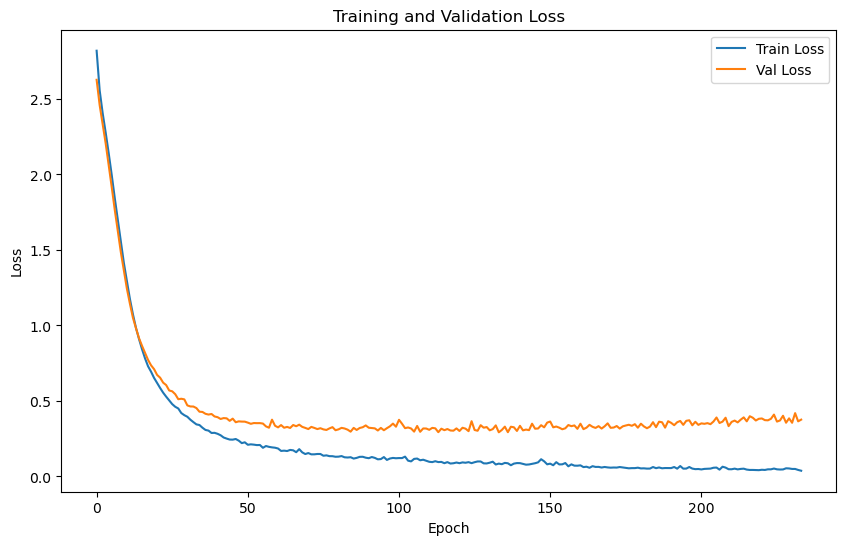

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9564 | Test Accuracy: 83.26%


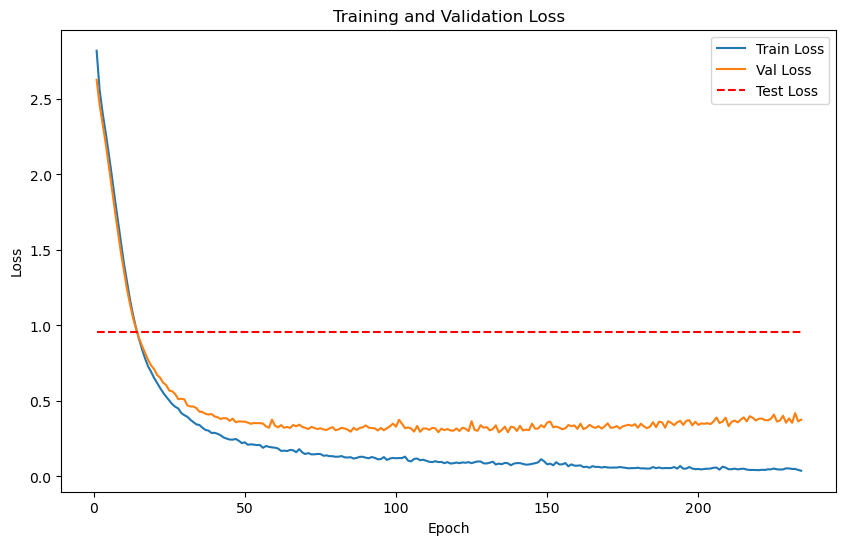

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.0422
Epoch [1/2000], Avg Train Loss: 8.0422
Epoch [1/2000], Avg Val Loss: 2.8084
Validation loss improved from inf to 2.8084. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.8923
Epoch [2/2000], Avg Train Loss: 7.8923
Epoch [2/2000], Avg Val Loss: 2.7990
Validation loss improved from 2.8084 to 2.7990. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.8985
Epoch [3/2000], Avg Train Loss: 7.8985
Epoch [3/2000], Avg Val Loss: 2.7901
Validation loss improved from 2.7990 to 2.7901. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 7.8673
Epoch [4/2000], Avg Train Loss: 7.8673
Epoch [4/2000], Avg Val Loss: 2.7817
Validation loss improved from 2.7901 to 2.7817. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6430
Epoch [5/2000], Avg Train Loss: 7.6430
Epoch [5/2000], Avg Val Loss: 2.7736
Validation loss improved from 2.7817 to 2.7736. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7146
Epoch [6/2000], Avg Train Loss: 7.7146
Epoch [6/2000], Avg Val Loss: 2.7657
Validation loss improved from 2.7736 to 2.7657. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.5497
Epoch [7/2000], Avg Train Loss: 7.5497
Epoch [7/2000], Avg Val Loss: 2.7583
Validation loss improved from 2.7657 to 2.7583. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.6219
Epoch [8/2000], Avg Train Loss: 7.6219
Epoch [8/2000], Avg Val Loss: 2.7511
Validation loss improved from 2.7583 to 2.7511. Saving m

    Batch [1/1], Train Loss: 6.9322
Epoch [18/2000], Avg Train Loss: 6.9322
Epoch [18/2000], Avg Val Loss: 2.6963
Validation loss improved from 2.7005 to 2.6963. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.8245
Epoch [19/2000], Avg Train Loss: 6.8245
Epoch [19/2000], Avg Val Loss: 2.6923
Validation loss improved from 2.6963 to 2.6923. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.7586
Epoch [20/2000], Avg Train Loss: 6.7586
Epoch [20/2000], Avg Val Loss: 2.6885
Validation loss improved from 2.6923 to 2.6885. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.7162
Epoch [21/2000], Avg Train Loss: 6.7162
Epoch [21/2000], Avg Val Loss: 2.6850
Validation loss improved from 2.6885 to 2.6850. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.6912
Epoch [22/2000], Avg Train Loss: 6.6912
Epoch [22/2000], Avg Val Loss: 2.6818
Validation loss improved from 2.6850 to 2.

    Batch [1/1], Train Loss: 5.9559
Epoch [40/2000], Avg Train Loss: 5.9559
Epoch [40/2000], Avg Val Loss: 2.6497
Validation loss improved from 2.6504 to 2.6497. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.0139
Epoch [41/2000], Avg Train Loss: 6.0139
Epoch [41/2000], Avg Val Loss: 2.6491
Validation loss improved from 2.6497 to 2.6491. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 5.9429
Epoch [42/2000], Avg Train Loss: 5.9429
Epoch [42/2000], Avg Val Loss: 2.6486
Validation loss improved from 2.6491 to 2.6486. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.8775
Epoch [43/2000], Avg Train Loss: 5.8775
Epoch [43/2000], Avg Val Loss: 2.6481
Validation loss improved from 2.6486 to 2.6481. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.7698
Epoch [44/2000], Avg Train Loss: 5.7698
Epoch [44/2000], Avg Val Loss: 2.6478
Validation loss improved from 2.6481 to 2.

Epoch [56/2000], Avg Val Loss: 2.6474
Validation loss did not improve. Patience: 6/100

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.5038
Epoch [57/2000], Avg Train Loss: 5.5038
Epoch [57/2000], Avg Val Loss: 2.6477
Validation loss did not improve. Patience: 7/100

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.5443
Epoch [58/2000], Avg Train Loss: 5.5443
Epoch [58/2000], Avg Val Loss: 2.6480
Validation loss did not improve. Patience: 8/100

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.5351
Epoch [59/2000], Avg Train Loss: 5.5351
Epoch [59/2000], Avg Val Loss: 2.6483
Validation loss did not improve. Patience: 9/100

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.4127
Epoch [60/2000], Avg Train Loss: 5.4127
Epoch [60/2000], Avg Val Loss: 2.6487
Validation loss did not improve. Patience: 10/100

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.4340
Epoch [61/2000], Avg Train Loss: 5.4340
Epoch [61/2000], Av

    Batch [1/1], Train Loss: 5.2444
Epoch [74/2000], Avg Train Loss: 5.2444
Epoch [74/2000], Avg Val Loss: 2.6554
Validation loss did not improve. Patience: 24/100

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.2412
Epoch [75/2000], Avg Train Loss: 5.2412
Epoch [75/2000], Avg Val Loss: 2.6558
Validation loss did not improve. Patience: 25/100

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.1740
Epoch [76/2000], Avg Train Loss: 5.1740
Epoch [76/2000], Avg Val Loss: 2.6563
Validation loss did not improve. Patience: 26/100

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.1574
Epoch [77/2000], Avg Train Loss: 5.1574
Epoch [77/2000], Avg Val Loss: 2.6567
Validation loss did not improve. Patience: 27/100

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.1808
Epoch [78/2000], Avg Train Loss: 5.1808
Epoch [78/2000], Avg Val Loss: 2.6572
Validation loss did not improve. Patience: 28/100

LOG: Epoch [79/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 5.0429
Epoch [91/2000], Avg Train Loss: 5.0429
Epoch [91/2000], Avg Val Loss: 2.6597
Validation loss did not improve. Patience: 41/100

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0747
Epoch [92/2000], Avg Train Loss: 5.0747
Epoch [92/2000], Avg Val Loss: 2.6597
Validation loss did not improve. Patience: 42/100

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.9588
Epoch [93/2000], Avg Train Loss: 4.9588
Epoch [93/2000], Avg Val Loss: 2.6597
Validation loss did not improve. Patience: 43/100

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0619
Epoch [94/2000], Avg Train Loss: 5.0619
Epoch [94/2000], Avg Val Loss: 2.6596
Validation loss did not improve. Patience: 44/100

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.9894
Epoch [95/2000], Avg Train Loss: 4.9894
Epoch [95/2000], Avg Val Loss: 2.6595
Validation loss did not improve. Patience: 45/100

LOG: Epoch [96/2000] - Training
    Batch [1/1]

Epoch [109/2000], Avg Val Loss: 2.6572
Validation loss did not improve. Patience: 59/100

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.9014
Epoch [110/2000], Avg Train Loss: 4.9014
Epoch [110/2000], Avg Val Loss: 2.6568
Validation loss did not improve. Patience: 60/100

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9101
Epoch [111/2000], Avg Train Loss: 4.9101
Epoch [111/2000], Avg Val Loss: 2.6565
Validation loss did not improve. Patience: 61/100

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.9280
Epoch [112/2000], Avg Train Loss: 4.9280
Epoch [112/2000], Avg Val Loss: 2.6562
Validation loss did not improve. Patience: 62/100

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.8549
Epoch [113/2000], Avg Train Loss: 4.8549
Epoch [113/2000], Avg Val Loss: 2.6558
Validation loss did not improve. Patience: 63/100

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.8542
Epoch [114/2000], Avg Train Loss: 4.8542


    Batch [1/1], Train Loss: 4.8070
Epoch [126/2000], Avg Train Loss: 4.8070
Epoch [126/2000], Avg Val Loss: 2.6494
Validation loss did not improve. Patience: 76/100

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.8470
Epoch [127/2000], Avg Train Loss: 4.8470
Epoch [127/2000], Avg Val Loss: 2.6488
Validation loss did not improve. Patience: 77/100

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.7633
Epoch [128/2000], Avg Train Loss: 4.7633
Epoch [128/2000], Avg Val Loss: 2.6482
Validation loss did not improve. Patience: 78/100

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.7385
Epoch [129/2000], Avg Train Loss: 4.7385
Epoch [129/2000], Avg Val Loss: 2.6476
Validation loss did not improve. Patience: 79/100

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.7401
Epoch [130/2000], Avg Train Loss: 4.7401
Epoch [130/2000], Avg Val Loss: 2.6470
Validation loss did not improve. Patience: 80/100

LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 4.7202
Epoch [146/2000], Avg Train Loss: 4.7202
Epoch [146/2000], Avg Val Loss: 2.6347
Validation loss improved from 2.6355 to 2.6347. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.6799
Epoch [147/2000], Avg Train Loss: 4.6799
Epoch [147/2000], Avg Val Loss: 2.6339
Validation loss improved from 2.6347 to 2.6339. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6927
Epoch [148/2000], Avg Train Loss: 4.6927
Epoch [148/2000], Avg Val Loss: 2.6330
Validation loss improved from 2.6339 to 2.6330. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.7408
Epoch [149/2000], Avg Train Loss: 4.7408
Epoch [149/2000], Avg Val Loss: 2.6322
Validation loss improved from 2.6330 to 2.6322. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.6747
Epoch [150/2000], Avg Train Loss: 4.6747
Epoch [150/2000], Avg Val Loss: 2.6313
Validation loss improved fro

Epoch [159/2000], Avg Val Loss: 2.6232
Validation loss improved from 2.6241 to 2.6232. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.6469
Epoch [160/2000], Avg Train Loss: 4.6469
Epoch [160/2000], Avg Val Loss: 2.6222
Validation loss improved from 2.6232 to 2.6222. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6916
Epoch [161/2000], Avg Train Loss: 4.6916
Epoch [161/2000], Avg Val Loss: 2.6213
Validation loss improved from 2.6222 to 2.6213. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6928
Epoch [162/2000], Avg Train Loss: 4.6928
Epoch [162/2000], Avg Val Loss: 2.6203
Validation loss improved from 2.6213 to 2.6203. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.6543
Epoch [163/2000], Avg Train Loss: 4.6543
Epoch [163/2000], Avg Val Loss: 2.6194
Validation loss improved from 2.6203 to 2.6194. Saving model...

LOG: Epoch [164/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6129
Epoch [181/2000], Avg Train Loss: 4.6129
Epoch [181/2000], Avg Val Loss: 2.6014
Validation loss improved from 2.6025 to 2.6014. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.5562
Epoch [182/2000], Avg Train Loss: 4.5562
Epoch [182/2000], Avg Val Loss: 2.6004
Validation loss improved from 2.6014 to 2.6004. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.5714
Epoch [183/2000], Avg Train Loss: 4.5714
Epoch [183/2000], Avg Val Loss: 2.5994
Validation loss improved from 2.6004 to 2.5994. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.5450
Epoch [184/2000], Avg Train Loss: 4.5450
Epoch [184/2000], Avg Val Loss: 2.5983
Validation loss improved from 2.5994 to 2.5983. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.5400
Epoch [185/2000], Avg Train Loss: 4.5400
Epoch [185/2000], Avg Val Loss: 2.5973
Validation loss improved fro

Epoch [199/2000], Avg Val Loss: 2.5838
Validation loss improved from 2.5847 to 2.5838. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.5769
Epoch [200/2000], Avg Train Loss: 4.5769
Epoch [200/2000], Avg Val Loss: 2.5829
Validation loss improved from 2.5838 to 2.5829. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.4918
Epoch [201/2000], Avg Train Loss: 4.4918
Epoch [201/2000], Avg Val Loss: 2.5819
Validation loss improved from 2.5829 to 2.5819. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.5063
Epoch [202/2000], Avg Train Loss: 4.5063
Epoch [202/2000], Avg Val Loss: 2.5810
Validation loss improved from 2.5819 to 2.5810. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.5247
Epoch [203/2000], Avg Train Loss: 4.5247
Epoch [203/2000], Avg Val Loss: 2.5801
Validation loss improved from 2.5810 to 2.5801. Saving model...

LOG: Epoch [204/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5320
Epoch [217/2000], Avg Train Loss: 4.5320
Epoch [217/2000], Avg Val Loss: 2.5675
Validation loss improved from 2.5685 to 2.5675. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.4571
Epoch [218/2000], Avg Train Loss: 4.4571
Epoch [218/2000], Avg Val Loss: 2.5666
Validation loss improved from 2.5675 to 2.5666. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.4838
Epoch [219/2000], Avg Train Loss: 4.4838
Epoch [219/2000], Avg Val Loss: 2.5657
Validation loss improved from 2.5666 to 2.5657. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.4465
Epoch [220/2000], Avg Train Loss: 4.4465
Epoch [220/2000], Avg Val Loss: 2.5647
Validation loss improved from 2.5657 to 2.5647. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.4639
Epoch [221/2000], Avg Train Loss: 4.4639
Epoch [221/2000], Avg Val Loss: 2.5637
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4342
Epoch [234/2000], Avg Train Loss: 4.4342
Epoch [234/2000], Avg Val Loss: 2.5512
Validation loss improved from 2.5521 to 2.5512. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.4380
Epoch [235/2000], Avg Train Loss: 4.4380
Epoch [235/2000], Avg Val Loss: 2.5502
Validation loss improved from 2.5512 to 2.5502. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.4532
Epoch [236/2000], Avg Train Loss: 4.4532
Epoch [236/2000], Avg Val Loss: 2.5492
Validation loss improved from 2.5502 to 2.5492. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.4497
Epoch [237/2000], Avg Train Loss: 4.4497
Epoch [237/2000], Avg Val Loss: 2.5483
Validation loss improved from 2.5492 to 2.5483. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.3739
Epoch [238/2000], Avg Train Loss: 4.3739
Epoch [238/2000], Avg Val Loss: 2.5473
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3622
Epoch [252/2000], Avg Train Loss: 4.3622
Epoch [252/2000], Avg Val Loss: 2.5338
Validation loss improved from 2.5347 to 2.5338. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.4032
Epoch [253/2000], Avg Train Loss: 4.4032
Epoch [253/2000], Avg Val Loss: 2.5329
Validation loss improved from 2.5338 to 2.5329. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.3558
Epoch [254/2000], Avg Train Loss: 4.3558
Epoch [254/2000], Avg Val Loss: 2.5320
Validation loss improved from 2.5329 to 2.5320. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.4176
Epoch [255/2000], Avg Train Loss: 4.4176
Epoch [255/2000], Avg Val Loss: 2.5311
Validation loss improved from 2.5320 to 2.5311. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.3826
Epoch [256/2000], Avg Train Loss: 4.3826
Epoch [256/2000], Avg Val Loss: 2.5302
Validation loss improved fro

Epoch [268/2000], Avg Val Loss: 2.5199
Validation loss improved from 2.5208 to 2.5199. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.3430
Epoch [269/2000], Avg Train Loss: 4.3430
Epoch [269/2000], Avg Val Loss: 2.5190
Validation loss improved from 2.5199 to 2.5190. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.3513
Epoch [270/2000], Avg Train Loss: 4.3513
Epoch [270/2000], Avg Val Loss: 2.5181
Validation loss improved from 2.5190 to 2.5181. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.3723
Epoch [271/2000], Avg Train Loss: 4.3723
Epoch [271/2000], Avg Val Loss: 2.5173
Validation loss improved from 2.5181 to 2.5173. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.3616
Epoch [272/2000], Avg Train Loss: 4.3616
Epoch [272/2000], Avg Val Loss: 2.5164
Validation loss improved from 2.5173 to 2.5164. Saving model...

LOG: Epoch [273/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3354
Epoch [286/2000], Avg Train Loss: 4.3354
Epoch [286/2000], Avg Val Loss: 2.5056
Validation loss improved from 2.5064 to 2.5056. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.3311
Epoch [287/2000], Avg Train Loss: 4.3311
Epoch [287/2000], Avg Val Loss: 2.5049
Validation loss improved from 2.5056 to 2.5049. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.3163
Epoch [288/2000], Avg Train Loss: 4.3163
Epoch [288/2000], Avg Val Loss: 2.5041
Validation loss improved from 2.5049 to 2.5041. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.2766
Epoch [289/2000], Avg Train Loss: 4.2766
Epoch [289/2000], Avg Val Loss: 2.5034
Validation loss improved from 2.5041 to 2.5034. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.3585
Epoch [290/2000], Avg Train Loss: 4.3585
Epoch [290/2000], Avg Val Loss: 2.5027
Validation loss improved fro

Epoch [303/2000], Avg Val Loss: 2.4948
Validation loss improved from 2.4954 to 2.4948. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.3269
Epoch [304/2000], Avg Train Loss: 4.3269
Epoch [304/2000], Avg Val Loss: 2.4942
Validation loss improved from 2.4948 to 2.4942. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.2948
Epoch [305/2000], Avg Train Loss: 4.2948
Epoch [305/2000], Avg Val Loss: 2.4937
Validation loss improved from 2.4942 to 2.4937. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.3027
Epoch [306/2000], Avg Train Loss: 4.3027
Epoch [306/2000], Avg Val Loss: 2.4931
Validation loss improved from 2.4937 to 2.4931. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.3087
Epoch [307/2000], Avg Train Loss: 4.3087
Epoch [307/2000], Avg Val Loss: 2.4924
Validation loss improved from 2.4931 to 2.4924. Saving model...

LOG: Epoch [308/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2249
Epoch [318/2000], Avg Train Loss: 4.2249
Epoch [318/2000], Avg Val Loss: 2.4856
Validation loss improved from 2.4861 to 2.4856. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.2933
Epoch [319/2000], Avg Train Loss: 4.2933
Epoch [319/2000], Avg Val Loss: 2.4850
Validation loss improved from 2.4856 to 2.4850. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.2419
Epoch [320/2000], Avg Train Loss: 4.2419
Epoch [320/2000], Avg Val Loss: 2.4844
Validation loss improved from 2.4850 to 2.4844. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.2245
Epoch [321/2000], Avg Train Loss: 4.2245
Epoch [321/2000], Avg Val Loss: 2.4838
Validation loss improved from 2.4844 to 2.4838. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.2591
Epoch [322/2000], Avg Train Loss: 4.2591
Epoch [322/2000], Avg Val Loss: 2.4832
Validation loss improved fro

Epoch [335/2000], Avg Val Loss: 2.4756
Validation loss improved from 2.4762 to 2.4756. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.2210
Epoch [336/2000], Avg Train Loss: 4.2210
Epoch [336/2000], Avg Val Loss: 2.4750
Validation loss improved from 2.4756 to 2.4750. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.2616
Epoch [337/2000], Avg Train Loss: 4.2616
Epoch [337/2000], Avg Val Loss: 2.4744
Validation loss improved from 2.4750 to 2.4744. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.2634
Epoch [338/2000], Avg Train Loss: 4.2634
Epoch [338/2000], Avg Val Loss: 2.4738
Validation loss improved from 2.4744 to 2.4738. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.2460
Epoch [339/2000], Avg Train Loss: 4.2460
Epoch [339/2000], Avg Val Loss: 2.4732
Validation loss improved from 2.4738 to 2.4732. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1614
Epoch [354/2000], Avg Train Loss: 4.1614
Epoch [354/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4651 to 2.4645. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.1805
Epoch [355/2000], Avg Train Loss: 4.1805
Epoch [355/2000], Avg Val Loss: 2.4640
Validation loss improved from 2.4645 to 2.4640. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.1859
Epoch [356/2000], Avg Train Loss: 4.1859
Epoch [356/2000], Avg Val Loss: 2.4634
Validation loss improved from 2.4640 to 2.4634. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.1906
Epoch [357/2000], Avg Train Loss: 4.1906
Epoch [357/2000], Avg Val Loss: 2.4629
Validation loss improved from 2.4634 to 2.4629. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.2037
Epoch [358/2000], Avg Train Loss: 4.2037
Epoch [358/2000], Avg Val Loss: 2.4623
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2032
Epoch [372/2000], Avg Train Loss: 4.2032
Epoch [372/2000], Avg Val Loss: 2.4561
Validation loss improved from 2.4566 to 2.4561. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.1884
Epoch [373/2000], Avg Train Loss: 4.1884
Epoch [373/2000], Avg Val Loss: 2.4557
Validation loss improved from 2.4561 to 2.4557. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.2101
Epoch [374/2000], Avg Train Loss: 4.2101
Epoch [374/2000], Avg Val Loss: 2.4553
Validation loss improved from 2.4557 to 2.4553. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.1861
Epoch [375/2000], Avg Train Loss: 4.1861
Epoch [375/2000], Avg Val Loss: 2.4548
Validation loss improved from 2.4553 to 2.4548. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.2312
Epoch [376/2000], Avg Train Loss: 4.2312
Epoch [376/2000], Avg Val Loss: 2.4544
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1742
Epoch [390/2000], Avg Train Loss: 4.1742
Epoch [390/2000], Avg Val Loss: 2.4489
Validation loss improved from 2.4492 to 2.4489. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.1481
Epoch [391/2000], Avg Train Loss: 4.1481
Epoch [391/2000], Avg Val Loss: 2.4486
Validation loss improved from 2.4489 to 2.4486. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.1632
Epoch [392/2000], Avg Train Loss: 4.1632
Epoch [392/2000], Avg Val Loss: 2.4482
Validation loss improved from 2.4486 to 2.4482. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.1471
Epoch [393/2000], Avg Train Loss: 4.1471
Epoch [393/2000], Avg Val Loss: 2.4479
Validation loss improved from 2.4482 to 2.4479. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.2035
Epoch [394/2000], Avg Train Loss: 4.2035
Epoch [394/2000], Avg Val Loss: 2.4475
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1825
Epoch [407/2000], Avg Train Loss: 4.1825
Epoch [407/2000], Avg Val Loss: 2.4423
Validation loss improved from 2.4428 to 2.4423. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 4.1088
Epoch [408/2000], Avg Train Loss: 4.1088
Epoch [408/2000], Avg Val Loss: 2.4418
Validation loss improved from 2.4423 to 2.4418. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.1190
Epoch [409/2000], Avg Train Loss: 4.1190
Epoch [409/2000], Avg Val Loss: 2.4413
Validation loss improved from 2.4418 to 2.4413. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.1271
Epoch [410/2000], Avg Train Loss: 4.1271
Epoch [410/2000], Avg Val Loss: 2.4408
Validation loss improved from 2.4413 to 2.4408. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.1246
Epoch [411/2000], Avg Train Loss: 4.1246
Epoch [411/2000], Avg Val Loss: 2.4403
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1380
Epoch [427/2000], Avg Train Loss: 4.1380
Epoch [427/2000], Avg Val Loss: 2.4335
Validation loss improved from 2.4339 to 2.4335. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.1290
Epoch [428/2000], Avg Train Loss: 4.1290
Epoch [428/2000], Avg Val Loss: 2.4331
Validation loss improved from 2.4335 to 2.4331. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.1387
Epoch [429/2000], Avg Train Loss: 4.1387
Epoch [429/2000], Avg Val Loss: 2.4327
Validation loss improved from 2.4331 to 2.4327. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.1171
Epoch [430/2000], Avg Train Loss: 4.1171
Epoch [430/2000], Avg Val Loss: 2.4323
Validation loss improved from 2.4327 to 2.4323. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.1047
Epoch [431/2000], Avg Train Loss: 4.1047
Epoch [431/2000], Avg Val Loss: 2.4319
Validation loss improved fro

Epoch [442/2000], Avg Val Loss: 2.4271
Validation loss improved from 2.4276 to 2.4271. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.0927
Epoch [443/2000], Avg Train Loss: 4.0927
Epoch [443/2000], Avg Val Loss: 2.4266
Validation loss improved from 2.4271 to 2.4266. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.1215
Epoch [444/2000], Avg Train Loss: 4.1215
Epoch [444/2000], Avg Val Loss: 2.4261
Validation loss improved from 2.4266 to 2.4261. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.1067
Epoch [445/2000], Avg Train Loss: 4.1067
Epoch [445/2000], Avg Val Loss: 2.4256
Validation loss improved from 2.4261 to 2.4256. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.1085
Epoch [446/2000], Avg Train Loss: 4.1085
Epoch [446/2000], Avg Val Loss: 2.4252
Validation loss improved from 2.4256 to 2.4252. Saving model...

LOG: Epoch [447/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1252
Epoch [464/2000], Avg Train Loss: 4.1252
Epoch [464/2000], Avg Val Loss: 2.4180
Validation loss improved from 2.4184 to 2.4180. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.0679
Epoch [465/2000], Avg Train Loss: 4.0679
Epoch [465/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4180 to 2.4176. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.0737
Epoch [466/2000], Avg Train Loss: 4.0737
Epoch [466/2000], Avg Val Loss: 2.4173
Validation loss improved from 2.4176 to 2.4173. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 4.0865
Epoch [467/2000], Avg Train Loss: 4.0865
Epoch [467/2000], Avg Val Loss: 2.4169
Validation loss improved from 2.4173 to 2.4169. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.0961
Epoch [468/2000], Avg Train Loss: 4.0961
Epoch [468/2000], Avg Val Loss: 2.4165
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0740
Epoch [478/2000], Avg Train Loss: 4.0740
Epoch [478/2000], Avg Val Loss: 2.4125
Validation loss improved from 2.4129 to 2.4125. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.0988
Epoch [479/2000], Avg Train Loss: 4.0988
Epoch [479/2000], Avg Val Loss: 2.4122
Validation loss improved from 2.4125 to 2.4122. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.0896
Epoch [480/2000], Avg Train Loss: 4.0896
Epoch [480/2000], Avg Val Loss: 2.4118
Validation loss improved from 2.4122 to 2.4118. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.0463
Epoch [481/2000], Avg Train Loss: 4.0463
Epoch [481/2000], Avg Val Loss: 2.4115
Validation loss improved from 2.4118 to 2.4115. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.0587
Epoch [482/2000], Avg Train Loss: 4.0587
Epoch [482/2000], Avg Val Loss: 2.4112
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0279
Epoch [504/2000], Avg Train Loss: 4.0279
Epoch [504/2000], Avg Val Loss: 2.4050
Validation loss improved from 2.4052 to 2.4050. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.0372
Epoch [505/2000], Avg Train Loss: 4.0372
Epoch [505/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4050 to 2.4047. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.0539
Epoch [506/2000], Avg Train Loss: 4.0539
Epoch [506/2000], Avg Val Loss: 2.4045
Validation loss improved from 2.4047 to 2.4045. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.0252
Epoch [507/2000], Avg Train Loss: 4.0252
Epoch [507/2000], Avg Val Loss: 2.4042
Validation loss improved from 2.4045 to 2.4042. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.0219
Epoch [508/2000], Avg Train Loss: 4.0219
Epoch [508/2000], Avg Val Loss: 2.4040
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0407
Epoch [512/2000], Avg Train Loss: 4.0407
Epoch [512/2000], Avg Val Loss: 2.4031
Validation loss improved from 2.4033 to 2.4031. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.0331
Epoch [513/2000], Avg Train Loss: 4.0331
Epoch [513/2000], Avg Val Loss: 2.4028
Validation loss improved from 2.4031 to 2.4028. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.0166
Epoch [514/2000], Avg Train Loss: 4.0166
Epoch [514/2000], Avg Val Loss: 2.4025
Validation loss improved from 2.4028 to 2.4025. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.0488
Epoch [515/2000], Avg Train Loss: 4.0488
Epoch [515/2000], Avg Val Loss: 2.4023
Validation loss improved from 2.4025 to 2.4023. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.0040
Epoch [516/2000], Avg Train Loss: 4.0040
Epoch [516/2000], Avg Val Loss: 2.4021
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0319
Epoch [540/2000], Avg Train Loss: 4.0319
Epoch [540/2000], Avg Val Loss: 2.3960
Validation loss improved from 2.3962 to 2.3960. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 3.9732
Epoch [541/2000], Avg Train Loss: 3.9732
Epoch [541/2000], Avg Val Loss: 2.3958
Validation loss improved from 2.3960 to 2.3958. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 4.0187
Epoch [542/2000], Avg Train Loss: 4.0187
Epoch [542/2000], Avg Val Loss: 2.3956
Validation loss improved from 2.3958 to 2.3956. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.0072
Epoch [543/2000], Avg Train Loss: 4.0072
Epoch [543/2000], Avg Val Loss: 2.3954
Validation loss improved from 2.3956 to 2.3954. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.0053
Epoch [544/2000], Avg Train Loss: 4.0053
Epoch [544/2000], Avg Val Loss: 2.3952
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0021
Epoch [551/2000], Avg Train Loss: 4.0021
Epoch [551/2000], Avg Val Loss: 2.3935
Validation loss improved from 2.3938 to 2.3935. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.0035
Epoch [552/2000], Avg Train Loss: 4.0035
Epoch [552/2000], Avg Val Loss: 2.3933
Validation loss improved from 2.3935 to 2.3933. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.0109
Epoch [553/2000], Avg Train Loss: 4.0109
Epoch [553/2000], Avg Val Loss: 2.3930
Validation loss improved from 2.3933 to 2.3930. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.9777
Epoch [554/2000], Avg Train Loss: 3.9777
Epoch [554/2000], Avg Val Loss: 2.3927
Validation loss improved from 2.3930 to 2.3927. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.0121
Epoch [555/2000], Avg Train Loss: 4.0121
Epoch [555/2000], Avg Val Loss: 2.3924
Validation loss improved fro

Epoch [576/2000], Avg Val Loss: 2.3864
Validation loss improved from 2.3867 to 2.3864. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.9738
Epoch [577/2000], Avg Train Loss: 3.9738
Epoch [577/2000], Avg Val Loss: 2.3860
Validation loss improved from 2.3864 to 2.3860. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.0002
Epoch [578/2000], Avg Train Loss: 4.0002
Epoch [578/2000], Avg Val Loss: 2.3857
Validation loss improved from 2.3860 to 2.3857. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.9941
Epoch [579/2000], Avg Train Loss: 3.9941
Epoch [579/2000], Avg Val Loss: 2.3854
Validation loss improved from 2.3857 to 2.3854. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.9900
Epoch [580/2000], Avg Train Loss: 3.9900
Epoch [580/2000], Avg Val Loss: 2.3850
Validation loss improved from 2.3854 to 2.3850. Saving model...

LOG: Epoch [581/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0084
Epoch [587/2000], Avg Train Loss: 4.0084
Epoch [587/2000], Avg Val Loss: 2.3826
Validation loss improved from 2.3829 to 2.3826. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.9875
Epoch [588/2000], Avg Train Loss: 3.9875
Epoch [588/2000], Avg Val Loss: 2.3823
Validation loss improved from 2.3826 to 2.3823. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.0022
Epoch [589/2000], Avg Train Loss: 4.0022
Epoch [589/2000], Avg Val Loss: 2.3820
Validation loss improved from 2.3823 to 2.3820. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.9923
Epoch [590/2000], Avg Train Loss: 3.9923
Epoch [590/2000], Avg Val Loss: 2.3817
Validation loss improved from 2.3820 to 2.3817. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.0133
Epoch [591/2000], Avg Train Loss: 4.0133
Epoch [591/2000], Avg Val Loss: 2.3814
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9589
Epoch [614/2000], Avg Train Loss: 3.9589
Epoch [614/2000], Avg Val Loss: 2.3765
Validation loss improved from 2.3767 to 2.3765. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.9738
Epoch [615/2000], Avg Train Loss: 3.9738
Epoch [615/2000], Avg Val Loss: 2.3763
Validation loss improved from 2.3765 to 2.3763. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.9593
Epoch [616/2000], Avg Train Loss: 3.9593
Epoch [616/2000], Avg Val Loss: 2.3761
Validation loss improved from 2.3763 to 2.3761. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.9581
Epoch [617/2000], Avg Train Loss: 3.9581
Epoch [617/2000], Avg Val Loss: 2.3758
Validation loss improved from 2.3761 to 2.3758. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.9267
Epoch [618/2000], Avg Train Loss: 3.9267
Epoch [618/2000], Avg Val Loss: 2.3756
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9249
Epoch [624/2000], Avg Train Loss: 3.9249
Epoch [624/2000], Avg Val Loss: 2.3739
Validation loss improved from 2.3742 to 2.3739. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.9715
Epoch [625/2000], Avg Train Loss: 3.9715
Epoch [625/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3739 to 2.3735. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.9835
Epoch [626/2000], Avg Train Loss: 3.9835
Epoch [626/2000], Avg Val Loss: 2.3732
Validation loss improved from 2.3735 to 2.3732. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 3.8883
Epoch [627/2000], Avg Train Loss: 3.8883
Epoch [627/2000], Avg Val Loss: 2.3729
Validation loss improved from 2.3732 to 2.3729. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.9430
Epoch [628/2000], Avg Train Loss: 3.9430
Epoch [628/2000], Avg Val Loss: 2.3727
Validation loss improved fro

Epoch [651/2000], Avg Val Loss: 2.3666
Validation loss improved from 2.3669 to 2.3666. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.9282
Epoch [652/2000], Avg Train Loss: 3.9282
Epoch [652/2000], Avg Val Loss: 2.3663
Validation loss improved from 2.3666 to 2.3663. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.9255
Epoch [653/2000], Avg Train Loss: 3.9255
Epoch [653/2000], Avg Val Loss: 2.3660
Validation loss improved from 2.3663 to 2.3660. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.9108
Epoch [654/2000], Avg Train Loss: 3.9108
Epoch [654/2000], Avg Val Loss: 2.3658
Validation loss improved from 2.3660 to 2.3658. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.9264
Epoch [655/2000], Avg Train Loss: 3.9264
Epoch [655/2000], Avg Val Loss: 2.3656
Validation loss improved from 2.3658 to 2.3656. Saving model...

LOG: Epoch [656/2000] - Training
    Bat

Epoch [658/2000], Avg Val Loss: 2.3649
Validation loss improved from 2.3651 to 2.3649. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.9729
Epoch [659/2000], Avg Train Loss: 3.9729
Epoch [659/2000], Avg Val Loss: 2.3646
Validation loss improved from 2.3649 to 2.3646. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.9401
Epoch [660/2000], Avg Train Loss: 3.9401
Epoch [660/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3646 to 2.3644. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.9153
Epoch [661/2000], Avg Train Loss: 3.9153
Epoch [661/2000], Avg Val Loss: 2.3642
Validation loss improved from 2.3644 to 2.3642. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.9397
Epoch [662/2000], Avg Train Loss: 3.9397
Epoch [662/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3642 to 2.3640. Saving model...

LOG: Epoch [663/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9325
Epoch [688/2000], Avg Train Loss: 3.9325
Epoch [688/2000], Avg Val Loss: 2.3585
Validation loss improved from 2.3586 to 2.3585. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 3.9154
Epoch [689/2000], Avg Train Loss: 3.9154
Epoch [689/2000], Avg Val Loss: 2.3584
Validation loss improved from 2.3585 to 2.3584. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 3.9107
Epoch [690/2000], Avg Train Loss: 3.9107
Epoch [690/2000], Avg Val Loss: 2.3582
Validation loss improved from 2.3584 to 2.3582. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 3.9122
Epoch [691/2000], Avg Train Loss: 3.9122
Epoch [691/2000], Avg Val Loss: 2.3580
Validation loss improved from 2.3582 to 2.3580. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 3.9118
Epoch [692/2000], Avg Train Loss: 3.9118
Epoch [692/2000], Avg Val Loss: 2.3577
Validation loss improved fro

Epoch [696/2000], Avg Val Loss: 2.3567
Validation loss improved from 2.3569 to 2.3567. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.9075
Epoch [697/2000], Avg Train Loss: 3.9075
Epoch [697/2000], Avg Val Loss: 2.3564
Validation loss improved from 2.3567 to 2.3564. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.8987
Epoch [698/2000], Avg Train Loss: 3.8987
Epoch [698/2000], Avg Val Loss: 2.3562
Validation loss improved from 2.3564 to 2.3562. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.9004
Epoch [699/2000], Avg Train Loss: 3.9004
Epoch [699/2000], Avg Val Loss: 2.3560
Validation loss improved from 2.3562 to 2.3560. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.9045
Epoch [700/2000], Avg Train Loss: 3.9045
Epoch [700/2000], Avg Val Loss: 2.3558
Validation loss improved from 2.3560 to 2.3558. Saving model...

LOG: Epoch [701/2000] - Training
    Bat

Epoch [724/2000], Avg Val Loss: 2.3515
Validation loss did not improve. Patience: 1/100

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.9112
Epoch [725/2000], Avg Train Loss: 3.9112
Epoch [725/2000], Avg Val Loss: 2.3515
Validation loss did not improve. Patience: 2/100

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.9282
Epoch [726/2000], Avg Train Loss: 3.9282
Epoch [726/2000], Avg Val Loss: 2.3515
Validation loss did not improve. Patience: 3/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.8914
Epoch [727/2000], Avg Train Loss: 3.8914
Epoch [727/2000], Avg Val Loss: 2.3514
Validation loss improved from 2.3515 to 2.3514. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.8507
Epoch [728/2000], Avg Train Loss: 3.8507
Epoch [728/2000], Avg Val Loss: 2.3514
Validation loss improved from 2.3514 to 2.3514. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.8567
Epoch [729/2000]

    Batch [1/1], Train Loss: 3.8655
Epoch [732/2000], Avg Train Loss: 3.8655
Epoch [732/2000], Avg Val Loss: 2.3509
Validation loss improved from 2.3511 to 2.3509. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 3.9042
Epoch [733/2000], Avg Train Loss: 3.9042
Epoch [733/2000], Avg Val Loss: 2.3508
Validation loss improved from 2.3509 to 2.3508. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 3.8890
Epoch [734/2000], Avg Train Loss: 3.8890
Epoch [734/2000], Avg Val Loss: 2.3507
Validation loss improved from 2.3508 to 2.3507. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 3.8887
Epoch [735/2000], Avg Train Loss: 3.8887
Epoch [735/2000], Avg Val Loss: 2.3505
Validation loss improved from 2.3507 to 2.3505. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 3.8774
Epoch [736/2000], Avg Train Loss: 3.8774
Epoch [736/2000], Avg Val Loss: 2.3504
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8529
Epoch [762/2000], Avg Train Loss: 3.8529
Epoch [762/2000], Avg Val Loss: 2.3460
Validation loss improved from 2.3461 to 2.3460. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.8551
Epoch [763/2000], Avg Train Loss: 3.8551
Epoch [763/2000], Avg Val Loss: 2.3458
Validation loss improved from 2.3460 to 2.3458. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.8620
Epoch [764/2000], Avg Train Loss: 3.8620
Epoch [764/2000], Avg Val Loss: 2.3457
Validation loss improved from 2.3458 to 2.3457. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.8271
Epoch [765/2000], Avg Train Loss: 3.8271
Epoch [765/2000], Avg Val Loss: 2.3456
Validation loss improved from 2.3457 to 2.3456. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 3.8607
Epoch [766/2000], Avg Train Loss: 3.8607
Epoch [766/2000], Avg Val Loss: 2.3455
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8233
Epoch [768/2000], Avg Train Loss: 3.8233
Epoch [768/2000], Avg Val Loss: 2.3453
Validation loss improved from 2.3454 to 2.3453. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.8389
Epoch [769/2000], Avg Train Loss: 3.8389
Epoch [769/2000], Avg Val Loss: 2.3453
Validation loss improved from 2.3453 to 2.3453. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.8625
Epoch [770/2000], Avg Train Loss: 3.8625
Epoch [770/2000], Avg Val Loss: 2.3452
Validation loss improved from 2.3453 to 2.3452. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.8445
Epoch [771/2000], Avg Train Loss: 3.8445
Epoch [771/2000], Avg Val Loss: 2.3451
Validation loss improved from 2.3452 to 2.3451. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.8842
Epoch [772/2000], Avg Train Loss: 3.8842
Epoch [772/2000], Avg Val Loss: 2.3450
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7952
Epoch [799/2000], Avg Train Loss: 3.7952
Epoch [799/2000], Avg Val Loss: 2.3382
Validation loss improved from 2.3385 to 2.3382. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.8849
Epoch [800/2000], Avg Train Loss: 3.8849
Epoch [800/2000], Avg Val Loss: 2.3379
Validation loss improved from 2.3382 to 2.3379. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.8004
Epoch [801/2000], Avg Train Loss: 3.8004
Epoch [801/2000], Avg Val Loss: 2.3375
Validation loss improved from 2.3379 to 2.3375. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.8492
Epoch [802/2000], Avg Train Loss: 3.8492
Epoch [802/2000], Avg Val Loss: 2.3372
Validation loss improved from 2.3375 to 2.3372. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.8674
Epoch [803/2000], Avg Train Loss: 3.8674
Epoch [803/2000], Avg Val Loss: 2.3369
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8582
Epoch [807/2000], Avg Train Loss: 3.8582
Epoch [807/2000], Avg Val Loss: 2.3358
Validation loss improved from 2.3360 to 2.3358. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.8742
Epoch [808/2000], Avg Train Loss: 3.8742
Epoch [808/2000], Avg Val Loss: 2.3356
Validation loss improved from 2.3358 to 2.3356. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.8183
Epoch [809/2000], Avg Train Loss: 3.8183
Epoch [809/2000], Avg Val Loss: 2.3354
Validation loss improved from 2.3356 to 2.3354. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.8373
Epoch [810/2000], Avg Train Loss: 3.8373
Epoch [810/2000], Avg Val Loss: 2.3352
Validation loss improved from 2.3354 to 2.3352. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.8696
Epoch [811/2000], Avg Train Loss: 3.8696
Epoch [811/2000], Avg Val Loss: 2.3349
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8272
Epoch [840/2000], Avg Train Loss: 3.8272
Epoch [840/2000], Avg Val Loss: 2.3278
Validation loss improved from 2.3278 to 2.3278. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.8532
Epoch [841/2000], Avg Train Loss: 3.8532
Epoch [841/2000], Avg Val Loss: 2.3277
Validation loss improved from 2.3278 to 2.3277. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.8255
Epoch [842/2000], Avg Train Loss: 3.8255
Epoch [842/2000], Avg Val Loss: 2.3277
Validation loss improved from 2.3277 to 2.3277. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.8508
Epoch [843/2000], Avg Train Loss: 3.8508
Epoch [843/2000], Avg Val Loss: 2.3278
Validation loss did not improve. Patience: 1/100

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.7954
Epoch [844/2000], Avg Train Loss: 3.7954
Epoch [844/2000], Avg Val Loss: 2.3278
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 3.8298
Epoch [877/2000], Avg Train Loss: 3.8298
Epoch [877/2000], Avg Val Loss: 2.3218
Validation loss improved from 2.3219 to 2.3218. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.7951
Epoch [878/2000], Avg Train Loss: 3.7951
Epoch [878/2000], Avg Val Loss: 2.3216
Validation loss improved from 2.3218 to 2.3216. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.7974
Epoch [879/2000], Avg Train Loss: 3.7974
Epoch [879/2000], Avg Val Loss: 2.3214
Validation loss improved from 2.3216 to 2.3214. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.8059
Epoch [880/2000], Avg Train Loss: 3.8059
Epoch [880/2000], Avg Val Loss: 2.3212
Validation loss improved from 2.3214 to 2.3212. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.8035
Epoch [881/2000], Avg Train Loss: 3.8035
Epoch [881/2000], Avg Val Loss: 2.3211
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8130
Epoch [914/2000], Avg Train Loss: 3.8130
Epoch [914/2000], Avg Val Loss: 2.3187
Validation loss did not improve. Patience: 4/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [915/2000], Avg Train Loss: 3.7437
Epoch [915/2000], Avg Val Loss: 2.3189
Validation loss did not improve. Patience: 5/100

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.8333
Epoch [916/2000], Avg Train Loss: 3.8333
Epoch [916/2000], Avg Val Loss: 2.3190
Validation loss did not improve. Patience: 6/100

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.7619
Epoch [917/2000], Avg Train Loss: 3.7619
Epoch [917/2000], Avg Val Loss: 2.3191
Validation loss did not improve. Patience: 7/100

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 3.7798
Epoch [918/2000], Avg Train Loss: 3.7798
Epoch [918/2000], Avg Val Loss: 2.3191
Validation loss did not improve. Patience: 8/100

LOG: Epoch [919/2000] - Training
    B

Epoch [947/2000], Avg Val Loss: 2.3144
Validation loss improved from 2.3147 to 2.3144. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 3.7768
Epoch [948/2000], Avg Train Loss: 3.7768
Epoch [948/2000], Avg Val Loss: 2.3142
Validation loss improved from 2.3144 to 2.3142. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 3.8041
Epoch [949/2000], Avg Train Loss: 3.8041
Epoch [949/2000], Avg Val Loss: 2.3139
Validation loss improved from 2.3142 to 2.3139. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.7876
Epoch [950/2000], Avg Train Loss: 3.7876
Epoch [950/2000], Avg Val Loss: 2.3137
Validation loss improved from 2.3139 to 2.3137. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.7797
Epoch [951/2000], Avg Train Loss: 3.7797
Epoch [951/2000], Avg Val Loss: 2.3136
Validation loss improved from 2.3137 to 2.3136. Saving model...

LOG: Epoch [952/2000] - Training
    Bat

Epoch [984/2000], Avg Val Loss: 2.3090
Validation loss improved from 2.3093 to 2.3090. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.7637
Epoch [985/2000], Avg Train Loss: 3.7637
Epoch [985/2000], Avg Val Loss: 2.3087
Validation loss improved from 2.3090 to 2.3087. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.7380
Epoch [986/2000], Avg Train Loss: 3.7380
Epoch [986/2000], Avg Val Loss: 2.3084
Validation loss improved from 2.3087 to 2.3084. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.7484
Epoch [987/2000], Avg Train Loss: 3.7484
Epoch [987/2000], Avg Val Loss: 2.3082
Validation loss improved from 2.3084 to 2.3082. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.7379
Epoch [988/2000], Avg Train Loss: 3.7379
Epoch [988/2000], Avg Val Loss: 2.3080
Validation loss improved from 2.3082 to 2.3080. Saving model...

LOG: Epoch [989/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7529
Epoch [1021/2000], Avg Train Loss: 3.7529
Epoch [1021/2000], Avg Val Loss: 2.3007
Validation loss improved from 2.3008 to 2.3007. Saving model...

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 3.7708
Epoch [1022/2000], Avg Train Loss: 3.7708
Epoch [1022/2000], Avg Val Loss: 2.3005
Validation loss improved from 2.3007 to 2.3005. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 3.7475
Epoch [1023/2000], Avg Train Loss: 3.7475
Epoch [1023/2000], Avg Val Loss: 2.3004
Validation loss improved from 2.3005 to 2.3004. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 3.7541
Epoch [1024/2000], Avg Train Loss: 3.7541
Epoch [1024/2000], Avg Val Loss: 2.3003
Validation loss improved from 2.3004 to 2.3003. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 3.7575
Epoch [1025/2000], Avg Train Loss: 3.7575
Epoch [1025/2000], Avg Val Loss: 2.3002
Validation los

Epoch [1057/2000], Avg Val Loss: 2.2953
Validation loss improved from 2.2955 to 2.2953. Saving model...

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.7258
Epoch [1058/2000], Avg Train Loss: 3.7258
Epoch [1058/2000], Avg Val Loss: 2.2952
Validation loss improved from 2.2953 to 2.2952. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.7081
Epoch [1059/2000], Avg Train Loss: 3.7081
Epoch [1059/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2952 to 2.2951. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.7286
Epoch [1060/2000], Avg Train Loss: 3.7286
Epoch [1060/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2951 to 2.2950. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.7040
Epoch [1061/2000], Avg Train Loss: 3.7040
Epoch [1061/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2950 to 2.2950. Saving model...

LOG: Epoch [1062/2000] - Tr

    Batch [1/1], Train Loss: 3.7167
Epoch [1091/2000], Avg Train Loss: 3.7167
Epoch [1091/2000], Avg Val Loss: 2.2925
Validation loss improved from 2.2927 to 2.2925. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 3.6929
Epoch [1092/2000], Avg Train Loss: 3.6929
Epoch [1092/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2925 to 2.2924. Saving model...

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 3.7563
Epoch [1093/2000], Avg Train Loss: 3.7563
Epoch [1093/2000], Avg Val Loss: 2.2922
Validation loss improved from 2.2924 to 2.2922. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.7022
Epoch [1094/2000], Avg Train Loss: 3.7022
Epoch [1094/2000], Avg Val Loss: 2.2920
Validation loss improved from 2.2922 to 2.2920. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.7026
Epoch [1095/2000], Avg Train Loss: 3.7026
Epoch [1095/2000], Avg Val Loss: 2.2918
Validation los

    Batch [1/1], Train Loss: 3.6879
Epoch [1126/2000], Avg Train Loss: 3.6879
Epoch [1126/2000], Avg Val Loss: 2.2867
Validation loss improved from 2.2870 to 2.2867. Saving model...

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 3.6870
Epoch [1127/2000], Avg Train Loss: 3.6870
Epoch [1127/2000], Avg Val Loss: 2.2864
Validation loss improved from 2.2867 to 2.2864. Saving model...

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 3.7594
Epoch [1128/2000], Avg Train Loss: 3.7594
Epoch [1128/2000], Avg Val Loss: 2.2862
Validation loss improved from 2.2864 to 2.2862. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 3.6685
Epoch [1129/2000], Avg Train Loss: 3.6685
Epoch [1129/2000], Avg Val Loss: 2.2861
Validation loss improved from 2.2862 to 2.2861. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 3.7240
Epoch [1130/2000], Avg Train Loss: 3.7240
Epoch [1130/2000], Avg Val Loss: 2.2860
Validation los

    Batch [1/1], Train Loss: 3.7066
Epoch [1162/2000], Avg Train Loss: 3.7066
Epoch [1162/2000], Avg Val Loss: 2.2832
Validation loss improved from 2.2832 to 2.2832. Saving model...

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 3.6637
Epoch [1163/2000], Avg Train Loss: 3.6637
Epoch [1163/2000], Avg Val Loss: 2.2831
Validation loss improved from 2.2832 to 2.2831. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 3.6788
Epoch [1164/2000], Avg Train Loss: 3.6788
Epoch [1164/2000], Avg Val Loss: 2.2830
Validation loss improved from 2.2831 to 2.2830. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 3.7084
Epoch [1165/2000], Avg Train Loss: 3.7084
Epoch [1165/2000], Avg Val Loss: 2.2830
Validation loss improved from 2.2830 to 2.2830. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 3.7046
Epoch [1166/2000], Avg Train Loss: 3.7046
Epoch [1166/2000], Avg Val Loss: 2.2829
Validation los

    Batch [1/1], Train Loss: 3.7067
Epoch [1198/2000], Avg Train Loss: 3.7067
Epoch [1198/2000], Avg Val Loss: 2.2768
Validation loss improved from 2.2771 to 2.2768. Saving model...

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 3.6735
Epoch [1199/2000], Avg Train Loss: 3.6735
Epoch [1199/2000], Avg Val Loss: 2.2765
Validation loss improved from 2.2768 to 2.2765. Saving model...

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 3.6916
Epoch [1200/2000], Avg Train Loss: 3.6916
Epoch [1200/2000], Avg Val Loss: 2.2761
Validation loss improved from 2.2765 to 2.2761. Saving model...

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 3.6723
Epoch [1201/2000], Avg Train Loss: 3.6723
Epoch [1201/2000], Avg Val Loss: 2.2757
Validation loss improved from 2.2761 to 2.2757. Saving model...

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 3.6688
Epoch [1202/2000], Avg Train Loss: 3.6688
Epoch [1202/2000], Avg Val Loss: 2.2755
Validation los

    Batch [1/1], Train Loss: 3.6597
Epoch [1235/2000], Avg Train Loss: 3.6597
Epoch [1235/2000], Avg Val Loss: 2.2695
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 3.6873
Epoch [1236/2000], Avg Train Loss: 3.6873
Epoch [1236/2000], Avg Val Loss: 2.2696
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 3.6643
Epoch [1237/2000], Avg Train Loss: 3.6643
Epoch [1237/2000], Avg Val Loss: 2.2697
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 3.6642
Epoch [1238/2000], Avg Train Loss: 3.6642
Epoch [1238/2000], Avg Val Loss: 2.2699
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.6519
Epoch [1239/2000], Avg Train Loss: 3.6519
Epoch [1239/2000], Avg Val Loss: 2.2700
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1240/2000] -

    Batch [1/1], Train Loss: 3.6820
Epoch [1256/2000], Avg Train Loss: 3.6820
Epoch [1256/2000], Avg Val Loss: 2.2731
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 3.6195
Epoch [1257/2000], Avg Train Loss: 3.6195
Epoch [1257/2000], Avg Val Loss: 2.2732
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 3.6719
Epoch [1258/2000], Avg Train Loss: 3.6719
Epoch [1258/2000], Avg Val Loss: 2.2733
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 3.6438
Epoch [1259/2000], Avg Train Loss: 3.6438
Epoch [1259/2000], Avg Val Loss: 2.2733
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 3.6465
Epoch [1260/2000], Avg Train Loss: 3.6465
Epoch [1260/2000], Avg Val Loss: 2.2734
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1261/20

    Batch [1/1], Train Loss: 3.6768
Epoch [1290/2000], Avg Train Loss: 3.6768
Epoch [1290/2000], Avg Val Loss: 2.2717
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 3.6578
Epoch [1291/2000], Avg Train Loss: 3.6578
Epoch [1291/2000], Avg Val Loss: 2.2716
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 3.6293
Epoch [1292/2000], Avg Train Loss: 3.6293
Epoch [1292/2000], Avg Val Loss: 2.2715
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 3.6685
Epoch [1293/2000], Avg Train Loss: 3.6685
Epoch [1293/2000], Avg Val Loss: 2.2714
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 3.6488
Epoch [1294/2000], Avg Train Loss: 3.6488
Epoch [1294/2000], Avg Val Loss: 2.2712
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1295/20

Epoch [1326/2000], Avg Val Loss: 2.2677
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 3.6197
Epoch [1327/2000], Avg Train Loss: 3.6197
Epoch [1327/2000], Avg Val Loss: 2.2677
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 3.6113
Epoch [1328/2000], Avg Train Loss: 3.6113
Epoch [1328/2000], Avg Val Loss: 2.2677
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 3.6214
Epoch [1329/2000], Avg Train Loss: 3.6214
Epoch [1329/2000], Avg Val Loss: 2.2677
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 3.6171
Epoch [1330/2000], Avg Train Loss: 3.6171
Epoch [1330/2000], Avg Val Loss: 2.2677
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 3.6162
Epoch [1331/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.6410
Epoch [1362/2000], Avg Train Loss: 3.6410
Epoch [1362/2000], Avg Val Loss: 2.2645
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.6071
Epoch [1363/2000], Avg Train Loss: 3.6071
Epoch [1363/2000], Avg Val Loss: 2.2646
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.6142
Epoch [1364/2000], Avg Train Loss: 3.6142
Epoch [1364/2000], Avg Val Loss: 2.2646
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.5912
Epoch [1365/2000], Avg Train Loss: 3.5912
Epoch [1365/2000], Avg Val Loss: 2.2646
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 3.6255
Epoch [1366/2000], Avg Train Loss: 3.6255
Epoch [1366/2000], Avg Val Loss: 2.2646
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1367/2000] -

    Batch [1/1], Train Loss: 3.6355
Epoch [1398/2000], Avg Train Loss: 3.6355
Epoch [1398/2000], Avg Val Loss: 2.2612
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 3.5811
Epoch [1399/2000], Avg Train Loss: 3.5811
Epoch [1399/2000], Avg Val Loss: 2.2610
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 3.6243
Epoch [1400/2000], Avg Train Loss: 3.6243
Epoch [1400/2000], Avg Val Loss: 2.2608
Validation loss improved from 2.2609 to 2.2608. Saving model...

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 3.6285
Epoch [1401/2000], Avg Train Loss: 3.6285
Epoch [1401/2000], Avg Val Loss: 2.2606
Validation loss improved from 2.2608 to 2.2606. Saving model...

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 3.5976
Epoch [1402/2000], Avg Train Loss: 3.5976
Epoch [1402/2000], Avg Val Loss: 2.2605
Validation loss improved from 2.2606 to 2.

Epoch [1432/2000], Avg Val Loss: 2.2546
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 3.5938
Epoch [1433/2000], Avg Train Loss: 3.5938
Epoch [1433/2000], Avg Val Loss: 2.2545
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 3.6138
Epoch [1434/2000], Avg Train Loss: 3.6138
Epoch [1434/2000], Avg Val Loss: 2.2545
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 3.6099
Epoch [1435/2000], Avg Train Loss: 3.6099
Epoch [1435/2000], Avg Val Loss: 2.2544
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 3.6082
Epoch [1436/2000], Avg Train Loss: 3.6082
Epoch [1436/2000], Avg Val Loss: 2.2544
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 3.5910
Epoch [1437/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.6410
Epoch [1469/2000], Avg Train Loss: 3.6410
Epoch [1469/2000], Avg Val Loss: 2.2571
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 3.5989
Epoch [1470/2000], Avg Train Loss: 3.5989
Epoch [1470/2000], Avg Val Loss: 2.2573
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 3.5760
Epoch [1471/2000], Avg Train Loss: 3.5760
Epoch [1471/2000], Avg Val Loss: 2.2574
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 3.6238
Epoch [1472/2000], Avg Train Loss: 3.6238
Epoch [1472/2000], Avg Val Loss: 2.2573
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 3.5805
Epoch [1473/2000], Avg Train Loss: 3.5805
Epoch [1473/2000], Avg Val Loss: 2.2572
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1474/20

    Batch [1/1], Train Loss: 3.5680
Epoch [1505/2000], Avg Train Loss: 3.5680
Epoch [1505/2000], Avg Val Loss: 2.2547
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 3.5539
Epoch [1506/2000], Avg Train Loss: 3.5539
Epoch [1506/2000], Avg Val Loss: 2.2543
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 3.5782
Epoch [1507/2000], Avg Train Loss: 3.5782
Epoch [1507/2000], Avg Val Loss: 2.2541
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 3.5965
Epoch [1508/2000], Avg Train Loss: 3.5965
Epoch [1508/2000], Avg Val Loss: 2.2539
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 3.5549
Epoch [1509/2000], Avg Train Loss: 3.5549
Epoch [1509/2000], Avg Val Loss: 2.2537
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1510/20

    Batch [1/1], Train Loss: 3.5410
Epoch [1542/2000], Avg Train Loss: 3.5410
Epoch [1542/2000], Avg Val Loss: 2.2491
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 3.5629
Epoch [1543/2000], Avg Train Loss: 3.5629
Epoch [1543/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 3.5737
Epoch [1544/2000], Avg Train Loss: 3.5737
Epoch [1544/2000], Avg Val Loss: 2.2496
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 3.5797
Epoch [1545/2000], Avg Train Loss: 3.5797
Epoch [1545/2000], Avg Val Loss: 2.2501
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 3.5893
Epoch [1546/2000], Avg Train Loss: 3.5893
Epoch [1546/2000], Avg Val Loss: 2.2504
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1547/2000] 

Epoch [1580/2000], Avg Val Loss: 2.2473
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 3.5370
Epoch [1581/2000], Avg Train Loss: 3.5370
Epoch [1581/2000], Avg Val Loss: 2.2476
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 3.5552
Epoch [1582/2000], Avg Train Loss: 3.5552
Epoch [1582/2000], Avg Val Loss: 2.2481
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 3.5448
Epoch [1583/2000], Avg Train Loss: 3.5448
Epoch [1583/2000], Avg Val Loss: 2.2485
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 3.5505
Epoch [1584/2000], Avg Train Loss: 3.5505
Epoch [1584/2000], Avg Val Loss: 2.2489
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 3.5680
Epoch [1585/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5625
Epoch [1616/2000], Avg Train Loss: 3.5625
Epoch [1616/2000], Avg Val Loss: 2.2487
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 3.5299
Epoch [1617/2000], Avg Train Loss: 3.5299
Epoch [1617/2000], Avg Val Loss: 2.2490
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 3.5249
Epoch [1618/2000], Avg Train Loss: 3.5249
Epoch [1618/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 3.5426
Epoch [1619/2000], Avg Train Loss: 3.5426
Epoch [1619/2000], Avg Val Loss: 2.2496
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 3.5349
Epoch [1620/2000], Avg Train Loss: 3.5349
Epoch [1620/2000], Avg Val Loss: 2.2499
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1621/200

Epoch [1652/2000], Avg Val Loss: 2.2405
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 3.5477
Epoch [1653/2000], Avg Train Loss: 3.5477
Epoch [1653/2000], Avg Val Loss: 2.2406
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 3.5405
Epoch [1654/2000], Avg Train Loss: 3.5405
Epoch [1654/2000], Avg Val Loss: 2.2408
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 3.5666
Epoch [1655/2000], Avg Train Loss: 3.5666
Epoch [1655/2000], Avg Val Loss: 2.2409
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 3.5877
Epoch [1656/2000], Avg Train Loss: 3.5877
Epoch [1656/2000], Avg Val Loss: 2.2411
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 3.5407
Epoch [1657/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5444
Epoch [1688/2000], Avg Train Loss: 3.5444
Epoch [1688/2000], Avg Val Loss: 2.2430
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 3.5203
Epoch [1689/2000], Avg Train Loss: 3.5203
Epoch [1689/2000], Avg Val Loss: 2.2420
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 3.5364
Epoch [1690/2000], Avg Train Loss: 3.5364
Epoch [1690/2000], Avg Val Loss: 2.2413
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 3.5263
Epoch [1691/2000], Avg Train Loss: 3.5263
Epoch [1691/2000], Avg Val Loss: 2.2404
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 3.5161
Epoch [1692/2000], Avg Train Loss: 3.5161
Epoch [1692/2000], Avg Val Loss: 2.2398
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1693/20

    Batch [1/1], Train Loss: 3.5179
Epoch [1725/2000], Avg Train Loss: 3.5179
Epoch [1725/2000], Avg Val Loss: 2.2347
Validation loss improved from 2.2347 to 2.2347. Saving model...

LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 3.5019
Epoch [1726/2000], Avg Train Loss: 3.5019
Epoch [1726/2000], Avg Val Loss: 2.2347
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1727/2000] - Training
    Batch [1/1], Train Loss: 3.5358
Epoch [1727/2000], Avg Train Loss: 3.5358
Epoch [1727/2000], Avg Val Loss: 2.2348
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 3.4939
Epoch [1728/2000], Avg Train Loss: 3.4939
Epoch [1728/2000], Avg Val Loss: 2.2350
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 3.5280
Epoch [1729/2000], Avg Train Loss: 3.5280
Epoch [1729/2000], Avg Val Loss: 2.2354
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 3.5049
Epoch [1764/2000], Avg Train Loss: 3.5049
Epoch [1764/2000], Avg Val Loss: 2.2388
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1765/2000] - Training
    Batch [1/1], Train Loss: 3.5262
Epoch [1765/2000], Avg Train Loss: 3.5262
Epoch [1765/2000], Avg Val Loss: 2.2386
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 3.5156
Epoch [1766/2000], Avg Train Loss: 3.5156
Epoch [1766/2000], Avg Val Loss: 2.2382
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1767/2000] - Training
    Batch [1/1], Train Loss: 3.4974
Epoch [1767/2000], Avg Train Loss: 3.4974
Epoch [1767/2000], Avg Val Loss: 2.2378
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 3.5146
Epoch [1768/2000], Avg Train Loss: 3.5146
Epoch [1768/2000], Avg Val Loss: 2.2375
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1769/20

    Batch [1/1], Train Loss: 3.5187
Epoch [1796/2000], Avg Train Loss: 3.5187
Epoch [1796/2000], Avg Val Loss: 2.2391
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 3.5156
Epoch [1797/2000], Avg Train Loss: 3.5156
Epoch [1797/2000], Avg Val Loss: 2.2387
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 3.4961
Epoch [1798/2000], Avg Train Loss: 3.4961
Epoch [1798/2000], Avg Val Loss: 2.2384
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 3.5162
Epoch [1799/2000], Avg Train Loss: 3.5162
Epoch [1799/2000], Avg Val Loss: 2.2382
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 3.5116
Epoch [1800/2000], Avg Train Loss: 3.5116
Epoch [1800/2000], Avg Val Loss: 2.2381
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1801/20

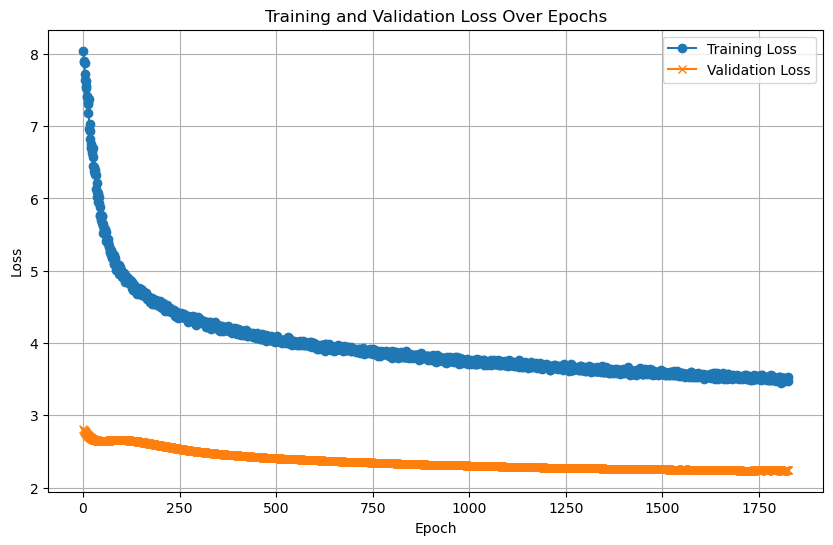

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/210], Loss: 4.7845
Test Batch [20/210], Loss: 4.9980
Test Batch [30/210], Loss: 5.4272
Test Batch [40/210], Loss: 5.4980
Test Batch [50/210], Loss: 4.6673
Test Batch [60/210], Loss: 4.7168
Test Batch [70/210], Loss: 4.8821
Test Batch [80/210], Loss: 5.0698
Test Batch [90/210], Loss: 5.3908
Test Batch [100/210], Loss: 5.3767
Test Batch [110/210], Loss: 5.1101
Test Batch [120/210], Loss: 4.5278
Test Batch [130/210], Loss: 5.0010
Test Batch [140/210], Loss: 4.9275


Test Batch [150/210], Loss: 5.0098
Test Batch [160/210], Loss: 5.0043
Test Batch [170/210], Loss: 4.8645
Test Batch [180/210], Loss: 4.9149
Test Batch [190/210], Loss: 4.8102
Test Batch [200/210], Loss: 4.9774
Test Batch [210/210], Loss: 4.7281

Test Loss: 4.9685


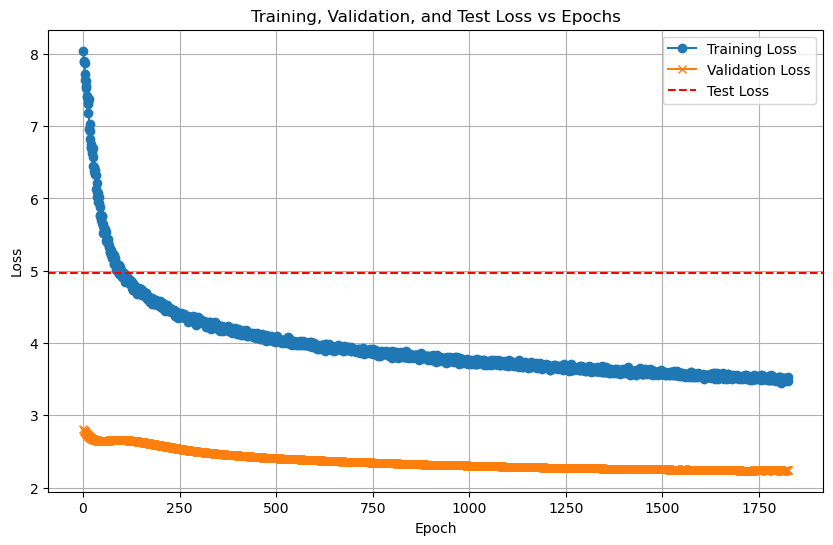

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.


  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.


  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.


  Processed batch 130/210 for test dataset.


  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.


  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       0.83      1.00      0.91         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8315  |  Val Loss: 2.8159
Validation loss improved from inf to 2.8159.
[Epoch 2/1000] Train Loss: 2.7970  |  Val Loss: 2.7828
Validation loss improved from 2.8159 to 2.7828.
[Epoch 3/1000] Train Loss: 2.7656  |  Val Loss: 2.7514
Validation loss improved from 2.7828 to 2.7514.
[Epoch 4/1000] Train Loss: 2.7370  |  Val Loss: 2.7232
Validation loss improved from 2.7514 to 2.7232.
[Epoch 5/1000] Train Loss: 2.7108  |  Val Loss: 2.6983
Validation loss improved from 2.7232 to 2.6983.
[Epoch 6/1000] Train Loss: 2.6866  |  Val Loss: 2.6747
Validation loss improved from 2.6983 to 2.6747.
[Epoch 7/1000] Train Loss: 2.6627  |  Val Loss: 2.6514
Validation loss improved from 2.6747 to 2.6514.
[Epoch 8/1000] Train Loss: 2.6402  |  Val Loss: 2.6277
Validation loss improved from 2.6514 to 2.6277.
[Epoch 9/1000] Train Loss: 2.6164  |  Val Loss: 2.6054
Validation loss improved from 2.6277 to 2.6054.
[Epoch 10/1000] Train Loss: 2.5946  |  Val Loss: 2.5838
Validation loss impr

[Epoch 16/1000] Train Loss: 2.4636  |  Val Loss: 2.4529
Validation loss improved from 2.4744 to 2.4529.
[Epoch 17/1000] Train Loss: 2.4414  |  Val Loss: 2.4291
Validation loss improved from 2.4529 to 2.4291.
[Epoch 18/1000] Train Loss: 2.4168  |  Val Loss: 2.4041
Validation loss improved from 2.4291 to 2.4041.
[Epoch 19/1000] Train Loss: 2.3907  |  Val Loss: 2.3785
Validation loss improved from 2.4041 to 2.3785.
[Epoch 20/1000] Train Loss: 2.3643  |  Val Loss: 2.3528
Validation loss improved from 2.3785 to 2.3528.


[Epoch 21/1000] Train Loss: 2.3375  |  Val Loss: 2.3279
Validation loss improved from 2.3528 to 2.3279.
[Epoch 22/1000] Train Loss: 2.3129  |  Val Loss: 2.3019
Validation loss improved from 2.3279 to 2.3019.
[Epoch 23/1000] Train Loss: 2.2857  |  Val Loss: 2.2764
Validation loss improved from 2.3019 to 2.2764.
[Epoch 24/1000] Train Loss: 2.2592  |  Val Loss: 2.2517
Validation loss improved from 2.2764 to 2.2517.
[Epoch 25/1000] Train Loss: 2.2331  |  Val Loss: 2.2281
Validation loss improved from 2.2517 to 2.2281.
[Epoch 26/1000] Train Loss: 2.2088  |  Val Loss: 2.2050
Validation loss improved from 2.2281 to 2.2050.
[Epoch 27/1000] Train Loss: 2.1844  |  Val Loss: 2.1826
Validation loss improved from 2.2050 to 2.1826.
[Epoch 28/1000] Train Loss: 2.1604  |  Val Loss: 2.1611
Validation loss improved from 2.1826 to 2.1611.
[Epoch 29/1000] Train Loss: 2.1380  |  Val Loss: 2.1401
Validation loss improved from 2.1611 to 2.1401.
[Epoch 30/1000] Train Loss: 2.1147  |  Val Loss: 2.1198
Validati

[Epoch 37/1000] Train Loss: 1.9593  |  Val Loss: 1.9812
Validation loss improved from 2.0009 to 1.9812.
[Epoch 38/1000] Train Loss: 1.9371  |  Val Loss: 1.9613
Validation loss improved from 1.9812 to 1.9613.
[Epoch 39/1000] Train Loss: 1.9141  |  Val Loss: 1.9413
Validation loss improved from 1.9613 to 1.9413.
[Epoch 40/1000] Train Loss: 1.8920  |  Val Loss: 1.9209
Validation loss improved from 1.9413 to 1.9209.


[Epoch 41/1000] Train Loss: 1.8687  |  Val Loss: 1.9009
Validation loss improved from 1.9209 to 1.9009.
[Epoch 42/1000] Train Loss: 1.8465  |  Val Loss: 1.8806
Validation loss improved from 1.9009 to 1.8806.
[Epoch 43/1000] Train Loss: 1.8244  |  Val Loss: 1.8601
Validation loss improved from 1.8806 to 1.8601.
[Epoch 44/1000] Train Loss: 1.8015  |  Val Loss: 1.8389
Validation loss improved from 1.8601 to 1.8389.
[Epoch 45/1000] Train Loss: 1.7785  |  Val Loss: 1.8171
Validation loss improved from 1.8389 to 1.8171.
[Epoch 46/1000] Train Loss: 1.7550  |  Val Loss: 1.7949
Validation loss improved from 1.8171 to 1.7949.
[Epoch 47/1000] Train Loss: 1.7310  |  Val Loss: 1.7725
Validation loss improved from 1.7949 to 1.7725.
[Epoch 48/1000] Train Loss: 1.7068  |  Val Loss: 1.7502
Validation loss improved from 1.7725 to 1.7502.
[Epoch 49/1000] Train Loss: 1.6833  |  Val Loss: 1.7279
Validation loss improved from 1.7502 to 1.7279.
[Epoch 50/1000] Train Loss: 1.6588  |  Val Loss: 1.7061
Validati

[Epoch 56/1000] Train Loss: 1.5245  |  Val Loss: 1.5826
Validation loss improved from 1.6027 to 1.5826.
[Epoch 57/1000] Train Loss: 1.5029  |  Val Loss: 1.5628
Validation loss improved from 1.5826 to 1.5628.
[Epoch 58/1000] Train Loss: 1.4818  |  Val Loss: 1.5431
Validation loss improved from 1.5628 to 1.5431.
[Epoch 59/1000] Train Loss: 1.4604  |  Val Loss: 1.5238
Validation loss improved from 1.5431 to 1.5238.
[Epoch 60/1000] Train Loss: 1.4393  |  Val Loss: 1.5047
Validation loss improved from 1.5238 to 1.5047.
[Epoch 61/1000] Train Loss: 1.4184  |  Val Loss: 1.4855
Validation loss improved from 1.5047 to 1.4855.
[Epoch 62/1000] Train Loss: 1.3976  |  Val Loss: 1.4665
Validation loss improved from 1.4855 to 1.4665.
[Epoch 63/1000] Train Loss: 1.3771  |  Val Loss: 1.4478
Validation loss improved from 1.4665 to 1.4478.
[Epoch 64/1000] Train Loss: 1.3565  |  Val Loss: 1.4292
Validation loss improved from 1.4478 to 1.4292.
[Epoch 65/1000] Train Loss: 1.3363  |  Val Loss: 1.4106
Validati

[Epoch 76/1000] Train Loss: 1.1218  |  Val Loss: 1.2179
Validation loss improved from 1.2344 to 1.2179.
[Epoch 77/1000] Train Loss: 1.1038  |  Val Loss: 1.2016
Validation loss improved from 1.2179 to 1.2016.
[Epoch 78/1000] Train Loss: 1.0857  |  Val Loss: 1.1853
Validation loss improved from 1.2016 to 1.1853.
[Epoch 79/1000] Train Loss: 1.0680  |  Val Loss: 1.1696
Validation loss improved from 1.1853 to 1.1696.
[Epoch 80/1000] Train Loss: 1.0506  |  Val Loss: 1.1539
Validation loss improved from 1.1696 to 1.1539.
[Epoch 81/1000] Train Loss: 1.0329  |  Val Loss: 1.1384
Validation loss improved from 1.1539 to 1.1384.
[Epoch 82/1000] Train Loss: 1.0161  |  Val Loss: 1.1232
Validation loss improved from 1.1384 to 1.1232.
[Epoch 83/1000] Train Loss: 0.9992  |  Val Loss: 1.1079
Validation loss improved from 1.1232 to 1.1079.
[Epoch 84/1000] Train Loss: 0.9827  |  Val Loss: 1.0933
Validation loss improved from 1.1079 to 1.0933.
[Epoch 85/1000] Train Loss: 0.9667  |  Val Loss: 1.0785
Validati

[Epoch 96/1000] Train Loss: 0.8058  |  Val Loss: 0.9352
Validation loss improved from 0.9470 to 0.9352.
[Epoch 97/1000] Train Loss: 0.7928  |  Val Loss: 0.9234
Validation loss improved from 0.9352 to 0.9234.
[Epoch 98/1000] Train Loss: 0.7798  |  Val Loss: 0.9122
Validation loss improved from 0.9234 to 0.9122.
[Epoch 99/1000] Train Loss: 0.7672  |  Val Loss: 0.9013
Validation loss improved from 0.9122 to 0.9013.
[Epoch 100/1000] Train Loss: 0.7548  |  Val Loss: 0.8905
Validation loss improved from 0.9013 to 0.8905.
[Epoch 101/1000] Train Loss: 0.7427  |  Val Loss: 0.8794
Validation loss improved from 0.8905 to 0.8794.
[Epoch 102/1000] Train Loss: 0.7308  |  Val Loss: 0.8693
Validation loss improved from 0.8794 to 0.8693.
[Epoch 103/1000] Train Loss: 0.7190  |  Val Loss: 0.8588
Validation loss improved from 0.8693 to 0.8588.
[Epoch 104/1000] Train Loss: 0.7076  |  Val Loss: 0.8490
Validation loss improved from 0.8588 to 0.8490.
[Epoch 105/1000] Train Loss: 0.6962  |  Val Loss: 0.8387
Va

[Epoch 115/1000] Train Loss: 0.5922  |  Val Loss: 0.7481
Validation loss improved from 0.7562 to 0.7481.
[Epoch 116/1000] Train Loss: 0.5831  |  Val Loss: 0.7401
Validation loss improved from 0.7481 to 0.7401.
[Epoch 117/1000] Train Loss: 0.5740  |  Val Loss: 0.7327
Validation loss improved from 0.7401 to 0.7327.
[Epoch 118/1000] Train Loss: 0.5646  |  Val Loss: 0.7256
Validation loss improved from 0.7327 to 0.7256.
[Epoch 119/1000] Train Loss: 0.5559  |  Val Loss: 0.7181
Validation loss improved from 0.7256 to 0.7181.
[Epoch 120/1000] Train Loss: 0.5470  |  Val Loss: 0.7109
Validation loss improved from 0.7181 to 0.7109.
[Epoch 121/1000] Train Loss: 0.5387  |  Val Loss: 0.7036
Validation loss improved from 0.7109 to 0.7036.
[Epoch 122/1000] Train Loss: 0.5302  |  Val Loss: 0.6975
Validation loss improved from 0.7036 to 0.6975.
[Epoch 123/1000] Train Loss: 0.5221  |  Val Loss: 0.6912
Validation loss improved from 0.6975 to 0.6912.
[Epoch 124/1000] Train Loss: 0.5146  |  Val Loss: 0.684

[Epoch 136/1000] Train Loss: 0.4297  |  Val Loss: 0.6135
Validation loss improved from 0.6189 to 0.6135.
[Epoch 137/1000] Train Loss: 0.4232  |  Val Loss: 0.6082
Validation loss improved from 0.6135 to 0.6082.
[Epoch 138/1000] Train Loss: 0.4171  |  Val Loss: 0.6031
Validation loss improved from 0.6082 to 0.6031.
[Epoch 139/1000] Train Loss: 0.4111  |  Val Loss: 0.5987
Validation loss improved from 0.6031 to 0.5987.
[Epoch 140/1000] Train Loss: 0.4049  |  Val Loss: 0.5935
Validation loss improved from 0.5987 to 0.5935.
[Epoch 141/1000] Train Loss: 0.3992  |  Val Loss: 0.5888
Validation loss improved from 0.5935 to 0.5888.
[Epoch 142/1000] Train Loss: 0.3932  |  Val Loss: 0.5839
Validation loss improved from 0.5888 to 0.5839.
[Epoch 143/1000] Train Loss: 0.3877  |  Val Loss: 0.5792
Validation loss improved from 0.5839 to 0.5792.
[Epoch 144/1000] Train Loss: 0.3821  |  Val Loss: 0.5743
Validation loss improved from 0.5792 to 0.5743.
[Epoch 145/1000] Train Loss: 0.3764  |  Val Loss: 0.569

[Epoch 156/1000] Train Loss: 0.3218  |  Val Loss: 0.5256
Validation loss improved from 0.5292 to 0.5256.
[Epoch 157/1000] Train Loss: 0.3177  |  Val Loss: 0.5213
Validation loss improved from 0.5256 to 0.5213.
[Epoch 158/1000] Train Loss: 0.3131  |  Val Loss: 0.5184
Validation loss improved from 0.5213 to 0.5184.
[Epoch 159/1000] Train Loss: 0.3090  |  Val Loss: 0.5147
Validation loss improved from 0.5184 to 0.5147.
[Epoch 160/1000] Train Loss: 0.3045  |  Val Loss: 0.5110
Validation loss improved from 0.5147 to 0.5110.
[Epoch 161/1000] Train Loss: 0.3006  |  Val Loss: 0.5080
Validation loss improved from 0.5110 to 0.5080.
[Epoch 162/1000] Train Loss: 0.2967  |  Val Loss: 0.5050
Validation loss improved from 0.5080 to 0.5050.
[Epoch 163/1000] Train Loss: 0.2925  |  Val Loss: 0.5018
Validation loss improved from 0.5050 to 0.5018.
[Epoch 164/1000] Train Loss: 0.2885  |  Val Loss: 0.4990
Validation loss improved from 0.5018 to 0.4990.
[Epoch 165/1000] Train Loss: 0.2847  |  Val Loss: 0.495

[Epoch 175/1000] Train Loss: 0.2500  |  Val Loss: 0.4683
Validation loss improved from 0.4708 to 0.4683.
[Epoch 176/1000] Train Loss: 0.2470  |  Val Loss: 0.4658
Validation loss improved from 0.4683 to 0.4658.
[Epoch 177/1000] Train Loss: 0.2440  |  Val Loss: 0.4636
Validation loss improved from 0.4658 to 0.4636.
[Epoch 178/1000] Train Loss: 0.2410  |  Val Loss: 0.4611
Validation loss improved from 0.4636 to 0.4611.
[Epoch 179/1000] Train Loss: 0.2381  |  Val Loss: 0.4583
Validation loss improved from 0.4611 to 0.4583.
[Epoch 180/1000] Train Loss: 0.2351  |  Val Loss: 0.4565
Validation loss improved from 0.4583 to 0.4565.
[Epoch 181/1000] Train Loss: 0.2324  |  Val Loss: 0.4546
Validation loss improved from 0.4565 to 0.4546.
[Epoch 182/1000] Train Loss: 0.2295  |  Val Loss: 0.4527
Validation loss improved from 0.4546 to 0.4527.
[Epoch 183/1000] Train Loss: 0.2269  |  Val Loss: 0.4509
Validation loss improved from 0.4527 to 0.4509.
[Epoch 184/1000] Train Loss: 0.2242  |  Val Loss: 0.448

[Epoch 195/1000] Train Loss: 0.1978  |  Val Loss: 0.4290
Validation loss improved from 0.4307 to 0.4290.
[Epoch 196/1000] Train Loss: 0.1958  |  Val Loss: 0.4273
Validation loss improved from 0.4290 to 0.4273.
[Epoch 197/1000] Train Loss: 0.1938  |  Val Loss: 0.4256
Validation loss improved from 0.4273 to 0.4256.
[Epoch 198/1000] Train Loss: 0.1918  |  Val Loss: 0.4243
Validation loss improved from 0.4256 to 0.4243.
[Epoch 199/1000] Train Loss: 0.1899  |  Val Loss: 0.4238
Validation loss improved from 0.4243 to 0.4238.
[Epoch 200/1000] Train Loss: 0.1877  |  Val Loss: 0.4222
Validation loss improved from 0.4238 to 0.4222.
[Epoch 201/1000] Train Loss: 0.1859  |  Val Loss: 0.4205
Validation loss improved from 0.4222 to 0.4205.
[Epoch 202/1000] Train Loss: 0.1839  |  Val Loss: 0.4192
Validation loss improved from 0.4205 to 0.4192.
[Epoch 203/1000] Train Loss: 0.1820  |  Val Loss: 0.4177
Validation loss improved from 0.4192 to 0.4177.
[Epoch 204/1000] Train Loss: 0.1802  |  Val Loss: 0.416

[Epoch 213/1000] Train Loss: 0.1653  |  Val Loss: 0.4066
Validation loss improved from 0.4081 to 0.4066.
[Epoch 214/1000] Train Loss: 0.1640  |  Val Loss: 0.4054
Validation loss improved from 0.4066 to 0.4054.
[Epoch 215/1000] Train Loss: 0.1624  |  Val Loss: 0.4051
Validation loss improved from 0.4054 to 0.4051.
[Epoch 216/1000] Train Loss: 0.1609  |  Val Loss: 0.4042
Validation loss improved from 0.4051 to 0.4042.
[Epoch 217/1000] Train Loss: 0.1595  |  Val Loss: 0.4034
Validation loss improved from 0.4042 to 0.4034.
[Epoch 218/1000] Train Loss: 0.1580  |  Val Loss: 0.4028
Validation loss improved from 0.4034 to 0.4028.
[Epoch 219/1000] Train Loss: 0.1566  |  Val Loss: 0.4017
Validation loss improved from 0.4028 to 0.4017.
[Epoch 220/1000] Train Loss: 0.1552  |  Val Loss: 0.4006
Validation loss improved from 0.4017 to 0.4006.
[Epoch 221/1000] Train Loss: 0.1539  |  Val Loss: 0.3999
Validation loss improved from 0.4006 to 0.3999.
[Epoch 222/1000] Train Loss: 0.1526  |  Val Loss: 0.398

[Epoch 231/1000] Train Loss: 0.1419  |  Val Loss: 0.3925
Validation loss improved from 0.3929 to 0.3925.
[Epoch 232/1000] Train Loss: 0.1407  |  Val Loss: 0.3928
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.1397  |  Val Loss: 0.3931
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 234/1000] Train Loss: 0.1387  |  Val Loss: 0.3922
Validation loss improved from 0.3925 to 0.3922.
[Epoch 235/1000] Train Loss: 0.1374  |  Val Loss: 0.3913
Validation loss improved from 0.3922 to 0.3913.
[Epoch 236/1000] Train Loss: 0.1366  |  Val Loss: 0.3904
Validation loss improved from 0.3913 to 0.3904.
[Epoch 237/1000] Train Loss: 0.1357  |  Val Loss: 0.3900
Validation loss improved from 0.3904 to 0.3900.
[Epoch 238/1000] Train Loss: 0.1345  |  Val Loss: 0.3894
Validation loss improved from 0.3900 to 0.3894.
[Epoch 239/1000] Train Loss: 0.1336  |  Val Loss: 0.3885
Validation loss improved from 0.3894 to 0.3885.
[Epoch 240/1000] Train Loss: 0.1325  |  Val

[Epoch 250/1000] Train Loss: 0.1237  |  Val Loss: 0.3855
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 0.1229  |  Val Loss: 0.3857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 252/1000] Train Loss: 0.1222  |  Val Loss: 0.3856
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 253/1000] Train Loss: 0.1221  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 254/1000] Train Loss: 0.1207  |  Val Loss: 0.3849
Validation loss improved from 0.3854 to 0.3849.
[Epoch 255/1000] Train Loss: 0.1199  |  Val Loss: 0.3846
Validation loss improved from 0.3849 to 0.3846.
[Epoch 256/1000] Train Loss: 0.1192  |  Val Loss: 0.3839
Validation loss improved from 0.3846 to 0.3839.
[Epoch 257/1000] Train Loss: 0.1185  |  Val Loss: 0.3833
Validation loss improved from 0.3839 to 0.3833.
[Epoch 258/1000] Train Loss: 0.1180  |  Val Loss: 0.3836
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 259/1000] Train Lo

[Epoch 269/1000] Train Loss: 0.1107  |  Val Loss: 0.3826
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 270/1000] Train Loss: 0.1098  |  Val Loss: 0.3824
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 271/1000] Train Loss: 0.1093  |  Val Loss: 0.3819
Validation loss improved from 0.3820 to 0.3819.
[Epoch 272/1000] Train Loss: 0.1087  |  Val Loss: 0.3821
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 273/1000] Train Loss: 0.1080  |  Val Loss: 0.3819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 274/1000] Train Loss: 0.1077  |  Val Loss: 0.3816
Validation loss improved from 0.3819 to 0.3816.
[Epoch 275/1000] Train Loss: 0.1071  |  Val Loss: 0.3811
Validation loss improved from 0.3816 to 0.3811.
[Epoch 276/1000] Train Loss: 0.1067  |  Val Loss: 0.3811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 277/1000] Train Loss: 0.1058  |  Val Loss: 0.3814
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 278/1000] Tr

[Epoch 286/1000] Train Loss: 0.1016  |  Val Loss: 0.3813
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 287/1000] Train Loss: 0.1008  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 288/1000] Train Loss: 0.1004  |  Val Loss: 0.3817
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 289/1000] Train Loss: 0.0999  |  Val Loss: 0.3818
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 290/1000] Train Loss: 0.0997  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 291/1000] Train Loss: 0.0989  |  Val Loss: 0.3817
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 292/1000] Train Loss: 0.0986  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 293/1000] Train Loss: 0.0981  |  Val Loss: 0.3819
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 294/1000] Train Loss: 0.0977  |  Val Loss: 0.3822
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 306/1000] Train Loss: 0.0928  |  Val Loss: 0.3829
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 307/1000] Train Loss: 0.0925  |  Val Loss: 0.3827
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 308/1000] Train Loss: 0.0925  |  Val Loss: 0.3833
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 309/1000] Train Loss: 0.0923  |  Val Loss: 0.3828
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 310/1000] Train Loss: 0.0915  |  Val Loss: 0.3835
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 311/1000] Train Loss: 0.0913  |  Val Loss: 0.3831
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 312/1000] Train Loss: 0.0913  |  Val Loss: 0.3840
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 313/1000] Train Loss: 0.0906  |  Val Loss: 0.3840
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 314/1000] Train Loss: 0.0903  |  Val Loss: 0.3828
!! Validation loss did NOT improve !! Patience:

[Epoch 325/1000] Train Loss: 0.0866  |  Val Loss: 0.3856
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 326/1000] Train Loss: 0.0861  |  Val Loss: 0.3856
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 327/1000] Train Loss: 0.0859  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 328/1000] Train Loss: 0.0854  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 329/1000] Train Loss: 0.0852  |  Val Loss: 0.3850
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 330/1000] Train Loss: 0.0857  |  Val Loss: 0.3843
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 331/1000] Train Loss: 0.0853  |  Val Loss: 0.3854
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 332/1000] Train Loss: 0.0845  |  Val Loss: 0.3860
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 333/1000] Train Loss: 0.0841  |  Val Loss: 0.3869
!! Validation loss did NOT improve !! Patience:

[Epoch 346/1000] Train Loss: 0.0806  |  Val Loss: 0.3884
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 347/1000] Train Loss: 0.0802  |  Val Loss: 0.3894
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 348/1000] Train Loss: 0.0800  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 349/1000] Train Loss: 0.0795  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 350/1000] Train Loss: 0.0796  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 351/1000] Train Loss: 0.0792  |  Val Loss: 0.3891
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 352/1000] Train Loss: 0.0790  |  Val Loss: 0.3896
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 353/1000] Train Loss: 0.0787  |  Val Loss: 0.3897
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 354/1000] Train Loss: 0.0798  |  Val Loss: 0.3910
!! Validation loss did NOT improve !! Patience:

[Epoch 366/1000] Train Loss: 0.0758  |  Val Loss: 0.3927
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 367/1000] Train Loss: 0.0761  |  Val Loss: 0.3930
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 368/1000] Train Loss: 0.0755  |  Val Loss: 0.3935
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 369/1000] Train Loss: 0.0756  |  Val Loss: 0.3944
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 370/1000] Train Loss: 0.0752  |  Val Loss: 0.3943
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 371/1000] Train Loss: 0.0749  |  Val Loss: 0.3941
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 372/1000] Train Loss: 0.0748  |  Val Loss: 0.3949
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 373/1000] Train Loss: 0.0744  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 374/1000] Train Loss: 0.0742  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience:

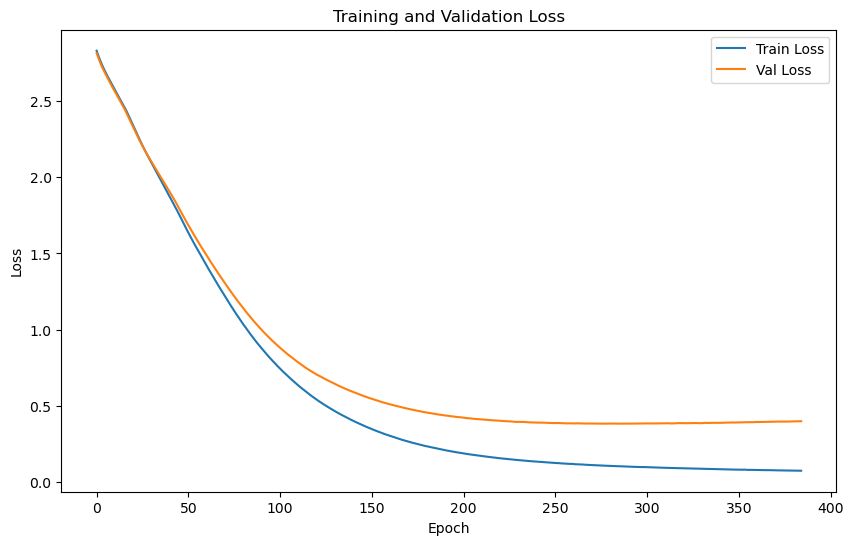

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6127 | Test Accuracy: 83.23%


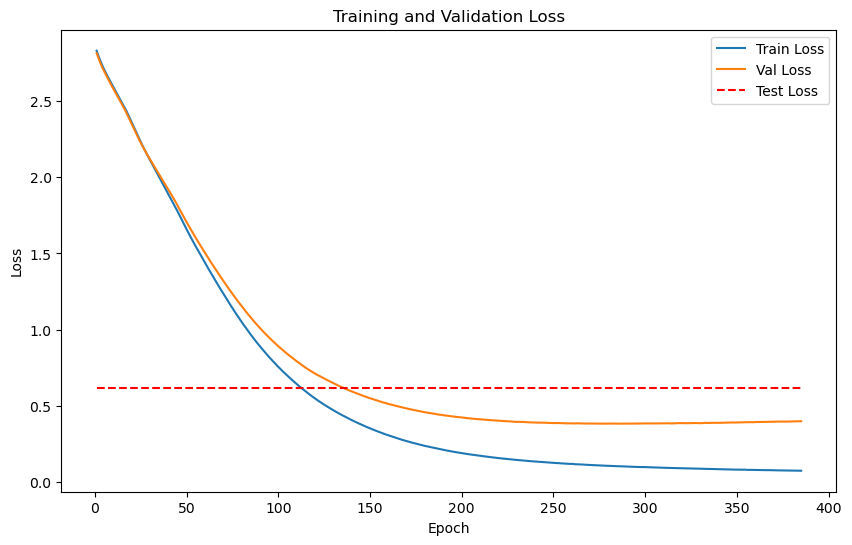

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.3807
Epoch [1/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.3383

Validation loss improved from inf to 0.3383. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.2968
    Batch [2/2], Val Loss: 0.3789
Epoch [2/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.3379

Validation loss improved from 0.3383 to 0.3379. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.3781
Epoch [3/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3378

Validation loss improved from 0.3379 to 0.3378. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.2987
    Batch [2/2], Val Loss: 0.3772
Epoch [4/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.3767
Epoch [5/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.3768
Epoch [6/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3012
    Batch [2/2], Val Loss: 0.3771
Epoch [7/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3010
    Batch [2/2], Val Loss: 0.3770
Epoch [8/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.3766
Epoch [9/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3024
    Batch [2/2], Val Loss: 0.3759
Epoch [10/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.3742
Epoch [11/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3037
    Batch [2/2], Val Loss: 0.3738
Epoch [12/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3042
    Batch [2/2], Val Loss: 0.3723
Epoch [13/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3044
    Batch [2/2], Val Loss: 0.3694
Epoch [14/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.3369

Validation loss improved from 0.3378 to 0.3369. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.3663
Epoch [15/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3352

Validation loss improved from 0.3369 to 0.3352. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.3633
Epoch [16/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.3336

Validation loss improved from 0.3352 to 0.3336. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3033
    Batch [2/2], Val Loss: 0.3603
Epoch [17/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3318

Validation loss improved from 0.3336 to 0.3318. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3023
    Batch [2/2], Val Loss: 0.3576
Epoch [18/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3300

Validation loss improved from 0.3318 to 0.3300. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.3557
Epoch [19/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3284

Validation loss improved from 0.3300 to 0.3284. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.3540
Epoch [20/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.3269

Validation loss improved from 0.3284 to 0.3269. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.3524
Epoch [21/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3254

Validation loss improved from 0.3269 to 0.3254. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.3509
Epoch [22/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.3242

Validation loss improved from 0.3254 to 0.3242. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.3499
Epoch [23/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3232

Validation loss improved from 0.3242 to 0.3232. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.3489
Epoch [24/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3222

Validation loss improved from 0.3232 to 0.3222. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.3479
Epoch [25/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3212

Validation loss improved from 0.3222 to 0.3212. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.3471
Epoch [26/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3203

Validation loss improved from 0.3212 to 0.3203. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.3462
Epoch [27/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3195

Validation loss improved from 0.3203 to 0.3195. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.3453
Epoch [28/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3186

Validation loss improved from 0.3195 to 0.3186. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.2912
    Batch [2/2], Val Loss: 0.3444
Epoch [29/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3178

Validation loss improved from 0.3186 to 0.3178. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2905
    Batch [2/2], Val Loss: 0.3435
Epoch [30/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3170

Validation loss improved from 0.3178 to 0.3170. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2898
    Batch [2/2], Val Loss: 0.3427
Epoch [31/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3163

Validation loss improved from 0.3170 to 0.3163. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.3417
Epoch [32/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3155

Validation loss improved from 0.3163 to 0.3155. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.3407
Epoch [33/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3147

Validation loss improved from 0.3155 to 0.3147. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.3397
Epoch [34/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3139

Validation loss improved from 0.3147 to 0.3139. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2874
    Batch [2/2], Val Loss: 0.3387
Epoch [35/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.3131

Validation loss improved from 0.3139 to 0.3131. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2868
    Batch [2/2], Val Loss: 0.3377
Epoch [36/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3123

Validation loss improved from 0.3131 to 0.3123. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2862
    Batch [2/2], Val Loss: 0.3368
Epoch [37/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3115

Validation loss improved from 0.3123 to 0.3115. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2856
    Batch [2/2], Val Loss: 0.3357
Epoch [38/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3106

Validation loss improved from 0.3115 to 0.3106. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.3346
Epoch [39/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3098

Validation loss improved from 0.3106 to 0.3098. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2844
    Batch [2/2], Val Loss: 0.3335
Epoch [40/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3089

Validation loss improved from 0.3098 to 0.3089. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.3324
Epoch [41/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3081

Validation loss improved from 0.3089 to 0.3081. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.3312
Epoch [42/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3072

Validation loss improved from 0.3081 to 0.3072. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2825
    Batch [2/2], Val Loss: 0.3300
Epoch [43/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3063

Validation loss improved from 0.3072 to 0.3063. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.3289
Epoch [44/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3054

Validation loss improved from 0.3063 to 0.3054. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2813
    Batch [2/2], Val Loss: 0.3277
Epoch [45/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3045

Validation loss improved from 0.3054 to 0.3045. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.3265
Epoch [46/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3036

Validation loss improved from 0.3045 to 0.3036. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.3254
Epoch [47/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3027

Validation loss improved from 0.3036 to 0.3027. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.3241
Epoch [48/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3018

Validation loss improved from 0.3027 to 0.3018. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2790
    Batch [2/2], Val Loss: 0.3229
Epoch [49/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3009

Validation loss improved from 0.3018 to 0.3009. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.3216
Epoch [50/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3000

Validation loss improved from 0.3009 to 0.3000. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.3203
Epoch [51/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2991

Validation loss improved from 0.3000 to 0.2991. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2774
    Batch [2/2], Val Loss: 0.3192
Epoch [52/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2983

Validation loss improved from 0.2991 to 0.2983. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.3180
Epoch [53/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2975

Validation loss improved from 0.2983 to 0.2975. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.3168
Epoch [54/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2966

Validation loss improved from 0.2975 to 0.2966. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.3157
Epoch [55/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2958

Validation loss improved from 0.2966 to 0.2958. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.3145
Epoch [56/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2950

Validation loss improved from 0.2958 to 0.2950. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.3134
Epoch [57/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2942

Validation loss improved from 0.2950 to 0.2942. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.3122
Epoch [58/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2933

Validation loss improved from 0.2942 to 0.2933. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.3110
Epoch [59/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2925

Validation loss improved from 0.2933 to 0.2925. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.3099
Epoch [60/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2916

Validation loss improved from 0.2925 to 0.2916. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.3088
Epoch [61/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2908

Validation loss improved from 0.2916 to 0.2908. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2723
    Batch [2/2], Val Loss: 0.3078
Epoch [62/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2901

Validation loss improved from 0.2908 to 0.2901. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2718
    Batch [2/2], Val Loss: 0.3068
Epoch [63/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2893

Validation loss improved from 0.2901 to 0.2893. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2713
    Batch [2/2], Val Loss: 0.3057
Epoch [64/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2885

Validation loss improved from 0.2893 to 0.2885. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.3047
Epoch [65/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2878

Validation loss improved from 0.2885 to 0.2878. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2704
    Batch [2/2], Val Loss: 0.3038
Epoch [66/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2871

Validation loss improved from 0.2878 to 0.2871. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.3029
Epoch [67/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2864

Validation loss improved from 0.2871 to 0.2864. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.3020
Epoch [68/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2858

Validation loss improved from 0.2864 to 0.2858. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.3011
Epoch [69/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2852

Validation loss improved from 0.2858 to 0.2852. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.3003
Epoch [70/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2845

Validation loss improved from 0.2852 to 0.2845. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.2994
Epoch [71/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2839

Validation loss improved from 0.2845 to 0.2839. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2679
    Batch [2/2], Val Loss: 0.2986
Epoch [72/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2833

Validation loss improved from 0.2839 to 0.2833. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2676
    Batch [2/2], Val Loss: 0.2977
Epoch [73/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2826

Validation loss improved from 0.2833 to 0.2826. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.2969
Epoch [74/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2820

Validation loss improved from 0.2826 to 0.2820. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.2960
Epoch [75/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2814

Validation loss improved from 0.2820 to 0.2814. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2664
    Batch [2/2], Val Loss: 0.2951
Epoch [76/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2808

Validation loss improved from 0.2814 to 0.2808. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.2943
Epoch [77/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2801

Validation loss improved from 0.2808 to 0.2801. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.2934
Epoch [78/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2795

Validation loss improved from 0.2801 to 0.2795. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2651
    Batch [2/2], Val Loss: 0.2925
Epoch [79/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2788

Validation loss improved from 0.2795 to 0.2788. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.2916
Epoch [80/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2781

Validation loss improved from 0.2788 to 0.2781. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.2907
Epoch [81/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2775

Validation loss improved from 0.2781 to 0.2775. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2898
Epoch [82/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2768

Validation loss improved from 0.2775 to 0.2768. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2634
    Batch [2/2], Val Loss: 0.2890
Epoch [83/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2762

Validation loss improved from 0.2768 to 0.2762. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2629
    Batch [2/2], Val Loss: 0.2881
Epoch [84/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2755

Validation loss improved from 0.2762 to 0.2755. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.2873
Epoch [85/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.2749

Validation loss improved from 0.2755 to 0.2749. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2621
    Batch [2/2], Val Loss: 0.2865
Epoch [86/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2743

Validation loss improved from 0.2749 to 0.2743. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.2856
Epoch [87/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2736

Validation loss improved from 0.2743 to 0.2736. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.2848
Epoch [88/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2730

Validation loss improved from 0.2736 to 0.2730. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.2840
Epoch [89/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2724

Validation loss improved from 0.2730 to 0.2724. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.2831
Epoch [90/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2717

Validation loss improved from 0.2724 to 0.2717. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.2823
Epoch [91/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2711

Validation loss improved from 0.2717 to 0.2711. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.2815
Epoch [92/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2705

Validation loss improved from 0.2711 to 0.2705. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2591
    Batch [2/2], Val Loss: 0.2807
Epoch [93/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2699

Validation loss improved from 0.2705 to 0.2699. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.2799
Epoch [94/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2693

Validation loss improved from 0.2699 to 0.2693. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.2792
Epoch [95/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2687

Validation loss improved from 0.2693 to 0.2687. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2578
    Batch [2/2], Val Loss: 0.2785
Epoch [96/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2682

Validation loss improved from 0.2687 to 0.2682. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2574
    Batch [2/2], Val Loss: 0.2778
Epoch [97/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2676

Validation loss improved from 0.2682 to 0.2676. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2773
Epoch [98/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2671

Validation loss improved from 0.2676 to 0.2671. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2566
    Batch [2/2], Val Loss: 0.2767
Epoch [99/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2666

Validation loss improved from 0.2671 to 0.2666. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.2761
Epoch [100/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2661

Validation loss improved from 0.2666 to 0.2661. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.2755
Epoch [101/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2656

Validation loss improved from 0.2661 to 0.2656. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.2749
Epoch [102/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2651

Validation loss improved from 0.2656 to 0.2651. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.2742
Epoch [103/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2646

Validation loss improved from 0.2651 to 0.2646. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.2736
Epoch [104/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2641

Validation loss improved from 0.2646 to 0.2641. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2543
    Batch [2/2], Val Loss: 0.2730
Epoch [105/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2637

Validation loss improved from 0.2641 to 0.2637. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.2724
Epoch [106/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2632

Validation loss improved from 0.2637 to 0.2632. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.2718
Epoch [107/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2627

Validation loss improved from 0.2632 to 0.2627. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2533
    Batch [2/2], Val Loss: 0.2712
Epoch [108/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2622

Validation loss improved from 0.2627 to 0.2622. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.2707
Epoch [109/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2618

Validation loss improved from 0.2622 to 0.2618. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.2702
Epoch [110/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2614

Validation loss improved from 0.2618 to 0.2614. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.2696
Epoch [111/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2609

Validation loss improved from 0.2614 to 0.2609. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.2691
Epoch [112/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2605

Validation loss improved from 0.2609 to 0.2605. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.2686
Epoch [113/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2601

Validation loss improved from 0.2605 to 0.2601. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.2681
Epoch [114/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2597

Validation loss improved from 0.2601 to 0.2597. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2676
Epoch [115/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2592

Validation loss improved from 0.2597 to 0.2592. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2670
Epoch [116/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2588

Validation loss improved from 0.2592 to 0.2588. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.2663
Epoch [117/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2583

Validation loss improved from 0.2588 to 0.2583. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.2657
Epoch [118/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2578

Validation loss improved from 0.2583 to 0.2578. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.2650
Epoch [119/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2573

Validation loss improved from 0.2578 to 0.2573. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2493
    Batch [2/2], Val Loss: 0.2643
Epoch [120/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2568

Validation loss improved from 0.2573 to 0.2568. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.2636
Epoch [121/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2563

Validation loss improved from 0.2568 to 0.2563. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.2629
Epoch [122/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2558

Validation loss improved from 0.2563 to 0.2558. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.2622
Epoch [123/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2554

Validation loss improved from 0.2558 to 0.2554. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.2616
Epoch [124/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2549

Validation loss improved from 0.2554 to 0.2549. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2609
Epoch [125/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2544

Validation loss improved from 0.2549 to 0.2544. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.2604
Epoch [126/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2540

Validation loss improved from 0.2544 to 0.2540. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2598
Epoch [127/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2536

Validation loss improved from 0.2540 to 0.2536. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2471
    Batch [2/2], Val Loss: 0.2592
Epoch [128/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2532

Validation loss improved from 0.2536 to 0.2532. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2468
    Batch [2/2], Val Loss: 0.2586
Epoch [129/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2527

Validation loss improved from 0.2532 to 0.2527. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2466
    Batch [2/2], Val Loss: 0.2581
Epoch [130/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2523

Validation loss improved from 0.2527 to 0.2523. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2463
    Batch [2/2], Val Loss: 0.2575
Epoch [131/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2519

Validation loss improved from 0.2523 to 0.2519. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2460
    Batch [2/2], Val Loss: 0.2570
Epoch [132/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2515

Validation loss improved from 0.2519 to 0.2515. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2457
    Batch [2/2], Val Loss: 0.2564
Epoch [133/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2511

Validation loss improved from 0.2515 to 0.2511. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.2558
Epoch [134/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2507

Validation loss improved from 0.2511 to 0.2507. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2452
    Batch [2/2], Val Loss: 0.2553
Epoch [135/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2503

Validation loss improved from 0.2507 to 0.2503. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2450
    Batch [2/2], Val Loss: 0.2547
Epoch [136/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2499

Validation loss improved from 0.2503 to 0.2499. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.2542
Epoch [137/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2495

Validation loss improved from 0.2499 to 0.2495. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2445
    Batch [2/2], Val Loss: 0.2536
Epoch [138/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2491

Validation loss improved from 0.2495 to 0.2491. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.2530
Epoch [139/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2486

Validation loss improved from 0.2491 to 0.2486. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.2523
Epoch [140/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2482

Validation loss improved from 0.2486 to 0.2482. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.2515
Epoch [141/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2477

Validation loss improved from 0.2482 to 0.2477. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2436
    Batch [2/2], Val Loss: 0.2508
Epoch [142/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2472

Validation loss improved from 0.2477 to 0.2472. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2434
    Batch [2/2], Val Loss: 0.2501
Epoch [143/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2468

Validation loss improved from 0.2472 to 0.2468. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2432
    Batch [2/2], Val Loss: 0.2495
Epoch [144/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2463

Validation loss improved from 0.2468 to 0.2463. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.2488
Epoch [145/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2459

Validation loss improved from 0.2463 to 0.2459. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2428
    Batch [2/2], Val Loss: 0.2481
Epoch [146/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2455

Validation loss improved from 0.2459 to 0.2455. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2426
    Batch [2/2], Val Loss: 0.2475
Epoch [147/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2451

Validation loss improved from 0.2455 to 0.2451. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2424
    Batch [2/2], Val Loss: 0.2469
Epoch [148/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2446

Validation loss improved from 0.2451 to 0.2446. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2422
    Batch [2/2], Val Loss: 0.2463
Epoch [149/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2442

Validation loss improved from 0.2446 to 0.2442. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2420
    Batch [2/2], Val Loss: 0.2457
Epoch [150/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2438

Validation loss improved from 0.2442 to 0.2438. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2417
    Batch [2/2], Val Loss: 0.2451
Epoch [151/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2434

Validation loss improved from 0.2438 to 0.2434. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2415
    Batch [2/2], Val Loss: 0.2444
Epoch [152/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2429

Validation loss improved from 0.2434 to 0.2429. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2412
    Batch [2/2], Val Loss: 0.2436
Epoch [153/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2424

Validation loss improved from 0.2429 to 0.2424. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2410
    Batch [2/2], Val Loss: 0.2429
Epoch [154/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2420

Validation loss improved from 0.2424 to 0.2420. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2408
    Batch [2/2], Val Loss: 0.2423
Epoch [155/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2416

Validation loss improved from 0.2420 to 0.2416. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2406
    Batch [2/2], Val Loss: 0.2417
Epoch [156/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2412

Validation loss improved from 0.2416 to 0.2412. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.2412
Epoch [157/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2408

Validation loss improved from 0.2412 to 0.2408. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2401
    Batch [2/2], Val Loss: 0.2405
Epoch [158/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2403

Validation loss improved from 0.2408 to 0.2403. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2399
    Batch [2/2], Val Loss: 0.2399
Epoch [159/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2399

Validation loss improved from 0.2403 to 0.2399. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.2394
Epoch [160/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2395

Validation loss improved from 0.2399 to 0.2395. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2395
    Batch [2/2], Val Loss: 0.2389
Epoch [161/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2392

Validation loss improved from 0.2395 to 0.2392. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2393
    Batch [2/2], Val Loss: 0.2383
Epoch [162/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2388

Validation loss improved from 0.2392 to 0.2388. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2391
    Batch [2/2], Val Loss: 0.2377
Epoch [163/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2384

Validation loss improved from 0.2388 to 0.2384. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2389
    Batch [2/2], Val Loss: 0.2372
Epoch [164/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2380

Validation loss improved from 0.2384 to 0.2380. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2386
    Batch [2/2], Val Loss: 0.2366
Epoch [165/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2376

Validation loss improved from 0.2380 to 0.2376. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2384
    Batch [2/2], Val Loss: 0.2361
Epoch [166/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2372

Validation loss improved from 0.2376 to 0.2372. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2382
    Batch [2/2], Val Loss: 0.2355
Epoch [167/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2369

Validation loss improved from 0.2372 to 0.2369. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2349
Epoch [168/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2364

Validation loss improved from 0.2369 to 0.2364. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2378
    Batch [2/2], Val Loss: 0.2343
Epoch [169/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2361

Validation loss improved from 0.2364 to 0.2361. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.2337
Epoch [170/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2357

Validation loss improved from 0.2361 to 0.2357. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.2331
Epoch [171/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2353

Validation loss improved from 0.2357 to 0.2353. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.2325
Epoch [172/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2349

Validation loss improved from 0.2353 to 0.2349. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.2320
Epoch [173/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2345

Validation loss improved from 0.2349 to 0.2345. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.2315
Epoch [174/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2342

Validation loss improved from 0.2345 to 0.2342. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.2310
Epoch [175/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2339

Validation loss improved from 0.2342 to 0.2339. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.2307
Epoch [176/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2336

Validation loss improved from 0.2339 to 0.2336. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.2302
Epoch [177/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2333

Validation loss improved from 0.2336 to 0.2333. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.2298
Epoch [178/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2330

Validation loss improved from 0.2333 to 0.2330. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2360
    Batch [2/2], Val Loss: 0.2293
Epoch [179/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2326

Validation loss improved from 0.2330 to 0.2326. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2359
    Batch [2/2], Val Loss: 0.2289
Epoch [180/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2324

Validation loss improved from 0.2326 to 0.2324. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.2285
Epoch [181/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2321

Validation loss improved from 0.2324 to 0.2321. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2356
    Batch [2/2], Val Loss: 0.2282
Epoch [182/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2319

Validation loss improved from 0.2321 to 0.2319. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2354
    Batch [2/2], Val Loss: 0.2278
Epoch [183/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2316

Validation loss improved from 0.2319 to 0.2316. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.2273
Epoch [184/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.2313

Validation loss improved from 0.2316 to 0.2313. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2350
    Batch [2/2], Val Loss: 0.2268
Epoch [185/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2309

Validation loss improved from 0.2313 to 0.2309. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2349
    Batch [2/2], Val Loss: 0.2263
Epoch [186/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2306

Validation loss improved from 0.2309 to 0.2306. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2347
    Batch [2/2], Val Loss: 0.2258
Epoch [187/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2302

Validation loss improved from 0.2306 to 0.2302. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2345
    Batch [2/2], Val Loss: 0.2252
Epoch [188/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2298

Validation loss improved from 0.2302 to 0.2298. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.2246
Epoch [189/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2295

Validation loss improved from 0.2298 to 0.2295. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.2241
Epoch [190/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2291

Validation loss improved from 0.2295 to 0.2291. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2339
    Batch [2/2], Val Loss: 0.2236
Epoch [191/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2287

Validation loss improved from 0.2291 to 0.2287. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.2231
Epoch [192/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2284

Validation loss improved from 0.2287 to 0.2284. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.2227
Epoch [193/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2281

Validation loss improved from 0.2284 to 0.2281. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2334
    Batch [2/2], Val Loss: 0.2223
Epoch [194/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2278

Validation loss improved from 0.2281 to 0.2278. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2333
    Batch [2/2], Val Loss: 0.2219
Epoch [195/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2276

Validation loss improved from 0.2278 to 0.2276. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2331
    Batch [2/2], Val Loss: 0.2215
Epoch [196/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2273

Validation loss improved from 0.2276 to 0.2273. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.2210
Epoch [197/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2270

Validation loss improved from 0.2273 to 0.2270. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.2206
Epoch [198/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2267

Validation loss improved from 0.2270 to 0.2267. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.2201
Epoch [199/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2264

Validation loss improved from 0.2267 to 0.2264. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.2198
Epoch [200/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2261

Validation loss improved from 0.2264 to 0.2261. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.2194
Epoch [201/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.2191
Epoch [202/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2257

Validation loss improved from 0.2259 to 0.2257. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.2189
Epoch [203/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2255

Validation loss improved from 0.2257 to 0.2255. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.2186
Epoch [204/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2252

Validation loss improved from 0.2255 to 0.2252. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2317
    Batch [2/2], Val Loss: 0.2184
Epoch [205/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2251

Validation loss improved from 0.2252 to 0.2251. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.2182
Epoch [206/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2249

Validation loss improved from 0.2251 to 0.2249. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.2179
Epoch [207/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2247

Validation loss improved from 0.2249 to 0.2247. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.2176
Epoch [208/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2245

Validation loss improved from 0.2247 to 0.2245. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.2173
Epoch [209/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2243

Validation loss improved from 0.2245 to 0.2243. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.2169
Epoch [210/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2241

Validation loss improved from 0.2243 to 0.2241. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2311
    Batch [2/2], Val Loss: 0.2166
Epoch [211/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.2163
Epoch [212/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2309
    Batch [2/2], Val Loss: 0.2161
Epoch [213/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2235

Validation loss improved from 0.2237 to 0.2235. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.2158
Epoch [214/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2233

Validation loss improved from 0.2235 to 0.2233. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.2156
Epoch [215/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2307
    Batch [2/2], Val Loss: 0.2155
Epoch [216/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.2152
Epoch [217/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.2150
Epoch [218/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2227

Validation loss improved from 0.2229 to 0.2227. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.2147
Epoch [219/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2304
    Batch [2/2], Val Loss: 0.2144
Epoch [220/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2224

Validation loss improved from 0.2226 to 0.2224. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.2142
Epoch [221/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2222

Validation loss improved from 0.2224 to 0.2222. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2301
    Batch [2/2], Val Loss: 0.2139
Epoch [222/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2220

Validation loss improved from 0.2222 to 0.2220. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2300
    Batch [2/2], Val Loss: 0.2136
Epoch [223/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2218

Validation loss improved from 0.2220 to 0.2218. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2298
    Batch [2/2], Val Loss: 0.2132
Epoch [224/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2215

Validation loss improved from 0.2218 to 0.2215. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.2129
Epoch [225/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2213

Validation loss improved from 0.2215 to 0.2213. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.2126
Epoch [226/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2211

Validation loss improved from 0.2213 to 0.2211. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.2124
Epoch [227/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2210

Validation loss improved from 0.2211 to 0.2210. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.2122
Epoch [228/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2209

Validation loss improved from 0.2210 to 0.2209. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2120
Epoch [229/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2207

Validation loss improved from 0.2209 to 0.2207. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.2118
Epoch [230/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2206

Validation loss improved from 0.2207 to 0.2206. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.2116
Epoch [231/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2204

Validation loss improved from 0.2206 to 0.2204. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.2114
Epoch [232/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2202

Validation loss improved from 0.2204 to 0.2202. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.2111
Epoch [233/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2201

Validation loss improved from 0.2202 to 0.2201. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.2110
Epoch [234/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.2200

Validation loss improved from 0.2201 to 0.2200. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.2109
Epoch [235/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2198

Validation loss improved from 0.2200 to 0.2198. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.2107
Epoch [236/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2197

Validation loss improved from 0.2198 to 0.2197. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.2106
Epoch [237/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2196

Validation loss improved from 0.2197 to 0.2196. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.2105
Epoch [238/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2195

Validation loss improved from 0.2196 to 0.2195. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.2102
Epoch [239/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2100
Epoch [240/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2192

Validation loss improved from 0.2194 to 0.2192. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2097
Epoch [241/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2190

Validation loss improved from 0.2192 to 0.2190. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.2094
Epoch [242/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2189

Validation loss improved from 0.2190 to 0.2189. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.2090
Epoch [243/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2186

Validation loss improved from 0.2189 to 0.2186. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.2086
Epoch [244/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2184

Validation loss improved from 0.2186 to 0.2184. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.2083
Epoch [245/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2182

Validation loss improved from 0.2184 to 0.2182. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.2080
Epoch [246/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2180

Validation loss improved from 0.2182 to 0.2180. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.2076
Epoch [247/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.2178

Validation loss improved from 0.2180 to 0.2178. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.2073
Epoch [248/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2175

Validation loss improved from 0.2178 to 0.2175. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.2069
Epoch [249/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2173

Validation loss improved from 0.2175 to 0.2173. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.2065
Epoch [250/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2170

Validation loss improved from 0.2173 to 0.2170. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.2062
Epoch [251/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2168

Validation loss improved from 0.2170 to 0.2168. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.2060
Epoch [252/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2166

Validation loss improved from 0.2168 to 0.2166. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.2058
Epoch [253/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2164

Validation loss improved from 0.2166 to 0.2164. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.2055
Epoch [254/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2162

Validation loss improved from 0.2164 to 0.2162. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.2052
Epoch [255/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2160

Validation loss improved from 0.2162 to 0.2160. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.2049
Epoch [256/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2157

Validation loss improved from 0.2160 to 0.2157. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.2045
Epoch [257/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2155

Validation loss improved from 0.2157 to 0.2155. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.2042
Epoch [258/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2152

Validation loss improved from 0.2155 to 0.2152. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.2039
Epoch [259/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.2037
Epoch [260/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2148

Validation loss improved from 0.2150 to 0.2148. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2258
    Batch [2/2], Val Loss: 0.2036
Epoch [261/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2147

Validation loss improved from 0.2148 to 0.2147. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2035
Epoch [262/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2146

Validation loss improved from 0.2147 to 0.2146. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2033
Epoch [263/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2145

Validation loss improved from 0.2146 to 0.2145. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2032
Epoch [264/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2144

Validation loss improved from 0.2145 to 0.2144. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.2030
Epoch [265/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.2143

Validation loss improved from 0.2144 to 0.2143. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.2027
Epoch [266/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2141

Validation loss improved from 0.2143 to 0.2141. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.2025
Epoch [267/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2140

Validation loss improved from 0.2141 to 0.2140. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.2023
Epoch [268/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2138

Validation loss improved from 0.2140 to 0.2138. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.2021
Epoch [269/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2137

Validation loss improved from 0.2138 to 0.2137. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2253
    Batch [2/2], Val Loss: 0.2018
Epoch [270/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2135

Validation loss improved from 0.2137 to 0.2135. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2252
    Batch [2/2], Val Loss: 0.2015
Epoch [271/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2134

Validation loss improved from 0.2135 to 0.2134. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2012
Epoch [272/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2132

Validation loss improved from 0.2134 to 0.2132. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2008
Epoch [273/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.2130

Validation loss improved from 0.2132 to 0.2130. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2007
Epoch [274/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2129

Validation loss improved from 0.2130 to 0.2129. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.2004
Epoch [275/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2127

Validation loss improved from 0.2129 to 0.2127. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.2002
Epoch [276/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2126

Validation loss improved from 0.2127 to 0.2126. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.2000
Epoch [277/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2125

Validation loss improved from 0.2126 to 0.2125. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2249
    Batch [2/2], Val Loss: 0.1999
Epoch [278/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2124

Validation loss improved from 0.2125 to 0.2124. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2247
    Batch [2/2], Val Loss: 0.1998
Epoch [279/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2123

Validation loss improved from 0.2124 to 0.2123. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.1997
Epoch [280/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2121

Validation loss improved from 0.2123 to 0.2121. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2244
    Batch [2/2], Val Loss: 0.1994
Epoch [281/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2119

Validation loss improved from 0.2121 to 0.2119. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2243
    Batch [2/2], Val Loss: 0.1992
Epoch [282/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2117

Validation loss improved from 0.2119 to 0.2117. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.1989
Epoch [283/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2115

Validation loss improved from 0.2117 to 0.2115. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.1987
Epoch [284/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2113

Validation loss improved from 0.2115 to 0.2113. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2237
    Batch [2/2], Val Loss: 0.1983
Epoch [285/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.2110

Validation loss improved from 0.2113 to 0.2110. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2236
    Batch [2/2], Val Loss: 0.1979
Epoch [286/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2108

Validation loss improved from 0.2110 to 0.2108. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.1976
Epoch [287/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2105

Validation loss improved from 0.2108 to 0.2105. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.1972
Epoch [288/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2102

Validation loss improved from 0.2105 to 0.2102. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.1968
Epoch [289/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2099

Validation loss improved from 0.2102 to 0.2099. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2228
    Batch [2/2], Val Loss: 0.1965
Epoch [290/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2096

Validation loss improved from 0.2099 to 0.2096. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2226
    Batch [2/2], Val Loss: 0.1961
Epoch [291/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2094

Validation loss improved from 0.2096 to 0.2094. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2225
    Batch [2/2], Val Loss: 0.1958
Epoch [292/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2092

Validation loss improved from 0.2094 to 0.2092. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2224
    Batch [2/2], Val Loss: 0.1955
Epoch [293/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2089

Validation loss improved from 0.2092 to 0.2089. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.1952
Epoch [294/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2087

Validation loss improved from 0.2089 to 0.2087. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1949
Epoch [295/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2085

Validation loss improved from 0.2087 to 0.2085. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1947
Epoch [296/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2084

Validation loss improved from 0.2085 to 0.2084. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1947
Epoch [297/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2083

Validation loss improved from 0.2084 to 0.2083. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1946
Epoch [298/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2082

Validation loss improved from 0.2083 to 0.2082. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.1945
Epoch [299/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2081

Validation loss improved from 0.2082 to 0.2081. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.1945
Epoch [300/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.2080

Validation loss improved from 0.2081 to 0.2080. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.1945
Epoch [301/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2080

Validation loss improved from 0.2080 to 0.2080. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.1945
Epoch [302/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2079

Validation loss improved from 0.2080 to 0.2079. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1945
Epoch [303/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2078

Validation loss improved from 0.2079 to 0.2078. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1944
Epoch [304/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2077

Validation loss improved from 0.2078 to 0.2077. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.1945
Epoch [305/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2077

Validation loss improved from 0.2077 to 0.2077. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2207
    Batch [2/2], Val Loss: 0.1944
Epoch [306/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2076

Validation loss improved from 0.2077 to 0.2076. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1943
Epoch [307/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2075

Validation loss improved from 0.2076 to 0.2075. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1941
Epoch [308/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2073

Validation loss improved from 0.2075 to 0.2073. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1940
Epoch [309/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.2072

Validation loss improved from 0.2073 to 0.2072. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.1937
Epoch [310/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2070

Validation loss improved from 0.2072 to 0.2070. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1934
Epoch [311/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2068

Validation loss improved from 0.2070 to 0.2068. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1930
Epoch [312/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2066

Validation loss improved from 0.2068 to 0.2066. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.1925
Epoch [313/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.2063

Validation loss improved from 0.2066 to 0.2063. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.1920
Epoch [314/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2061

Validation loss improved from 0.2063 to 0.2061. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1916
Epoch [315/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2059

Validation loss improved from 0.2061 to 0.2059. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3035
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1911
Epoch [316/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.2057

Validation loss improved from 0.2059 to 0.2057. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.1907
Epoch [317/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2055

Validation loss improved from 0.2057 to 0.2055. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1903
Epoch [318/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2053

Validation loss improved from 0.2055 to 0.2053. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.1900
Epoch [319/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2051

Validation loss improved from 0.2053 to 0.2051. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.1898
Epoch [320/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2049

Validation loss improved from 0.2051 to 0.2049. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.1896
Epoch [321/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.1896
Epoch [322/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.1896
Epoch [323/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2047

Validation loss improved from 0.2048 to 0.2047. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.1895
Epoch [324/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2047

Validation loss improved from 0.2047 to 0.2047. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2197
    Batch [2/2], Val Loss: 0.1896
Epoch [325/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2046

Validation loss improved from 0.2047 to 0.2046. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1895
Epoch [326/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.1895
Epoch [327/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2045

Validation loss improved from 0.2046 to 0.2045. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1895
Epoch [328/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2044

Validation loss improved from 0.2045 to 0.2044. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1895
Epoch [329/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2044

Validation loss improved from 0.2044 to 0.2044. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1894
Epoch [330/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2043

Validation loss improved from 0.2044 to 0.2043. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1894
Epoch [331/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1894
Epoch [332/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1893
Epoch [333/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1893
Epoch [334/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.2043

Validation loss improved from 0.2043 to 0.2043. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.1893
Epoch [335/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2042

Validation loss improved from 0.2043 to 0.2042. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.1893
Epoch [336/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.2042

Validation loss improved from 0.2042 to 0.2042. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2190
    Batch [2/2], Val Loss: 0.1892
Epoch [337/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2041

Validation loss improved from 0.2042 to 0.2041. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1890
Epoch [338/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.2040

Validation loss improved from 0.2041 to 0.2040. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1888
Epoch [339/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.2038

Validation loss improved from 0.2040 to 0.2038. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1886
Epoch [340/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.2037

Validation loss improved from 0.2038 to 0.2037. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1885
Epoch [341/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2037

Validation loss improved from 0.2037 to 0.2037. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1883
Epoch [342/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2035

Validation loss improved from 0.2037 to 0.2035. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1881
Epoch [343/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1880
Epoch [344/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2034

Validation loss improved from 0.2035 to 0.2034. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1879
Epoch [345/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2033

Validation loss improved from 0.2034 to 0.2033. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1879
Epoch [346/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.2033

Validation loss improved from 0.2033 to 0.2033. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.1878
Epoch [347/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2032

Validation loss improved from 0.2033 to 0.2032. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.1876
Epoch [348/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1875
Epoch [349/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2030

Validation loss improved from 0.2031 to 0.2030. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.1873
Epoch [350/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2029

Validation loss improved from 0.2030 to 0.2029. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1872
Epoch [351/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2027

Validation loss improved from 0.2029 to 0.2027. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1870
Epoch [352/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2026

Validation loss improved from 0.2027 to 0.2026. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.1868
Epoch [353/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2024

Validation loss improved from 0.2026 to 0.2024. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1867
Epoch [354/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.2023

Validation loss improved from 0.2024 to 0.2023. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1864
Epoch [355/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1862
Epoch [356/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.2019

Validation loss improved from 0.2021 to 0.2019. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1861
Epoch [357/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2017

Validation loss improved from 0.2019 to 0.2017. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.1859
Epoch [358/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2016

Validation loss improved from 0.2017 to 0.2016. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.1858
Epoch [359/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2014

Validation loss improved from 0.2016 to 0.2014. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.1856
Epoch [360/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2013

Validation loss improved from 0.2014 to 0.2013. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2167
    Batch [2/2], Val Loss: 0.1853
Epoch [361/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2010

Validation loss improved from 0.2013 to 0.2010. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2165
    Batch [2/2], Val Loss: 0.1850
Epoch [362/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2007

Validation loss improved from 0.2010 to 0.2007. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1846
Epoch [363/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2005

Validation loss improved from 0.2007 to 0.2005. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.1842
Epoch [364/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2002

Validation loss improved from 0.2005 to 0.2002. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1839
Epoch [365/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2000

Validation loss improved from 0.2002 to 0.2000. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.1835
Epoch [366/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.1997

Validation loss improved from 0.2000 to 0.1997. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.1832
Epoch [367/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.1995

Validation loss improved from 0.1997 to 0.1995. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.1828
Epoch [368/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.1993

Validation loss improved from 0.1995 to 0.1993. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2156
    Batch [2/2], Val Loss: 0.1825
Epoch [369/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.1991

Validation loss improved from 0.1993 to 0.1991. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2155
    Batch [2/2], Val Loss: 0.1822
Epoch [370/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.1988

Validation loss improved from 0.1991 to 0.1988. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.1818
Epoch [371/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.1986

Validation loss improved from 0.1988 to 0.1986. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.1816
Epoch [372/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.1985

Validation loss improved from 0.1986 to 0.1985. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.1814
Epoch [373/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.1983

Validation loss improved from 0.1985 to 0.1983. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.1813
Epoch [374/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.1982

Validation loss improved from 0.1983 to 0.1982. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2151
    Batch [2/2], Val Loss: 0.1812
Epoch [375/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.1981

Validation loss improved from 0.1982 to 0.1981. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2149
    Batch [2/2], Val Loss: 0.1812
Epoch [376/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.1981

Validation loss improved from 0.1981 to 0.1981. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2147
    Batch [2/2], Val Loss: 0.1812
Epoch [377/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.1980

Validation loss improved from 0.1981 to 0.1980. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.1812
Epoch [378/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.1979

Validation loss improved from 0.1980 to 0.1979. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.1811
Epoch [379/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.1977

Validation loss improved from 0.1979 to 0.1977. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2143
    Batch [2/2], Val Loss: 0.1810
Epoch [380/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.1977

Validation loss improved from 0.1977 to 0.1977. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1809
Epoch [381/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.1976

Validation loss improved from 0.1977 to 0.1976. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1808
Epoch [382/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.1974

Validation loss improved from 0.1976 to 0.1974. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1807
Epoch [383/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.1974

Validation loss improved from 0.1974 to 0.1974. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1805
Epoch [384/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.1973

Validation loss improved from 0.1974 to 0.1973. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1804
Epoch [385/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.1972

Validation loss improved from 0.1973 to 0.1972. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1805
Epoch [386/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1805
Epoch [387/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1805
Epoch [388/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1804
Epoch [389/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1803
Epoch [390/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.1971

Validation loss improved from 0.1972 to 0.1971. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1802
Epoch [391/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.1971

Validation loss improved from 0.1971 to 0.1971. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1801
Epoch [392/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1971

Validation loss improved from 0.1971 to 0.1971. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1801
Epoch [393/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.1970

Validation loss improved from 0.1971 to 0.1970. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1801
Epoch [394/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.1971

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1799
Epoch [395/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1970

Validation loss improved from 0.1970 to 0.1970. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1797
Epoch [396/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.1969

Validation loss improved from 0.1970 to 0.1969. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1796
Epoch [397/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.1969

Validation loss improved from 0.1969 to 0.1969. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1794
Epoch [398/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.1968

Validation loss improved from 0.1969 to 0.1968. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1792
Epoch [399/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.1967

Validation loss improved from 0.1968 to 0.1967. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1791
Epoch [400/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1966

Validation loss improved from 0.1967 to 0.1966. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1790
Epoch [401/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.1965

Validation loss improved from 0.1966 to 0.1965. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1789
Epoch [402/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.1964

Validation loss improved from 0.1965 to 0.1964. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.1787
Epoch [403/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.1963

Validation loss improved from 0.1964 to 0.1963. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.1786
Epoch [404/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.1961

Validation loss improved from 0.1963 to 0.1961. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1785
Epoch [405/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.1959

Validation loss improved from 0.1961 to 0.1959. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1783
Epoch [406/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.1957

Validation loss improved from 0.1959 to 0.1957. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1782
Epoch [407/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.1955

Validation loss improved from 0.1957 to 0.1955. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.1781
Epoch [408/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1954

Validation loss improved from 0.1955 to 0.1954. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2124
    Batch [2/2], Val Loss: 0.1780
Epoch [409/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.1952

Validation loss improved from 0.1954 to 0.1952. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2122
    Batch [2/2], Val Loss: 0.1778
Epoch [410/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.1950

Validation loss improved from 0.1952 to 0.1950. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2121
    Batch [2/2], Val Loss: 0.1776
Epoch [411/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.1948

Validation loss improved from 0.1950 to 0.1948. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1774
Epoch [412/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.1946

Validation loss improved from 0.1948 to 0.1946. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.1770
Epoch [413/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.1944

Validation loss improved from 0.1946 to 0.1944. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.1767
Epoch [414/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.1941

Validation loss improved from 0.1944 to 0.1941. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1765
Epoch [415/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.1939

Validation loss improved from 0.1941 to 0.1939. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.1761
Epoch [416/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1937

Validation loss improved from 0.1939 to 0.1937. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1758
Epoch [417/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1935

Validation loss improved from 0.1937 to 0.1935. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1755
Epoch [418/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.1933

Validation loss improved from 0.1935 to 0.1933. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1753
Epoch [419/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1932

Validation loss improved from 0.1933 to 0.1932. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1751
Epoch [420/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.1932

Validation loss improved from 0.1932 to 0.1932. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1749
Epoch [421/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.1930

Validation loss improved from 0.1932 to 0.1930. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1747
Epoch [422/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.1929

Validation loss improved from 0.1930 to 0.1929. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1747
Epoch [423/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.1929

Validation loss improved from 0.1929 to 0.1929. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1746
Epoch [424/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.1928

Validation loss improved from 0.1929 to 0.1928. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1746
Epoch [425/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.1928

Validation loss improved from 0.1928 to 0.1928. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1747
Epoch [426/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1748
Epoch [427/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1750
Epoch [428/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1752
Epoch [429/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.1930

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1753
Epoch [430/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.1930

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.1754
Epoch [431/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.1930

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1754
Epoch [432/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.1754
Epoch [433/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1754
Epoch [434/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.1753
Epoch [435/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1927

Validation loss improved from 0.1928 to 0.1927. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2099
    Batch [2/2], Val Loss: 0.1751
Epoch [436/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.1925

Validation loss improved from 0.1927 to 0.1925. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2097
    Batch [2/2], Val Loss: 0.1752
Epoch [437/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1925

Validation loss improved from 0.1925 to 0.1925. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2095
    Batch [2/2], Val Loss: 0.1752
Epoch [438/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.1924

Validation loss improved from 0.1925 to 0.1924. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1752
Epoch [439/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.1922

Validation loss improved from 0.1924 to 0.1922. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1750
Epoch [440/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.1920

Validation loss improved from 0.1922 to 0.1920. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.1748
Epoch [441/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.1918

Validation loss improved from 0.1920 to 0.1918. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.1745
Epoch [442/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.1915

Validation loss improved from 0.1918 to 0.1915. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2083
    Batch [2/2], Val Loss: 0.1742
Epoch [443/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.1913

Validation loss improved from 0.1915 to 0.1913. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2081
    Batch [2/2], Val Loss: 0.1740
Epoch [444/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.1910

Validation loss improved from 0.1913 to 0.1910. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2079
    Batch [2/2], Val Loss: 0.1736
Epoch [445/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.1908

Validation loss improved from 0.1910 to 0.1908. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2078
    Batch [2/2], Val Loss: 0.1732
Epoch [446/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.1905

Validation loss improved from 0.1908 to 0.1905. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.1728
Epoch [447/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.1902

Validation loss improved from 0.1905 to 0.1902. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2075
    Batch [2/2], Val Loss: 0.1723
Epoch [448/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.1899

Validation loss improved from 0.1902 to 0.1899. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1718
Epoch [449/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1896

Validation loss improved from 0.1899 to 0.1896. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.1714
Epoch [450/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1893

Validation loss improved from 0.1896 to 0.1893. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.1710
Epoch [451/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.1891

Validation loss improved from 0.1893 to 0.1891. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.1707
Epoch [452/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.1890

Validation loss improved from 0.1891 to 0.1890. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2071
    Batch [2/2], Val Loss: 0.1704
Epoch [453/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.1888

Validation loss improved from 0.1890 to 0.1888. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2071
    Batch [2/2], Val Loss: 0.1702
Epoch [454/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.1887

Validation loss improved from 0.1888 to 0.1887. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.1700
Epoch [455/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.1886

Validation loss improved from 0.1887 to 0.1886. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.1697
Epoch [456/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.1885

Validation loss improved from 0.1886 to 0.1885. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1695
Epoch [457/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.1885

Validation loss improved from 0.1885 to 0.1885. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1694
Epoch [458/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1884

Validation loss improved from 0.1885 to 0.1884. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1693
Epoch [459/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1884

Validation loss improved from 0.1884 to 0.1884. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.1692
Epoch [460/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1883

Validation loss improved from 0.1884 to 0.1883. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.1692
Epoch [461/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1882

Validation loss improved from 0.1883 to 0.1882. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.1692
Epoch [462/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.1882

Validation loss improved from 0.1882 to 0.1882. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2071
    Batch [2/2], Val Loss: 0.1692
Epoch [463/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.1694
Epoch [464/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2069
    Batch [2/2], Val Loss: 0.1696
Epoch [465/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2068
    Batch [2/2], Val Loss: 0.1698
Epoch [466/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2067
    Batch [2/2], Val Loss: 0.1700
Epoch [467/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1884

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.1700
Epoch [468/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.1699
Epoch [469/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.1882

Validation loss improved from 0.1882 to 0.1882. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2062
    Batch [2/2], Val Loss: 0.1698
Epoch [470/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1880

Validation loss improved from 0.1882 to 0.1880. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2061
    Batch [2/2], Val Loss: 0.1698
Epoch [471/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1879

Validation loss improved from 0.1880 to 0.1879. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1697
Epoch [472/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1878

Validation loss improved from 0.1879 to 0.1878. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2057
    Batch [2/2], Val Loss: 0.1694
Epoch [473/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.1876

Validation loss improved from 0.1878 to 0.1876. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2055
    Batch [2/2], Val Loss: 0.1693
Epoch [474/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1874

Validation loss improved from 0.1876 to 0.1874. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2054
    Batch [2/2], Val Loss: 0.1692
Epoch [475/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.1873

Validation loss improved from 0.1874 to 0.1873. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1691
Epoch [476/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.1872

Validation loss improved from 0.1873 to 0.1872. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.1690
Epoch [477/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1871

Validation loss improved from 0.1872 to 0.1871. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1688
Epoch [478/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.1869

Validation loss improved from 0.1871 to 0.1869. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1685
Epoch [479/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1868

Validation loss improved from 0.1869 to 0.1868. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1683
Epoch [480/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1866

Validation loss improved from 0.1868 to 0.1866. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1680
Epoch [481/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.1865

Validation loss improved from 0.1866 to 0.1865. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1678
Epoch [482/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1863

Validation loss improved from 0.1865 to 0.1863. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1678
Epoch [483/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1678
Epoch [484/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1677
Epoch [485/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.1678
Epoch [486/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2585
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1678
Epoch [487/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.1865

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1677
Epoch [488/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1676
Epoch [489/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1673
Epoch [490/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1863

Validation loss improved from 0.1863 to 0.1863. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.1671
Epoch [491/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.1861

Validation loss improved from 0.1863 to 0.1861. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.1668
Epoch [492/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.1664
Epoch [493/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1857

Validation loss improved from 0.1859 to 0.1857. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1661
Epoch [494/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1855

Validation loss improved from 0.1857 to 0.1855. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1659
Epoch [495/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1854

Validation loss improved from 0.1855 to 0.1854. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2048
    Batch [2/2], Val Loss: 0.1657
Epoch [496/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1852

Validation loss improved from 0.1854 to 0.1852. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2046
    Batch [2/2], Val Loss: 0.1656
Epoch [497/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.1851

Validation loss improved from 0.1852 to 0.1851. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.1656
Epoch [498/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1851

Validation loss improved from 0.1851 to 0.1851. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.1654
Epoch [499/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1850

Validation loss improved from 0.1851 to 0.1850. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2044
    Batch [2/2], Val Loss: 0.1654
Epoch [500/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.1849

Validation loss improved from 0.1850 to 0.1849. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2043
    Batch [2/2], Val Loss: 0.1655
Epoch [501/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2043
    Batch [2/2], Val Loss: 0.1656
Epoch [502/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2043
    Batch [2/2], Val Loss: 0.1657
Epoch [503/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2043
    Batch [2/2], Val Loss: 0.1659
Epoch [504/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2043
    Batch [2/2], Val Loss: 0.1660
Epoch [505/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.1662
Epoch [506/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.1662
Epoch [507/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.1662
Epoch [508/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2040
    Batch [2/2], Val Loss: 0.1662
Epoch [509/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.1661
Epoch [510/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2037
    Batch [2/2], Val Loss: 0.1660
Epoch [511/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.1848

Validation loss improved from 0.1849 to 0.1848. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1660
Epoch [512/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1848

Validation loss improved from 0.1848 to 0.1848. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2034
    Batch [2/2], Val Loss: 0.1661
Epoch [513/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1847

Validation loss improved from 0.1848 to 0.1847. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2033
    Batch [2/2], Val Loss: 0.1661
Epoch [514/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.1847

Validation loss improved from 0.1847 to 0.1847. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2031
    Batch [2/2], Val Loss: 0.1661
Epoch [515/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1846

Validation loss improved from 0.1847 to 0.1846. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2030
    Batch [2/2], Val Loss: 0.1660
Epoch [516/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.1845

Validation loss improved from 0.1846 to 0.1845. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2029
    Batch [2/2], Val Loss: 0.1659
Epoch [517/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1844

Validation loss improved from 0.1845 to 0.1844. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2029
    Batch [2/2], Val Loss: 0.1658
Epoch [518/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1843

Validation loss improved from 0.1844 to 0.1843. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.1656
Epoch [519/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1842

Validation loss improved from 0.1843 to 0.1842. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.1654
Epoch [520/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.1841

Validation loss improved from 0.1842 to 0.1841. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.1653
Epoch [521/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.1840

Validation loss improved from 0.1841 to 0.1840. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.1652
Epoch [522/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.1839

Validation loss improved from 0.1840 to 0.1839. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.1652
Epoch [523/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.1653
Epoch [524/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.1652
Epoch [525/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.1652
Epoch [526/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1651
Epoch [527/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.1839

Validation loss improved from 0.1839 to 0.1839. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1651
Epoch [528/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.1838

Validation loss improved from 0.1839 to 0.1838. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1650
Epoch [529/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1838

Validation loss improved from 0.1838 to 0.1838. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1649
Epoch [530/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.1837

Validation loss improved from 0.1838 to 0.1837. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2024
    Batch [2/2], Val Loss: 0.1647
Epoch [531/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.1836

Validation loss improved from 0.1837 to 0.1836. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2024
    Batch [2/2], Val Loss: 0.1646
Epoch [532/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.1835

Validation loss improved from 0.1836 to 0.1835. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2023
    Batch [2/2], Val Loss: 0.1646
Epoch [533/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.1834

Validation loss improved from 0.1835 to 0.1834. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.1645
Epoch [534/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2021
    Batch [2/2], Val Loss: 0.1644
Epoch [535/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.1833

Validation loss improved from 0.1834 to 0.1833. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2020
    Batch [2/2], Val Loss: 0.1643
Epoch [536/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1832

Validation loss improved from 0.1833 to 0.1832. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.1642
Epoch [537/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1830

Validation loss improved from 0.1832 to 0.1830. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2018
    Batch [2/2], Val Loss: 0.1640
Epoch [538/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.1829

Validation loss improved from 0.1830 to 0.1829. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2018
    Batch [2/2], Val Loss: 0.1637
Epoch [539/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1827

Validation loss improved from 0.1829 to 0.1827. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1635
Epoch [540/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.1826

Validation loss improved from 0.1827 to 0.1826. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1633
Epoch [541/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1825

Validation loss improved from 0.1826 to 0.1825. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1632
Epoch [542/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1824

Validation loss improved from 0.1825 to 0.1824. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2016
    Batch [2/2], Val Loss: 0.1630
Epoch [543/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1823

Validation loss improved from 0.1824 to 0.1823. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2015
    Batch [2/2], Val Loss: 0.1629
Epoch [544/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1822

Validation loss improved from 0.1823 to 0.1822. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2013
    Batch [2/2], Val Loss: 0.1626
Epoch [545/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1819

Validation loss improved from 0.1822 to 0.1819. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.1623
Epoch [546/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.1817

Validation loss improved from 0.1819 to 0.1817. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2010
    Batch [2/2], Val Loss: 0.1622
Epoch [547/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.1816

Validation loss improved from 0.1817 to 0.1816. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.1622
Epoch [548/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.1815

Validation loss improved from 0.1816 to 0.1815. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.1622
Epoch [549/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.1815

Validation loss improved from 0.1815 to 0.1815. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.1623
Epoch [550/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.1815

Validation loss improved from 0.1815 to 0.1815. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.1624
Epoch [551/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.1814

Validation loss improved from 0.1815 to 0.1814. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2002
    Batch [2/2], Val Loss: 0.1623
Epoch [552/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.1813

Validation loss improved from 0.1814 to 0.1813. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2001
    Batch [2/2], Val Loss: 0.1624
Epoch [553/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.1813

Validation loss improved from 0.1813 to 0.1813. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2000
    Batch [2/2], Val Loss: 0.1625
Epoch [554/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1813

Validation loss improved from 0.1813 to 0.1813. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2000
    Batch [2/2], Val Loss: 0.1624
Epoch [555/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.1812

Validation loss improved from 0.1813 to 0.1812. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1999
    Batch [2/2], Val Loss: 0.1623
Epoch [556/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1811

Validation loss improved from 0.1812 to 0.1811. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1621
Epoch [557/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1810

Validation loss improved from 0.1811 to 0.1810. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1619
Epoch [558/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.1808

Validation loss improved from 0.1810 to 0.1808. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1616
Epoch [559/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.1615
Epoch [560/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.1806

Validation loss improved from 0.1807 to 0.1806. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.1613
Epoch [561/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.1805

Validation loss improved from 0.1806 to 0.1805. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.1610
Epoch [562/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.1803

Validation loss improved from 0.1805 to 0.1803. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1994
    Batch [2/2], Val Loss: 0.1608
Epoch [563/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1801

Validation loss improved from 0.1803 to 0.1801. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1994
    Batch [2/2], Val Loss: 0.1607
Epoch [564/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1801

Validation loss improved from 0.1801 to 0.1801. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.1607
Epoch [565/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.1800

Validation loss improved from 0.1801 to 0.1800. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1992
    Batch [2/2], Val Loss: 0.1605
Epoch [566/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1799

Validation loss improved from 0.1800 to 0.1799. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1992
    Batch [2/2], Val Loss: 0.1604
Epoch [567/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1798

Validation loss improved from 0.1799 to 0.1798. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1992
    Batch [2/2], Val Loss: 0.1604
Epoch [568/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1798

Validation loss improved from 0.1798 to 0.1798. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.1604
Epoch [569/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1798

Validation loss improved from 0.1798 to 0.1798. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1990
    Batch [2/2], Val Loss: 0.1605
Epoch [570/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.1798

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1989
    Batch [2/2], Val Loss: 0.1605
Epoch [571/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1797

Validation loss improved from 0.1798 to 0.1797. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.1605
Epoch [572/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1796

Validation loss improved from 0.1797 to 0.1796. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1604
Epoch [573/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1795

Validation loss improved from 0.1796 to 0.1795. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1985
    Batch [2/2], Val Loss: 0.1603
Epoch [574/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.1794

Validation loss improved from 0.1795 to 0.1794. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1983
    Batch [2/2], Val Loss: 0.1603
Epoch [575/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.1793

Validation loss improved from 0.1794 to 0.1793. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1600
Epoch [576/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1790

Validation loss improved from 0.1793 to 0.1790. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1976
    Batch [2/2], Val Loss: 0.1598
Epoch [577/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1787

Validation loss improved from 0.1790 to 0.1787. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1596
Epoch [578/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1595
Epoch [579/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1783

Validation loss improved from 0.1785 to 0.1783. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1969
    Batch [2/2], Val Loss: 0.1594
Epoch [580/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1781

Validation loss improved from 0.1783 to 0.1781. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.1592
Epoch [581/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1780

Validation loss improved from 0.1781 to 0.1780. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1967
    Batch [2/2], Val Loss: 0.1589
Epoch [582/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1778

Validation loss improved from 0.1780 to 0.1778. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1966
    Batch [2/2], Val Loss: 0.1587
Epoch [583/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1965
    Batch [2/2], Val Loss: 0.1584
Epoch [584/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1775

Validation loss improved from 0.1777 to 0.1775. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1964
    Batch [2/2], Val Loss: 0.1581
Epoch [585/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1773

Validation loss improved from 0.1775 to 0.1773. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1963
    Batch [2/2], Val Loss: 0.1579
Epoch [586/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.1771

Validation loss improved from 0.1773 to 0.1771. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1577
Epoch [587/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1770

Validation loss improved from 0.1771 to 0.1770. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1576
Epoch [588/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1769

Validation loss improved from 0.1770 to 0.1769. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1575
Epoch [589/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1768

Validation loss improved from 0.1769 to 0.1768. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1961
    Batch [2/2], Val Loss: 0.1573
Epoch [590/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.1767

Validation loss improved from 0.1768 to 0.1767. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1961
    Batch [2/2], Val Loss: 0.1571
Epoch [591/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1766

Validation loss improved from 0.1767 to 0.1766. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1569
Epoch [592/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1765

Validation loss improved from 0.1766 to 0.1765. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1566
Epoch [593/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1764

Validation loss improved from 0.1765 to 0.1764. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1961
    Batch [2/2], Val Loss: 0.1563
Epoch [594/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1762

Validation loss improved from 0.1764 to 0.1762. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1960
    Batch [2/2], Val Loss: 0.1561
Epoch [595/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1761

Validation loss improved from 0.1762 to 0.1761. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.1558
Epoch [596/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1759

Validation loss improved from 0.1761 to 0.1759. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1958
    Batch [2/2], Val Loss: 0.1556
Epoch [597/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1757

Validation loss improved from 0.1759 to 0.1757. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.1555
Epoch [598/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1756

Validation loss improved from 0.1757 to 0.1756. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.1553
Epoch [599/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1755

Validation loss improved from 0.1756 to 0.1755. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1956
    Batch [2/2], Val Loss: 0.1552
Epoch [600/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1754

Validation loss improved from 0.1755 to 0.1754. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.1552
Epoch [601/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1754

Validation loss improved from 0.1754 to 0.1754. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.1554
Epoch [602/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.1555
Epoch [603/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1556
Epoch [604/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1556
Epoch [605/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1754

Validation loss improved from 0.1754 to 0.1754. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1950
    Batch [2/2], Val Loss: 0.1556
Epoch [606/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.1753

Validation loss improved from 0.1754 to 0.1753. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1948
    Batch [2/2], Val Loss: 0.1557
Epoch [607/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1753

Validation loss improved from 0.1753 to 0.1753. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1557
Epoch [608/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1752

Validation loss improved from 0.1753 to 0.1752. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1556
Epoch [609/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1752

Validation loss improved from 0.1752 to 0.1752. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1555
Epoch [610/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1750

Validation loss improved from 0.1752 to 0.1750. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1554
Epoch [611/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1750

Validation loss improved from 0.1750 to 0.1750. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1554
Epoch [612/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1749

Validation loss improved from 0.1750 to 0.1749. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.1554
Epoch [613/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.1749

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.1555
Epoch [614/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1749

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.1554
Epoch [615/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1749

Validation loss improved from 0.1749 to 0.1749. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1553
Epoch [616/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1747

Validation loss improved from 0.1749 to 0.1747. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1552
Epoch [617/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1747

Validation loss improved from 0.1747 to 0.1747. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.1550
Epoch [618/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1745

Validation loss improved from 0.1747 to 0.1745. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1547
Epoch [619/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.1743

Validation loss improved from 0.1745 to 0.1743. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1543
Epoch [620/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.1740

Validation loss improved from 0.1743 to 0.1740. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.1540
Epoch [621/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1737

Validation loss improved from 0.1740 to 0.1737. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1539
Epoch [622/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1735

Validation loss improved from 0.1737 to 0.1735. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1538
Epoch [623/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1734

Validation loss improved from 0.1735 to 0.1734. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1537
Epoch [624/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1733

Validation loss improved from 0.1734 to 0.1733. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1534
Epoch [625/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.1730

Validation loss improved from 0.1733 to 0.1730. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.1532
Epoch [626/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1729

Validation loss improved from 0.1730 to 0.1729. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.1531
Epoch [627/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1728

Validation loss improved from 0.1729 to 0.1728. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1530
Epoch [628/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1726

Validation loss improved from 0.1728 to 0.1726. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1529
Epoch [629/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1726

Validation loss improved from 0.1726 to 0.1726. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.1528
Epoch [630/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.1725

Validation loss improved from 0.1726 to 0.1725. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1527
Epoch [631/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1725

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.1525
Epoch [632/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1725

Validation loss improved from 0.1725 to 0.1725. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.1523
Epoch [633/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1724

Validation loss improved from 0.1725 to 0.1724. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.1522
Epoch [634/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.1521
Epoch [635/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1723

Validation loss improved from 0.1723 to 0.1723. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1926
    Batch [2/2], Val Loss: 0.1522
Epoch [636/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1521
Epoch [637/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1521
Epoch [638/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1522
Epoch [639/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1524
Epoch [640/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1727

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.1525
Epoch [641/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1727

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.1525
Epoch [642/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1727

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1524
Epoch [643/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.1524
Epoch [644/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1523
Epoch [645/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1722

Validation loss improved from 0.1723 to 0.1722. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1521
Epoch [646/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1720

Validation loss improved from 0.1722 to 0.1720. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.1522
Epoch [647/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1719

Validation loss improved from 0.1720 to 0.1719. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1521
Epoch [648/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1717

Validation loss improved from 0.1719 to 0.1717. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1912
    Batch [2/2], Val Loss: 0.1519
Epoch [649/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1716

Validation loss improved from 0.1717 to 0.1716. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1519
Epoch [650/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1715

Validation loss improved from 0.1716 to 0.1715. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1518
Epoch [651/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1715

Validation loss improved from 0.1715 to 0.1715. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1518
Epoch [652/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1714

Validation loss improved from 0.1715 to 0.1714. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1912
    Batch [2/2], Val Loss: 0.1517
Epoch [653/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1516
Epoch [654/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1915
    Batch [2/2], Val Loss: 0.1515
Epoch [655/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.1514
Epoch [656/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1513
Epoch [657/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.1511
Epoch [658/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1714

Validation loss improved from 0.1714 to 0.1714. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.1509
Epoch [659/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1712

Validation loss improved from 0.1714 to 0.1712. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1915
    Batch [2/2], Val Loss: 0.1506
Epoch [660/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1711

Validation loss improved from 0.1712 to 0.1711. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1504
Epoch [661/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1709

Validation loss improved from 0.1711 to 0.1709. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1913
    Batch [2/2], Val Loss: 0.1501
Epoch [662/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1707

Validation loss improved from 0.1709 to 0.1707. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1499
Epoch [663/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1705

Validation loss improved from 0.1707 to 0.1705. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1496
Epoch [664/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1703

Validation loss improved from 0.1705 to 0.1703. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1908
    Batch [2/2], Val Loss: 0.1494
Epoch [665/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.1701

Validation loss improved from 0.1703 to 0.1701. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.1493
Epoch [666/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1700

Validation loss improved from 0.1701 to 0.1700. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1492
Epoch [667/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1699

Validation loss improved from 0.1700 to 0.1699. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1492
Epoch [668/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1698

Validation loss improved from 0.1699 to 0.1698. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1494
Epoch [669/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1699

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1496
Epoch [670/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1700

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1496
Epoch [671/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1700

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1496
Epoch [672/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1701

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1496
Epoch [673/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1700

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1496
Epoch [674/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1700

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1902
    Batch [2/2], Val Loss: 0.1497
Epoch [675/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1699

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.1497
Epoch [676/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1699

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1899
    Batch [2/2], Val Loss: 0.1498
Epoch [677/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1698

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1498
Epoch [678/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1698

Validation loss improved from 0.1698 to 0.1698. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1498
Epoch [679/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1697

Validation loss improved from 0.1698 to 0.1697. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1497
Epoch [680/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1696

Validation loss improved from 0.1697 to 0.1696. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1496
Epoch [681/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1695

Validation loss improved from 0.1696 to 0.1695. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1493
Epoch [682/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1694

Validation loss improved from 0.1695 to 0.1694. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1491
Epoch [683/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1692

Validation loss improved from 0.1694 to 0.1692. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.1487
Epoch [684/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1689

Validation loss improved from 0.1692 to 0.1689. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1483
Epoch [685/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1686

Validation loss improved from 0.1689 to 0.1686. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1480
Epoch [686/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1685

Validation loss improved from 0.1686 to 0.1685. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1477
Epoch [687/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1683

Validation loss improved from 0.1685 to 0.1683. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.1475
Epoch [688/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1683

Validation loss improved from 0.1683 to 0.1683. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.1473
Epoch [689/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1683

Validation loss improved from 0.1683 to 0.1683. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.1470
Epoch [690/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.1681

Validation loss improved from 0.1683 to 0.1681. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1470
Epoch [691/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1470
Epoch [692/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1470
Epoch [693/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1469
Epoch [694/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1470
Epoch [695/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1471
Epoch [696/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1683

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1471
Epoch [697/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1683

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1470
Epoch [698/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1684

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1469
Epoch [699/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1683

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1467
Epoch [700/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1464
Epoch [701/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1679

Validation loss improved from 0.1681 to 0.1679. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1463
Epoch [702/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1679

Validation loss improved from 0.1679 to 0.1679. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1462
Epoch [703/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1678

Validation loss improved from 0.1679 to 0.1678. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1460
Epoch [704/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1677

Validation loss improved from 0.1678 to 0.1677. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1459
Epoch [705/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1677

Validation loss improved from 0.1677 to 0.1677. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1457
Epoch [706/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1676

Validation loss improved from 0.1677 to 0.1676. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1455
Epoch [707/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1675

Validation loss improved from 0.1676 to 0.1675. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1454
Epoch [708/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1675

Validation loss improved from 0.1675 to 0.1675. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1453
Epoch [709/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1674

Validation loss improved from 0.1675 to 0.1674. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1449
Epoch [710/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1673

Validation loss improved from 0.1674 to 0.1673. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1446
Epoch [711/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1671

Validation loss improved from 0.1673 to 0.1671. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1444
Epoch [712/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1670

Validation loss improved from 0.1671 to 0.1670. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1443
Epoch [713/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1670

Validation loss improved from 0.1670 to 0.1670. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1441
Epoch [714/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1669

Validation loss improved from 0.1670 to 0.1669. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1441
Epoch [715/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1668

Validation loss improved from 0.1669 to 0.1668. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1441
Epoch [716/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1441
Epoch [717/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1443
Epoch [718/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1444
Epoch [719/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.1444
Epoch [720/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1668

Validation loss improved from 0.1668 to 0.1668. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1445
Epoch [721/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1667

Validation loss improved from 0.1668 to 0.1667. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1446
Epoch [722/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1446
Epoch [723/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1667

Validation loss improved from 0.1667 to 0.1667. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1447
Epoch [724/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1886
    Batch [2/2], Val Loss: 0.1448
Epoch [725/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1449
Epoch [726/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1882
    Batch [2/2], Val Loss: 0.1450
Epoch [727/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1666

Validation loss improved from 0.1667 to 0.1666. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1449
Epoch [728/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1664

Validation loss improved from 0.1666 to 0.1664. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1447
Epoch [729/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1662

Validation loss improved from 0.1664 to 0.1662. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1446
Epoch [730/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1661

Validation loss improved from 0.1662 to 0.1661. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.1445
Epoch [731/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1659

Validation loss improved from 0.1661 to 0.1659. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1443
Epoch [732/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1658

Validation loss improved from 0.1659 to 0.1658. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.1441
Epoch [733/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1656

Validation loss improved from 0.1658 to 0.1656. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1439
Epoch [734/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1654

Validation loss improved from 0.1656 to 0.1654. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.1437
Epoch [735/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1652

Validation loss improved from 0.1654 to 0.1652. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1435
Epoch [736/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1651

Validation loss improved from 0.1652 to 0.1651. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1432
Epoch [737/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1649

Validation loss improved from 0.1651 to 0.1649. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1426
Epoch [738/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1646

Validation loss improved from 0.1649 to 0.1646. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1421
Epoch [739/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1643

Validation loss improved from 0.1646 to 0.1643. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1416
Epoch [740/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1641

Validation loss improved from 0.1643 to 0.1641. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1414
Epoch [741/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1641

Validation loss improved from 0.1641 to 0.1641. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1411
Epoch [742/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1640

Validation loss improved from 0.1641 to 0.1640. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.1410
Epoch [743/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1640

Validation loss improved from 0.1640 to 0.1640. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1408
Epoch [744/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1639

Validation loss improved from 0.1640 to 0.1639. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1406
Epoch [745/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1639

Validation loss improved from 0.1639 to 0.1639. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.1405
Epoch [746/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1639

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1406
Epoch [747/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1640

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1409
Epoch [748/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1411
Epoch [749/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1412
Epoch [750/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1646

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1412
Epoch [751/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1646

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1412
Epoch [752/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1411
Epoch [753/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1411
Epoch [754/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1412
Epoch [755/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1412
Epoch [756/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1412
Epoch [757/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1414
Epoch [758/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1417
Epoch [759/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1419
Epoch [760/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.1421
Epoch [761/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.1421
Epoch [762/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1421
Epoch [763/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1420
Epoch [764/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1419
Epoch [765/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1418
Epoch [766/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1415
Epoch [767/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1640

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1413
Epoch [768/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1639

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1412
Epoch [769/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1638

Validation loss improved from 0.1639 to 0.1638. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1410
Epoch [770/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1637

Validation loss improved from 0.1638 to 0.1637. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1409
Epoch [771/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1637

Validation loss improved from 0.1637 to 0.1637. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1409
Epoch [772/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1636

Validation loss improved from 0.1637 to 0.1636. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1408
Epoch [773/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.1636

Validation loss improved from 0.1636 to 0.1636. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1408
Epoch [774/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1636

Validation loss improved from 0.1636 to 0.1636. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1407
Epoch [775/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1635

Validation loss improved from 0.1636 to 0.1635. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1406
Epoch [776/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1634

Validation loss improved from 0.1635 to 0.1634. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1404
Epoch [777/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1634

Validation loss improved from 0.1634 to 0.1634. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1402
Epoch [778/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1633

Validation loss improved from 0.1634 to 0.1633. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1400
Epoch [779/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.1632

Validation loss improved from 0.1633 to 0.1632. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1398
Epoch [780/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1631

Validation loss improved from 0.1632 to 0.1631. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1397
Epoch [781/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1630

Validation loss improved from 0.1631 to 0.1630. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1395
Epoch [782/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1629

Validation loss improved from 0.1630 to 0.1629. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1394
Epoch [783/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1628

Validation loss improved from 0.1629 to 0.1628. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1391
Epoch [784/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1626

Validation loss improved from 0.1628 to 0.1626. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.1388
Epoch [785/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.1623

Validation loss improved from 0.1626 to 0.1623. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1387
Epoch [786/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1621

Validation loss improved from 0.1623 to 0.1621. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1387
Epoch [787/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1386
Epoch [788/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1385
Epoch [789/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.1617

Validation loss improved from 0.1619 to 0.1617. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1385
Epoch [790/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1616

Validation loss improved from 0.1617 to 0.1616. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1384
Epoch [791/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1615

Validation loss improved from 0.1616 to 0.1615. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1384
Epoch [792/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1613

Validation loss improved from 0.1615 to 0.1613. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1383
Epoch [793/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1613

Validation loss improved from 0.1613 to 0.1613. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1382
Epoch [794/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.1612

Validation loss improved from 0.1613 to 0.1612. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1382
Epoch [795/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1612

Validation loss improved from 0.1612 to 0.1612. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1382
Epoch [796/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1611

Validation loss improved from 0.1612 to 0.1611. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1382
Epoch [797/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1610

Validation loss improved from 0.1611 to 0.1610. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1381
Epoch [798/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1609

Validation loss improved from 0.1610 to 0.1609. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1383
Epoch [799/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1386
Epoch [800/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1389
Epoch [801/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1392
Epoch [802/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1394
Epoch [803/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1614

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1396
Epoch [804/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1398
Epoch [805/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1401
Epoch [806/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1403
Epoch [807/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1404
Epoch [808/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1405
Epoch [809/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1404
Epoch [810/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1402
Epoch [811/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1400
Epoch [812/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1397
Epoch [813/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1396
Epoch [814/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1396
Epoch [815/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1396
Epoch [816/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1395
Epoch [817/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1395
Epoch [818/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1394
Epoch [819/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1393
Epoch [820/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1391
Epoch [821/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1389
Epoch [822/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1388
Epoch [823/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1385
Epoch [824/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1384
Epoch [825/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1383
Epoch [826/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1382
Epoch [827/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1614

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1381
Epoch [828/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1380
Epoch [829/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1379
Epoch [830/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1378
Epoch [831/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1378
Epoch [832/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1377
Epoch [833/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1608

Validation loss improved from 0.1609 to 0.1608. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1376
Epoch [834/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1608

Validation loss improved from 0.1608 to 0.1608. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1376
Epoch [835/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1608

Validation loss improved from 0.1608 to 0.1608. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.1375
Epoch [836/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1607

Validation loss improved from 0.1608 to 0.1607. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1375
Epoch [837/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1607

Validation loss improved from 0.1607 to 0.1607. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1374
Epoch [838/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1606

Validation loss improved from 0.1607 to 0.1606. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1374
Epoch [839/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1606

Validation loss improved from 0.1606 to 0.1606. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1373
Epoch [840/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1605

Validation loss improved from 0.1606 to 0.1605. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1373
Epoch [841/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1605

Validation loss improved from 0.1605 to 0.1605. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [842/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1604

Validation loss improved from 0.1605 to 0.1604. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1372
Epoch [843/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1372
Epoch [844/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1372
Epoch [845/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1372
Epoch [846/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1372
Epoch [847/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [848/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [849/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [850/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [851/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [852/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [853/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [854/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [855/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [856/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [857/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [858/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [859/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [860/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [861/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [862/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [863/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [864/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [865/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [866/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.1373
Epoch [867/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1373
Epoch [868/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1373
Epoch [869/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [870/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [871/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [872/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [873/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1603

Validation loss improved from 0.1604 to 0.1603. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [874/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1372
Epoch [875/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1372
Epoch [876/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [877/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [878/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [879/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [880/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [881/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [882/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [883/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [884/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [885/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [886/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [887/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [888/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [889/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [890/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1602

Validation loss improved from 0.1603 to 0.1602. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [891/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1602

Validation loss improved from 0.1602 to 0.1602. Saving model...
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [892/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1602

Validation loss improved from 0.1602 to 0.1602. Saving model...
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [893/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1602

Validation loss improved from 0.1602 to 0.1602. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [894/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1602

Validation loss improved from 0.1602 to 0.1602. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1369
Epoch [895/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1602

Validation loss improved from 0.1602 to 0.1602. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1369
Epoch [896/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1601

Validation loss improved from 0.1602 to 0.1601. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.1369
Epoch [897/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.1369
Epoch [898/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1369
Epoch [899/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1369
Epoch [900/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [901/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [902/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [903/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [904/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [905/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [906/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [907/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1370
Epoch [908/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [909/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [910/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [911/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1371
Epoch [912/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1371
Epoch [913/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1371
Epoch [914/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [915/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [916/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [917/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [918/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [919/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [920/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1370
Epoch [921/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [922/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [923/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [924/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [925/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [926/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [927/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1369
Epoch [928/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [929/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [930/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [931/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [932/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [933/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [934/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [935/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [936/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [937/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [938/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [939/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [940/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [941/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [942/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [943/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [944/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [945/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [946/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [947/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [948/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [949/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [950/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [951/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [952/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [953/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [954/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [955/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [956/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [957/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [958/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [959/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [960/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [961/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [962/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [963/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [964/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [965/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [966/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [967/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [968/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [969/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [970/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [971/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [972/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [973/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [974/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [975/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [976/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [977/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [978/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [979/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [980/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [981/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [982/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [983/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [984/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [985/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [986/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [987/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [988/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [989/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [990/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [991/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [992/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [993/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [994/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [995/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [996/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [997/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [998/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [999/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1000/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1001/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1002/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1003/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1004/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1005/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1006/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1007/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1008/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1009/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1010/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1011/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1012/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1013/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1014/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1015/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1016/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1017/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1018/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1019/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1020/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1021/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1022/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1023/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1024/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1025/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1026/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1027/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1028/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1029/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1030/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1031/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1032/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1033/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1034/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1035/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1036/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1037/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1038/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1039/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1040/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1041/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1042/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1043/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1044/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1045/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1046/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1047/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1048/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1049/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1050/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1051/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1052/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1053/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1054/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1055/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1056/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1057/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1058/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1059/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1060/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1061/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1062/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1063/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1064/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1065/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1066/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1067/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1068/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1069/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1070/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1071/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1072/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1073/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1074/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1075/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1076/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1077/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1078/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1079/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1080/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1081/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1082/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1083/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1084/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1085/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1086/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1087/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1088/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1089/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1090/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1091/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1092/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1093/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1094/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1095/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1096/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1097/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1098/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1099/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1100/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1101/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1102/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1103/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1104/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1105/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1106/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1107/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1108/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1109/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1110/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1111/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1112/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1113/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1114/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1115/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1116/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1117/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1118/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1119/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1120/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1121/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1122/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1123/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1124/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1125/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1126/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1127/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1128/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1129/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1130/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1131/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1132/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1133/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1134/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1135/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1136/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1137/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1138/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1139/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1140/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1141/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1142/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1143/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1144/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1145/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1146/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1147/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1148/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1149/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1150/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1151/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1152/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1153/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1154/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1155/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1156/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1157/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1158/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1159/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1160/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1161/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1162/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1163/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1164/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1165/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1166/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1167/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1168/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1169/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1170/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1171/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1172/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1173/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1174/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1175/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1176/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1177/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1178/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1179/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1180/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1181/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1182/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1183/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1184/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1185/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1186/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1187/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1188/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1189/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1190/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1191/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1192/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1193/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1194/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1195/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1196/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1197/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1198/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1199/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1200/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1201/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1202/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1203/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1204/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1205/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1206/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1207/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1208/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1209/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1210/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1211/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1212/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1213/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1214/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1215/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1216/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1217/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1218/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1219/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1220/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1221/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1222/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1223/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1224/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1225/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1226/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1227/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1228/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1229/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1230/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1231/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1232/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1233/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1234/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1235/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1236/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1237/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1238/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1239/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1240/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1241/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1242/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1243/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1244/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1245/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1246/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1247/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1248/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1249/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1250/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1251/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1252/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1253/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1254/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1255/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1256/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1257/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1258/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1259/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1260/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1261/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1262/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1263/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1264/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1265/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1266/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1267/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1268/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1269/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1270/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1271/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1272/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1273/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1274/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1275/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1276/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1277/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1278/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1279/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1280/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1281/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1282/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1283/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1284/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1285/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1286/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1287/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1288/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1289/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1290/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1291/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1292/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1293/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1294/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1295/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1296/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1297/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1298/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1299/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1300/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1301/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1302/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1303/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1304/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1305/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1306/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1307/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1308/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1309/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1310/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1311/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1312/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1313/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1314/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1315/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1316/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1317/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1318/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1319/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1320/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1321/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1322/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1323/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1324/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1325/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1326/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1327/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1328/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1329/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1330/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1331/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1332/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1333/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1334/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1335/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1336/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1337/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1338/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1339/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1340/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1341/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1342/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1343/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1344/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1345/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1346/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1347/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1348/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1349/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1350/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1351/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1352/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1353/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1354/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1355/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1356/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1357/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1358/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1359/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1360/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1361/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1362/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1363/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1364/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1365/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1366/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1367/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1368/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1369/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1370/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1371/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1372/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1373/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1374/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1375/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1376/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1377/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1378/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1379/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1380/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1381/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1382/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1383/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1384/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1385/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1386/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1387/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1388/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1389/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1390/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1391/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1392/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1393/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1394/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1395/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1396/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1397/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1398/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1399/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1400/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1401/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1402/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1403/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1404/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1405/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1406/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1407/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1408/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1409/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1410/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1411/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1412/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1413/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1414/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1415/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1416/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1417/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1418/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1419/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1420/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1421/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1422/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1423/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1424/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1425/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1426/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1427/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1428/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1429/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1430/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1431/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1432/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1433/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1434/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1435/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1436/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1437/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1438/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1439/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1440/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1441/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1442/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1443/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1444/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1445/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1446/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1447/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1448/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1449/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1450/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1451/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1452/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1453/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1454/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1455/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1456/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1457/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1458/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1459/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1460/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1461/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1462/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1463/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1464/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1465/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1466/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1467/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1468/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1469/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1470/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1471/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1472/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1473/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1474/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1475/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1476/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1477/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1478/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1479/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1480/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1481/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1482/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1483/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1484/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1485/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1486/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1487/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1488/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1489/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1490/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1491/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1492/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1493/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1494/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1495/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1496/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1497/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1498/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1499/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1500/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1501/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1502/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1503/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1504/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1505/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1506/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1507/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1508/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1509/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1510/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1511/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1512/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1513/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1514/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1515/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1516/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1517/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1518/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1519/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1520/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1521/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1522/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1523/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1524/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1525/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1526/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1527/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1528/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1529/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1530/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1531/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1532/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1533/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1534/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1535/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1536/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1537/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1538/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1539/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1540/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1541/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1542/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1543/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1544/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1545/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1546/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1547/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1548/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1549/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1550/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1551/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1552/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1553/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1554/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1555/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1556/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1557/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1558/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1559/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1560/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1561/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1562/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1563/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1564/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1565/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1566/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1567/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1568/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1569/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1570/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1571/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1572/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1573/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1574/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1575/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1576/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1577/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1578/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1579/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1580/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1581/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1582/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1583/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1584/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1585/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1586/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1587/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1588/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1589/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1590/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1591/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1592/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1593/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1594/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1595/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1596/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1597/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1598/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1599/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1600/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1601/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1602/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1603/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1604/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1605/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1606/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1607/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1608/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1609/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1610/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1611/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1612/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1613/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1614/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1615/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1616/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1617/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1618/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1619/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1620/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1621/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1622/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1623/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1624/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1625/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1626/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1627/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1628/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1629/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1630/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1631/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1632/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1633/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1634/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1635/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1636/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1637/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1638/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1639/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1640/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1641/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1642/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1643/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1644/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1645/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1646/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1647/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1648/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1649/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1650/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1651/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1652/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1653/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1654/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1655/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1656/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1657/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1658/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1659/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1660/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1661/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1662/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1663/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1664/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1665/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1666/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1667/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1668/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1669/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1670/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1671/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1672/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1673/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1674/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1675/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1676/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1677/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1678/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1679/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1680/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1681/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1682/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1683/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1684/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1685/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1686/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1687/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1688/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1689/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1690/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1691/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1692/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1693/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1694/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1695/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1696/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1697/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1698/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1699/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1700/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1701/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1702/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1703/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1704/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1705/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1706/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1707/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1708/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1709/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1710/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1711/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1712/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1713/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1714/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1715/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1368
Epoch [1716/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1716!!
No improvement for 100 epochs


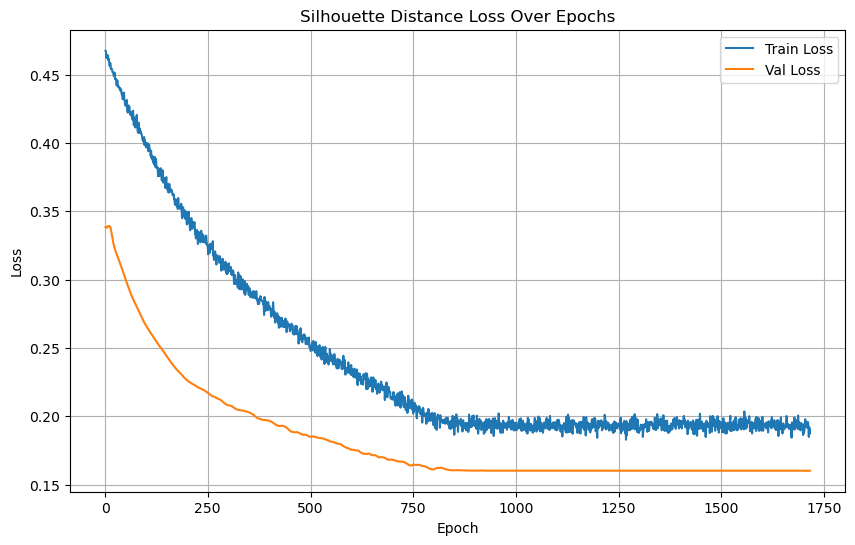

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/840], Loss: 0.0450
Test Batch [20/840], Loss: 0.1472
Test Batch [30/840], Loss: 0.1263
Test Batch [40/840], Loss: 0.5000
Test Batch [50/840], Loss: 0.1225
Test Batch [60/840], Loss: 0.0799
Test Batch [70/840], Loss: 0.0943


Test Batch [80/840], Loss: 0.5000
Test Batch [90/840], Loss: 0.1213
Test Batch [100/840], Loss: 0.1872
Test Batch [110/840], Loss: 0.5000
Test Batch [120/840], Loss: 0.1264
Test Batch [130/840], Loss: 0.1308
Test Batch [140/840], Loss: 0.1169
Test Batch [150/840], Loss: 0.1303


Test Batch [160/840], Loss: 0.2112
Test Batch [170/840], Loss: 0.0734
Test Batch [180/840], Loss: 0.0836
Test Batch [190/840], Loss: 0.0828
Test Batch [200/840], Loss: 0.0513


Test Batch [210/840], Loss: 0.0747
Test Batch [220/840], Loss: 0.0827
Test Batch [230/840], Loss: 0.0908
Test Batch [240/840], Loss: 0.0872
Test Batch [250/840], Loss: 0.0991


Test Batch [260/840], Loss: 0.2289
Test Batch [270/840], Loss: 0.2753
Test Batch [280/840], Loss: 0.2863
Test Batch [290/840], Loss: 0.1596


Test Batch [300/840], Loss: 0.2233
Test Batch [310/840], Loss: 0.2319
Test Batch [320/840], Loss: 0.1168
Test Batch [330/840], Loss: 0.1989
Test Batch [340/840], Loss: 0.1917
Test Batch [350/840], Loss: 0.5000
Test Batch [360/840], Loss: 0.5000


Test Batch [370/840], Loss: 0.5000
Test Batch [380/840], Loss: 0.5000
Test Batch [390/840], Loss: 0.5000
Test Batch [400/840], Loss: 0.5000
Test Batch [410/840], Loss: 0.5000
Test Batch [420/840], Loss: 0.5000
Test Batch [430/840], Loss: 0.0783
Test Batch [440/840], Loss: 0.1077
Test Batch [450/840], Loss: 0.1571


Test Batch [460/840], Loss: 0.0601
Test Batch [470/840], Loss: 0.0983
Test Batch [480/840], Loss: 0.1216
Test Batch [490/840], Loss: 0.5000
Test Batch [500/840], Loss: 0.0696
Test Batch [510/840], Loss: 0.0806
Test Batch [520/840], Loss: 0.0837


Test Batch [530/840], Loss: 0.1523
Test Batch [540/840], Loss: 0.1264
Test Batch [550/840], Loss: 0.1280
Test Batch [560/840], Loss: 0.1277
Test Batch [570/840], Loss: 0.1269
Test Batch [580/840], Loss: 0.1250


Test Batch [590/840], Loss: 0.1044
Test Batch [600/840], Loss: 0.5000
Test Batch [610/840], Loss: 0.1252
Test Batch [620/840], Loss: 0.0928
Test Batch [630/840], Loss: 0.1350


Test Batch [640/840], Loss: 0.0509
Test Batch [650/840], Loss: 0.1829
Test Batch [660/840], Loss: 0.3879
Test Batch [670/840], Loss: 0.0821
Test Batch [680/840], Loss: 0.0657


Test Batch [690/840], Loss: 0.2928
Test Batch [700/840], Loss: 0.2545
Test Batch [710/840], Loss: 0.0965
Test Batch [720/840], Loss: 0.1144
Test Batch [730/840], Loss: 0.0754


Test Batch [740/840], Loss: 0.1661
Test Batch [750/840], Loss: 0.0945
Test Batch [760/840], Loss: 0.5000
Test Batch [770/840], Loss: 0.1173
Test Batch [780/840], Loss: 0.5000


Test Batch [790/840], Loss: 0.2138
Test Batch [800/840], Loss: 0.0879
Test Batch [810/840], Loss: 0.5000
Test Batch [820/840], Loss: 0.1446
Test Batch [830/840], Loss: 0.5000
Test Batch [840/840], Loss: 0.1743

Test Loss: 0.1992


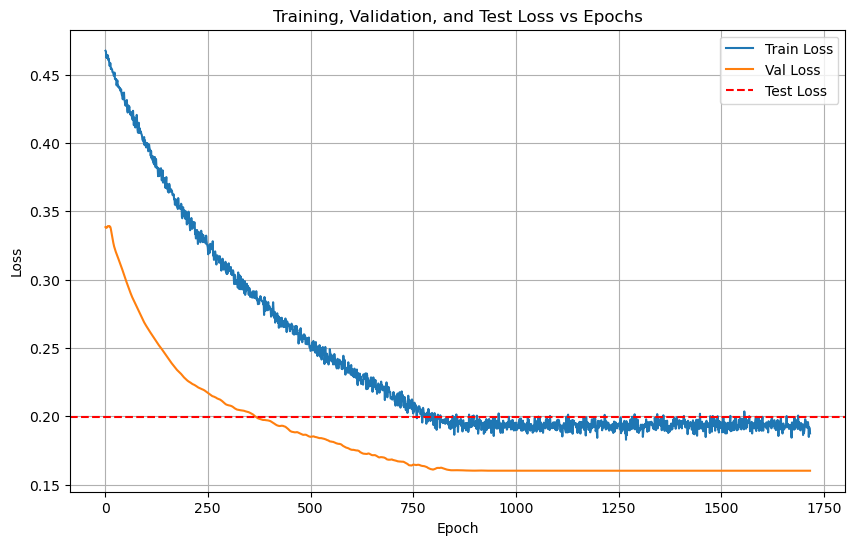

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/840 for test dataset.
  Processed batch 20/840 for test dataset.


  Processed batch 30/840 for test dataset.
  Processed batch 40/840 for test dataset.
  Processed batch 50/840 for test dataset.


  Processed batch 60/840 for test dataset.
  Processed batch 70/840 for test dataset.
  Processed batch 80/840 for test dataset.


  Processed batch 90/840 for test dataset.
  Processed batch 100/840 for test dataset.
  Processed batch 110/840 for test dataset.
  Processed batch 120/840 for test dataset.


  Processed batch 130/840 for test dataset.
  Processed batch 140/840 for test dataset.
  Processed batch 150/840 for test dataset.
  Processed batch 160/840 for test dataset.


  Processed batch 170/840 for test dataset.
  Processed batch 180/840 for test dataset.
  Processed batch 190/840 for test dataset.


  Processed batch 200/840 for test dataset.
  Processed batch 210/840 for test dataset.
  Processed batch 220/840 for test dataset.
  Processed batch 230/840 for test dataset.


  Processed batch 240/840 for test dataset.
  Processed batch 250/840 for test dataset.
  Processed batch 260/840 for test dataset.
  Processed batch 270/840 for test dataset.


  Processed batch 280/840 for test dataset.
  Processed batch 290/840 for test dataset.
  Processed batch 300/840 for test dataset.


  Processed batch 310/840 for test dataset.
  Processed batch 320/840 for test dataset.
  Processed batch 330/840 for test dataset.


  Processed batch 340/840 for test dataset.
  Processed batch 350/840 for test dataset.
  Processed batch 360/840 for test dataset.


  Processed batch 370/840 for test dataset.
  Processed batch 380/840 for test dataset.
  Processed batch 390/840 for test dataset.
  Processed batch 400/840 for test dataset.


  Processed batch 410/840 for test dataset.
  Processed batch 420/840 for test dataset.
  Processed batch 430/840 for test dataset.
  Processed batch 440/840 for test dataset.


  Processed batch 450/840 for test dataset.
  Processed batch 460/840 for test dataset.
  Processed batch 470/840 for test dataset.


  Processed batch 480/840 for test dataset.
  Processed batch 490/840 for test dataset.
  Processed batch 500/840 for test dataset.
  Processed batch 510/840 for test dataset.


  Processed batch 520/840 for test dataset.
  Processed batch 530/840 for test dataset.
  Processed batch 540/840 for test dataset.


  Processed batch 550/840 for test dataset.
  Processed batch 560/840 for test dataset.
  Processed batch 570/840 for test dataset.


  Processed batch 580/840 for test dataset.
  Processed batch 590/840 for test dataset.
  Processed batch 600/840 for test dataset.


  Processed batch 610/840 for test dataset.
  Processed batch 620/840 for test dataset.
  Processed batch 630/840 for test dataset.


  Processed batch 640/840 for test dataset.
  Processed batch 650/840 for test dataset.
  Processed batch 660/840 for test dataset.


  Processed batch 670/840 for test dataset.
  Processed batch 680/840 for test dataset.
  Processed batch 690/840 for test dataset.
  Processed batch 700/840 for test dataset.


  Processed batch 710/840 for test dataset.
  Processed batch 720/840 for test dataset.
  Processed batch 730/840 for test dataset.
  Processed batch 740/840 for test dataset.


  Processed batch 750/840 for test dataset.
  Processed batch 760/840 for test dataset.
  Processed batch 770/840 for test dataset.
  Processed batch 780/840 for test dataset.


  Processed batch 790/840 for test dataset.
  Processed batch 800/840 for test dataset.
  Processed batch 810/840 for test dataset.
  Processed batch 820/840 for test dataset.


  Processed batch 830/840 for test dataset.
  Processed batch 840/840 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.60      0.55         5
           8       1.00      1.00      1.00         5
           9       1.00      0.40      0.57         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8591  |  Val Loss: 2.8108
Validation loss improved from inf to 2.8108.
[Epoch 2/1000] Train Loss: 2.7879  |  Val Loss: 2.7480
Validation loss improved from 2.8108 to 2.7480.
[Epoch 3/1000] Train Loss: 2.7255  |  Val Loss: 2.6913
Validation loss improved from 2.7480 to 2.6913.
[Epoch 4/1000] Train Loss: 2.6671  |  Val Loss: 2.6411
Validation loss improved from 2.6913 to 2.6411.
[Epoch 5/1000] Train Loss: 2.6159  |  Val Loss: 2.5944
Validation loss improved from 2.6411 to 2.5944.
[Epoch 6/1000] Train Loss: 2.5683  |  Val Loss: 2.5508
Validation loss improved from 2.5944 to 2.5508.
[Epoch 7/1000] Train Loss: 2.5246  |  Val Loss: 2.5114
Validation loss improved from 2.5508 to 2.5114.
[Epoch 8/1000] Train Loss: 2.4843  |  Val Loss: 2.4744
Validation loss improved from 2.5114 to 2.4744.
[Epoch 9/1000] Train Loss: 2.4458  |  Val Loss: 2.4393
Validation loss improved from 2.4744 to 2.4393.
[Epoch 10/1000] Train Loss: 2.4100  |  Val Loss: 2.4061
Validation loss impr

[Epoch 15/1000] Train Loss: 2.2494  |  Val Loss: 2.2616
Validation loss improved from 2.2883 to 2.2616.
[Epoch 16/1000] Train Loss: 2.2213  |  Val Loss: 2.2359
Validation loss improved from 2.2616 to 2.2359.
[Epoch 17/1000] Train Loss: 2.1928  |  Val Loss: 2.2111
Validation loss improved from 2.2359 to 2.2111.
[Epoch 18/1000] Train Loss: 2.1664  |  Val Loss: 2.1865
Validation loss improved from 2.2111 to 2.1865.
[Epoch 19/1000] Train Loss: 2.1396  |  Val Loss: 2.1620
Validation loss improved from 2.1865 to 2.1620.
[Epoch 20/1000] Train Loss: 2.1128  |  Val Loss: 2.1382
Validation loss improved from 2.1620 to 2.1382.


[Epoch 21/1000] Train Loss: 2.0869  |  Val Loss: 2.1146
Validation loss improved from 2.1382 to 2.1146.
[Epoch 22/1000] Train Loss: 2.0612  |  Val Loss: 2.0908
Validation loss improved from 2.1146 to 2.0908.
[Epoch 23/1000] Train Loss: 2.0357  |  Val Loss: 2.0672
Validation loss improved from 2.0908 to 2.0672.
[Epoch 24/1000] Train Loss: 2.0105  |  Val Loss: 2.0433
Validation loss improved from 2.0672 to 2.0433.
[Epoch 25/1000] Train Loss: 1.9844  |  Val Loss: 2.0195
Validation loss improved from 2.0433 to 2.0195.
[Epoch 26/1000] Train Loss: 1.9588  |  Val Loss: 1.9960
Validation loss improved from 2.0195 to 1.9960.
[Epoch 27/1000] Train Loss: 1.9324  |  Val Loss: 1.9724
Validation loss improved from 1.9960 to 1.9724.
[Epoch 28/1000] Train Loss: 1.9067  |  Val Loss: 1.9485
Validation loss improved from 1.9724 to 1.9485.
[Epoch 29/1000] Train Loss: 1.8803  |  Val Loss: 1.9243
Validation loss improved from 1.9485 to 1.9243.
[Epoch 30/1000] Train Loss: 1.8534  |  Val Loss: 1.8999
Validati

[Epoch 34/1000] Train Loss: 1.7464  |  Val Loss: 1.8020
Validation loss improved from 1.8263 to 1.8020.
[Epoch 35/1000] Train Loss: 1.7205  |  Val Loss: 1.7774
Validation loss improved from 1.8020 to 1.7774.
[Epoch 36/1000] Train Loss: 1.6935  |  Val Loss: 1.7528
Validation loss improved from 1.7774 to 1.7528.
[Epoch 37/1000] Train Loss: 1.6657  |  Val Loss: 1.7284
Validation loss improved from 1.7528 to 1.7284.


[Epoch 38/1000] Train Loss: 1.6387  |  Val Loss: 1.7039
Validation loss improved from 1.7284 to 1.7039.
[Epoch 39/1000] Train Loss: 1.6118  |  Val Loss: 1.6790
Validation loss improved from 1.7039 to 1.6790.
[Epoch 40/1000] Train Loss: 1.5843  |  Val Loss: 1.6538
Validation loss improved from 1.6790 to 1.6538.
[Epoch 41/1000] Train Loss: 1.5567  |  Val Loss: 1.6286
Validation loss improved from 1.6538 to 1.6286.
[Epoch 42/1000] Train Loss: 1.5291  |  Val Loss: 1.6034
Validation loss improved from 1.6286 to 1.6034.
[Epoch 43/1000] Train Loss: 1.5020  |  Val Loss: 1.5779
Validation loss improved from 1.6034 to 1.5779.
[Epoch 44/1000] Train Loss: 1.4739  |  Val Loss: 1.5528
Validation loss improved from 1.5779 to 1.5528.
[Epoch 45/1000] Train Loss: 1.4465  |  Val Loss: 1.5273
Validation loss improved from 1.5528 to 1.5273.
[Epoch 46/1000] Train Loss: 1.4189  |  Val Loss: 1.5011
Validation loss improved from 1.5273 to 1.5011.
[Epoch 47/1000] Train Loss: 1.3901  |  Val Loss: 1.4755
Validati

[Epoch 52/1000] Train Loss: 1.2496  |  Val Loss: 1.3480
Validation loss improved from 1.3733 to 1.3480.
[Epoch 53/1000] Train Loss: 1.2219  |  Val Loss: 1.3224
Validation loss improved from 1.3480 to 1.3224.
[Epoch 54/1000] Train Loss: 1.1935  |  Val Loss: 1.2971
Validation loss improved from 1.3224 to 1.2971.
[Epoch 55/1000] Train Loss: 1.1661  |  Val Loss: 1.2718
Validation loss improved from 1.2971 to 1.2718.
[Epoch 56/1000] Train Loss: 1.1387  |  Val Loss: 1.2469
Validation loss improved from 1.2718 to 1.2469.


[Epoch 57/1000] Train Loss: 1.1113  |  Val Loss: 1.2223
Validation loss improved from 1.2469 to 1.2223.
[Epoch 58/1000] Train Loss: 1.0847  |  Val Loss: 1.1990
Validation loss improved from 1.2223 to 1.1990.
[Epoch 59/1000] Train Loss: 1.0585  |  Val Loss: 1.1758
Validation loss improved from 1.1990 to 1.1758.
[Epoch 60/1000] Train Loss: 1.0333  |  Val Loss: 1.1526
Validation loss improved from 1.1758 to 1.1526.
[Epoch 61/1000] Train Loss: 1.0083  |  Val Loss: 1.1299
Validation loss improved from 1.1526 to 1.1299.
[Epoch 62/1000] Train Loss: 0.9832  |  Val Loss: 1.1076
Validation loss improved from 1.1299 to 1.1076.
[Epoch 63/1000] Train Loss: 0.9592  |  Val Loss: 1.0858
Validation loss improved from 1.1076 to 1.0858.
[Epoch 64/1000] Train Loss: 0.9352  |  Val Loss: 1.0643
Validation loss improved from 1.0858 to 1.0643.
[Epoch 65/1000] Train Loss: 0.9121  |  Val Loss: 1.0434
Validation loss improved from 1.0643 to 1.0434.
[Epoch 66/1000] Train Loss: 0.8890  |  Val Loss: 1.0228
Validati

[Epoch 72/1000] Train Loss: 0.7611  |  Val Loss: 0.9074
Validation loss improved from 0.9255 to 0.9074.
[Epoch 73/1000] Train Loss: 0.7416  |  Val Loss: 0.8897
Validation loss improved from 0.9074 to 0.8897.
[Epoch 74/1000] Train Loss: 0.7221  |  Val Loss: 0.8723
Validation loss improved from 0.8897 to 0.8723.
[Epoch 75/1000] Train Loss: 0.7028  |  Val Loss: 0.8552
Validation loss improved from 0.8723 to 0.8552.
[Epoch 76/1000] Train Loss: 0.6839  |  Val Loss: 0.8384
Validation loss improved from 0.8552 to 0.8384.


[Epoch 77/1000] Train Loss: 0.6658  |  Val Loss: 0.8221
Validation loss improved from 0.8384 to 0.8221.
[Epoch 78/1000] Train Loss: 0.6480  |  Val Loss: 0.8060
Validation loss improved from 0.8221 to 0.8060.
[Epoch 79/1000] Train Loss: 0.6304  |  Val Loss: 0.7902
Validation loss improved from 0.8060 to 0.7902.
[Epoch 80/1000] Train Loss: 0.6128  |  Val Loss: 0.7748
Validation loss improved from 0.7902 to 0.7748.
[Epoch 81/1000] Train Loss: 0.5961  |  Val Loss: 0.7599
Validation loss improved from 0.7748 to 0.7599.
[Epoch 82/1000] Train Loss: 0.5801  |  Val Loss: 0.7453
Validation loss improved from 0.7599 to 0.7453.
[Epoch 83/1000] Train Loss: 0.5638  |  Val Loss: 0.7309
Validation loss improved from 0.7453 to 0.7309.
[Epoch 84/1000] Train Loss: 0.5481  |  Val Loss: 0.7170
Validation loss improved from 0.7309 to 0.7170.
[Epoch 85/1000] Train Loss: 0.5326  |  Val Loss: 0.7035
Validation loss improved from 0.7170 to 0.7035.
[Epoch 86/1000] Train Loss: 0.5178  |  Val Loss: 0.6904
Validati

[Epoch 91/1000] Train Loss: 0.4478  |  Val Loss: 0.6271
Validation loss improved from 0.6392 to 0.6271.
[Epoch 92/1000] Train Loss: 0.4350  |  Val Loss: 0.6155
Validation loss improved from 0.6271 to 0.6155.
[Epoch 93/1000] Train Loss: 0.4220  |  Val Loss: 0.6043
Validation loss improved from 0.6155 to 0.6043.


[Epoch 94/1000] Train Loss: 0.4096  |  Val Loss: 0.5935
Validation loss improved from 0.6043 to 0.5935.
[Epoch 95/1000] Train Loss: 0.3978  |  Val Loss: 0.5826
Validation loss improved from 0.5935 to 0.5826.
[Epoch 96/1000] Train Loss: 0.3864  |  Val Loss: 0.5722
Validation loss improved from 0.5826 to 0.5722.
[Epoch 97/1000] Train Loss: 0.3751  |  Val Loss: 0.5621
Validation loss improved from 0.5722 to 0.5621.
[Epoch 98/1000] Train Loss: 0.3647  |  Val Loss: 0.5521
Validation loss improved from 0.5621 to 0.5521.
[Epoch 99/1000] Train Loss: 0.3538  |  Val Loss: 0.5429
Validation loss improved from 0.5521 to 0.5429.
[Epoch 100/1000] Train Loss: 0.3441  |  Val Loss: 0.5337
Validation loss improved from 0.5429 to 0.5337.
[Epoch 101/1000] Train Loss: 0.3341  |  Val Loss: 0.5250
Validation loss improved from 0.5337 to 0.5250.
[Epoch 102/1000] Train Loss: 0.3248  |  Val Loss: 0.5164
Validation loss improved from 0.5250 to 0.5164.
[Epoch 103/1000] Train Loss: 0.3160  |  Val Loss: 0.5085
Vali

[Epoch 109/1000] Train Loss: 0.2681  |  Val Loss: 0.4636
Validation loss improved from 0.4702 to 0.4636.


[Epoch 110/1000] Train Loss: 0.2610  |  Val Loss: 0.4572
Validation loss improved from 0.4636 to 0.4572.
[Epoch 111/1000] Train Loss: 0.2545  |  Val Loss: 0.4512
Validation loss improved from 0.4572 to 0.4512.
[Epoch 112/1000] Train Loss: 0.2477  |  Val Loss: 0.4451
Validation loss improved from 0.4512 to 0.4451.
[Epoch 113/1000] Train Loss: 0.2416  |  Val Loss: 0.4394
Validation loss improved from 0.4451 to 0.4394.
[Epoch 114/1000] Train Loss: 0.2355  |  Val Loss: 0.4335
Validation loss improved from 0.4394 to 0.4335.
[Epoch 115/1000] Train Loss: 0.2296  |  Val Loss: 0.4279
Validation loss improved from 0.4335 to 0.4279.
[Epoch 116/1000] Train Loss: 0.2239  |  Val Loss: 0.4225
Validation loss improved from 0.4279 to 0.4225.
[Epoch 117/1000] Train Loss: 0.2183  |  Val Loss: 0.4173
Validation loss improved from 0.4225 to 0.4173.
[Epoch 118/1000] Train Loss: 0.2130  |  Val Loss: 0.4127
Validation loss improved from 0.4173 to 0.4127.
[Epoch 119/1000] Train Loss: 0.2081  |  Val Loss: 0.408

[Epoch 126/1000] Train Loss: 0.1774  |  Val Loss: 0.3812
Validation loss improved from 0.3843 to 0.3812.
[Epoch 127/1000] Train Loss: 0.1736  |  Val Loss: 0.3779
Validation loss improved from 0.3812 to 0.3779.
[Epoch 128/1000] Train Loss: 0.1701  |  Val Loss: 0.3747
Validation loss improved from 0.3779 to 0.3747.
[Epoch 129/1000] Train Loss: 0.1665  |  Val Loss: 0.3714
Validation loss improved from 0.3747 to 0.3714.
[Epoch 130/1000] Train Loss: 0.1631  |  Val Loss: 0.3684
Validation loss improved from 0.3714 to 0.3684.
[Epoch 131/1000] Train Loss: 0.1598  |  Val Loss: 0.3654
Validation loss improved from 0.3684 to 0.3654.
[Epoch 132/1000] Train Loss: 0.1567  |  Val Loss: 0.3624
Validation loss improved from 0.3654 to 0.3624.
[Epoch 133/1000] Train Loss: 0.1537  |  Val Loss: 0.3598
Validation loss improved from 0.3624 to 0.3598.
[Epoch 134/1000] Train Loss: 0.1507  |  Val Loss: 0.3571
Validation loss improved from 0.3598 to 0.3571.
[Epoch 135/1000] Train Loss: 0.1479  |  Val Loss: 0.354

[Epoch 147/1000] Train Loss: 0.1198  |  Val Loss: 0.3314
Validation loss improved from 0.3331 to 0.3314.
[Epoch 148/1000] Train Loss: 0.1179  |  Val Loss: 0.3299
Validation loss improved from 0.3314 to 0.3299.
[Epoch 149/1000] Train Loss: 0.1160  |  Val Loss: 0.3285
Validation loss improved from 0.3299 to 0.3285.
[Epoch 150/1000] Train Loss: 0.1142  |  Val Loss: 0.3271
Validation loss improved from 0.3285 to 0.3271.
[Epoch 151/1000] Train Loss: 0.1125  |  Val Loss: 0.3256
Validation loss improved from 0.3271 to 0.3256.
[Epoch 152/1000] Train Loss: 0.1108  |  Val Loss: 0.3244
Validation loss improved from 0.3256 to 0.3244.
[Epoch 153/1000] Train Loss: 0.1092  |  Val Loss: 0.3232
Validation loss improved from 0.3244 to 0.3232.
[Epoch 154/1000] Train Loss: 0.1076  |  Val Loss: 0.3221
Validation loss improved from 0.3232 to 0.3221.
[Epoch 155/1000] Train Loss: 0.1061  |  Val Loss: 0.3211
Validation loss improved from 0.3221 to 0.3211.
[Epoch 156/1000] Train Loss: 0.1046  |  Val Loss: 0.320

[Epoch 164/1000] Train Loss: 0.0937  |  Val Loss: 0.3129
Validation loss improved from 0.3136 to 0.3129.
[Epoch 165/1000] Train Loss: 0.0926  |  Val Loss: 0.3122
Validation loss improved from 0.3129 to 0.3122.
[Epoch 166/1000] Train Loss: 0.0913  |  Val Loss: 0.3116
Validation loss improved from 0.3122 to 0.3116.
[Epoch 167/1000] Train Loss: 0.0903  |  Val Loss: 0.3110
Validation loss improved from 0.3116 to 0.3110.
[Epoch 168/1000] Train Loss: 0.0892  |  Val Loss: 0.3103
Validation loss improved from 0.3110 to 0.3103.
[Epoch 169/1000] Train Loss: 0.0881  |  Val Loss: 0.3096
Validation loss improved from 0.3103 to 0.3096.
[Epoch 170/1000] Train Loss: 0.0870  |  Val Loss: 0.3090
Validation loss improved from 0.3096 to 0.3090.
[Epoch 171/1000] Train Loss: 0.0860  |  Val Loss: 0.3083
Validation loss improved from 0.3090 to 0.3083.
[Epoch 172/1000] Train Loss: 0.0850  |  Val Loss: 0.3078
Validation loss improved from 0.3083 to 0.3078.
[Epoch 173/1000] Train Loss: 0.0841  |  Val Loss: 0.307

[Epoch 183/1000] Train Loss: 0.0753  |  Val Loss: 0.3033
Validation loss improved from 0.3035 to 0.3033.
[Epoch 184/1000] Train Loss: 0.0745  |  Val Loss: 0.3030
Validation loss improved from 0.3033 to 0.3030.
[Epoch 185/1000] Train Loss: 0.0738  |  Val Loss: 0.3029
Validation loss improved from 0.3030 to 0.3029.
[Epoch 186/1000] Train Loss: 0.0730  |  Val Loss: 0.3026
Validation loss improved from 0.3029 to 0.3026.
[Epoch 187/1000] Train Loss: 0.0723  |  Val Loss: 0.3021
Validation loss improved from 0.3026 to 0.3021.
[Epoch 188/1000] Train Loss: 0.0716  |  Val Loss: 0.3019
Validation loss improved from 0.3021 to 0.3019.
[Epoch 189/1000] Train Loss: 0.0709  |  Val Loss: 0.3016
Validation loss improved from 0.3019 to 0.3016.
[Epoch 190/1000] Train Loss: 0.0703  |  Val Loss: 0.3015
Validation loss improved from 0.3016 to 0.3015.
[Epoch 191/1000] Train Loss: 0.0696  |  Val Loss: 0.3016
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 192/1000] Train Loss: 0.0689  |  Val Loss:

[Epoch 201/1000] Train Loss: 0.0635  |  Val Loss: 0.3006
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 0.0630  |  Val Loss: 0.3009
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 0.0624  |  Val Loss: 0.3011
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/1000] Train Loss: 0.0619  |  Val Loss: 0.3009
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 205/1000] Train Loss: 0.0614  |  Val Loss: 0.3007
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 206/1000] Train Loss: 0.0609  |  Val Loss: 0.3007
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 207/1000] Train Loss: 0.0603  |  Val Loss: 0.3005
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 208/1000] Train Loss: 0.0598  |  Val Loss: 0.3004
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 209/1000] Train Loss: 0.0593  |  Val Loss: 0.3004
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 219/1000] Train Loss: 0.0549  |  Val Loss: 0.3019
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 220/1000] Train Loss: 0.0544  |  Val Loss: 0.3018
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 221/1000] Train Loss: 0.0541  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 222/1000] Train Loss: 0.0536  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 223/1000] Train Loss: 0.0533  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 224/1000] Train Loss: 0.0529  |  Val Loss: 0.3030
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 225/1000] Train Loss: 0.0525  |  Val Loss: 0.3030
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 226/1000] Train Loss: 0.0521  |  Val Loss: 0.3032
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 227/1000] Train Loss: 0.0518  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience:

[Epoch 238/1000] Train Loss: 0.0479  |  Val Loss: 0.3058
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 239/1000] Train Loss: 0.0476  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 240/1000] Train Loss: 0.0475  |  Val Loss: 0.3062
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 241/1000] Train Loss: 0.0470  |  Val Loss: 0.3066
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 242/1000] Train Loss: 0.0467  |  Val Loss: 0.3067
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 243/1000] Train Loss: 0.0464  |  Val Loss: 0.3068
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 244/1000] Train Loss: 0.0462  |  Val Loss: 0.3070
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 245/1000] Train Loss: 0.0458  |  Val Loss: 0.3074
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 246/1000] Train Loss: 0.0456  |  Val Loss: 0.3081
!! Validation loss did NOT improve !! Patience:

[Epoch 258/1000] Train Loss: 0.0424  |  Val Loss: 0.3111
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 259/1000] Train Loss: 0.0420  |  Val Loss: 0.3115
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 260/1000] Train Loss: 0.0418  |  Val Loss: 0.3119
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 261/1000] Train Loss: 0.0416  |  Val Loss: 0.3122
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 262/1000] Train Loss: 0.0413  |  Val Loss: 0.3127
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 263/1000] Train Loss: 0.0412  |  Val Loss: 0.3131
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 264/1000] Train Loss: 0.0409  |  Val Loss: 0.3133
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 265/1000] Train Loss: 0.0406  |  Val Loss: 0.3136
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 266/1000] Train Loss: 0.0404  |  Val Loss: 0.3140
!! Validation loss did NOT improve !! Patience:

[Epoch 275/1000] Train Loss: 0.0384  |  Val Loss: 0.3175
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 276/1000] Train Loss: 0.0382  |  Val Loss: 0.3181
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 277/1000] Train Loss: 0.0382  |  Val Loss: 0.3181
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 278/1000] Train Loss: 0.0379  |  Val Loss: 0.3186
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 279/1000] Train Loss: 0.0376  |  Val Loss: 0.3187
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 280/1000] Train Loss: 0.0374  |  Val Loss: 0.3187
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 281/1000] Train Loss: 0.0372  |  Val Loss: 0.3195
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 282/1000] Train Loss: 0.0370  |  Val Loss: 0.3199
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 283/1000] Train Loss: 0.0369  |  Val Loss: 0.3205
!! Validation loss did NOT improve !! Patience:

[Epoch 293/1000] Train Loss: 0.0351  |  Val Loss: 0.3239
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 294/1000] Train Loss: 0.0348  |  Val Loss: 0.3243
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 295/1000] Train Loss: 0.0347  |  Val Loss: 0.3250
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 296/1000] Train Loss: 0.0345  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 297/1000] Train Loss: 0.0343  |  Val Loss: 0.3262
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 298/1000] Train Loss: 0.0342  |  Val Loss: 0.3262
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 299/1000] Train Loss: 0.0340  |  Val Loss: 0.3273
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 299 !!
No improvement for 100 epochs.


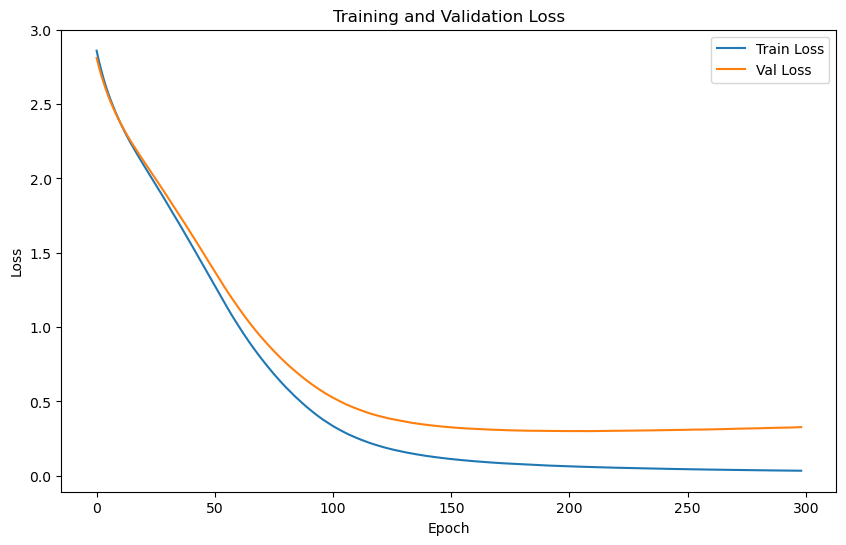

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7508 | Test Accuracy: 84.25%


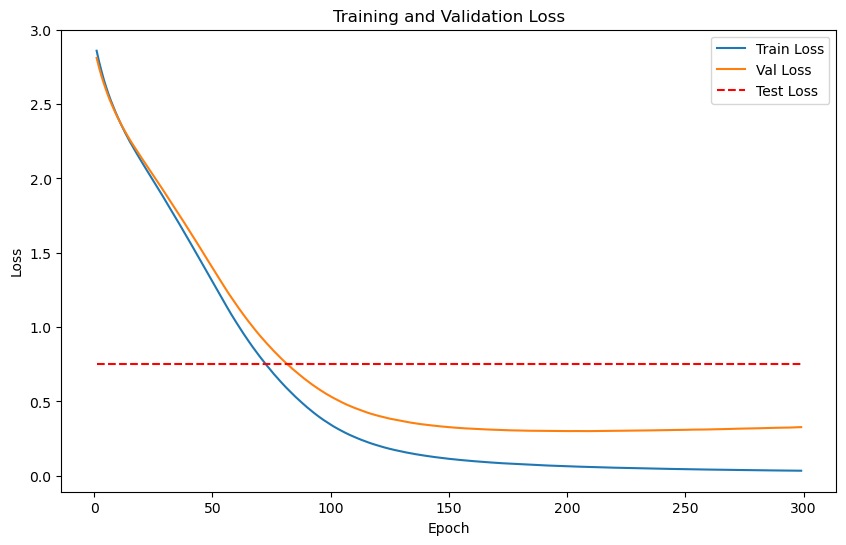

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


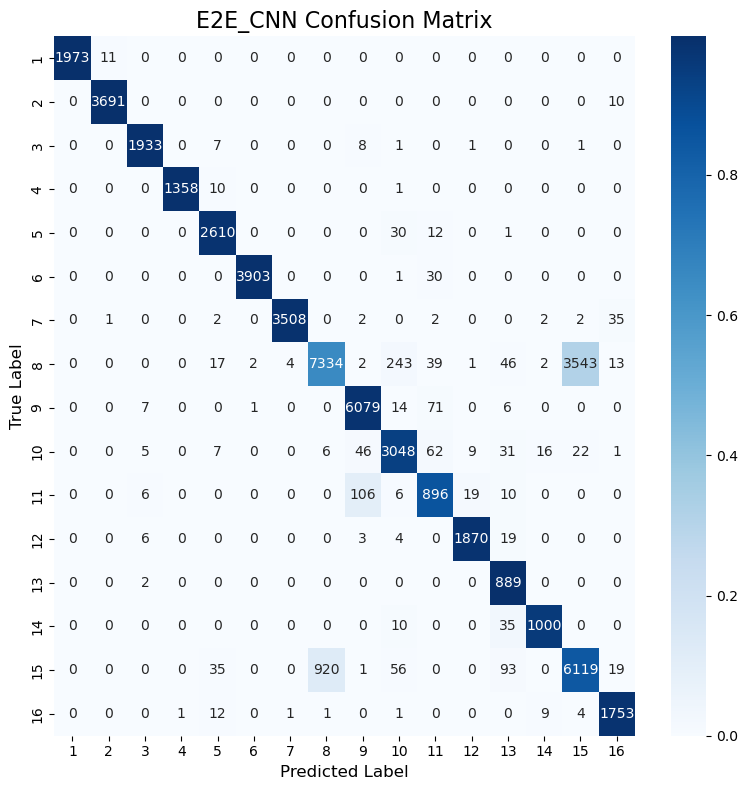

Classification Accuracy: 89.27%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


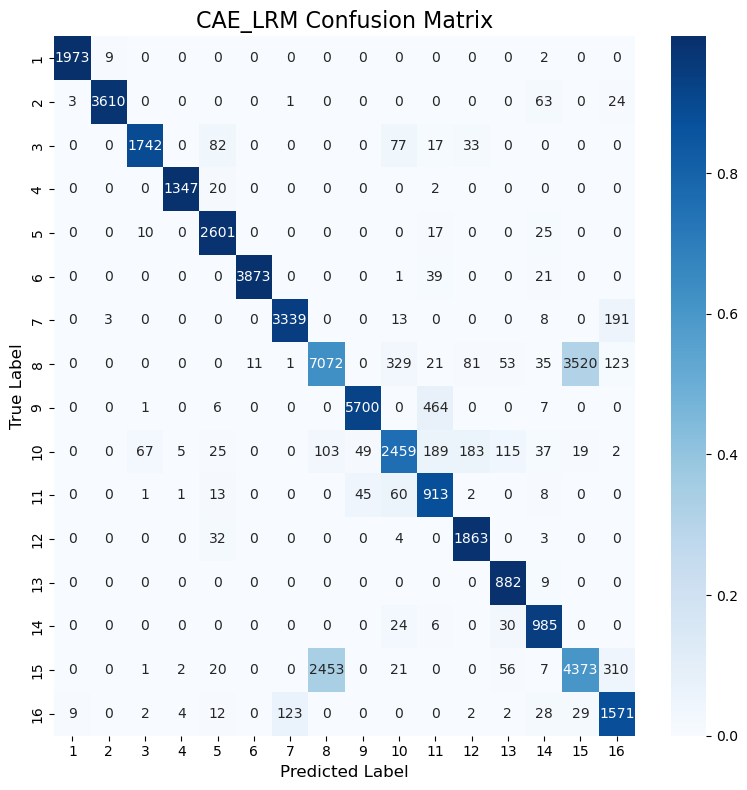

Classification Accuracy: 82.46%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


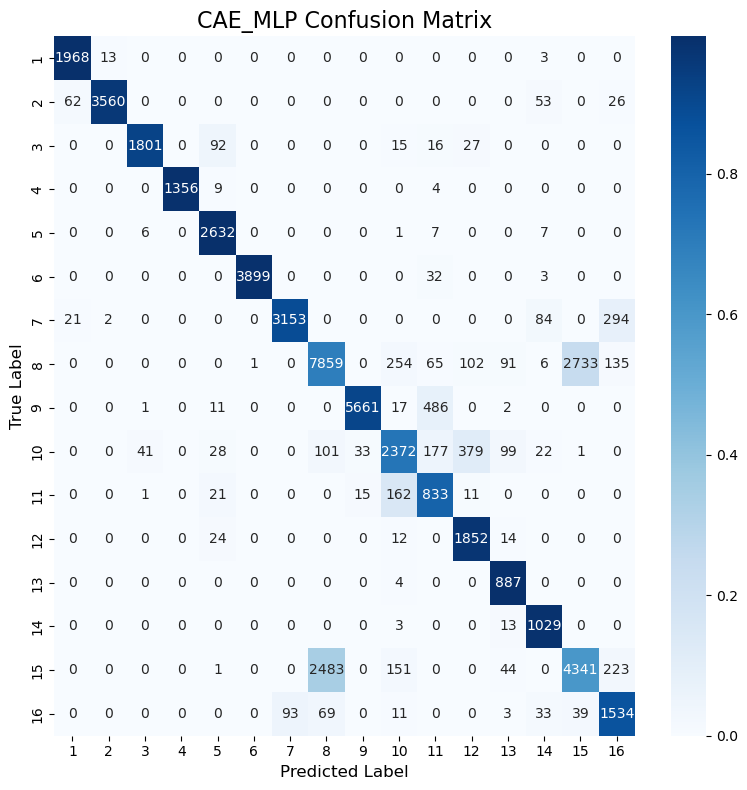

Classification Accuracy: 83.26%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


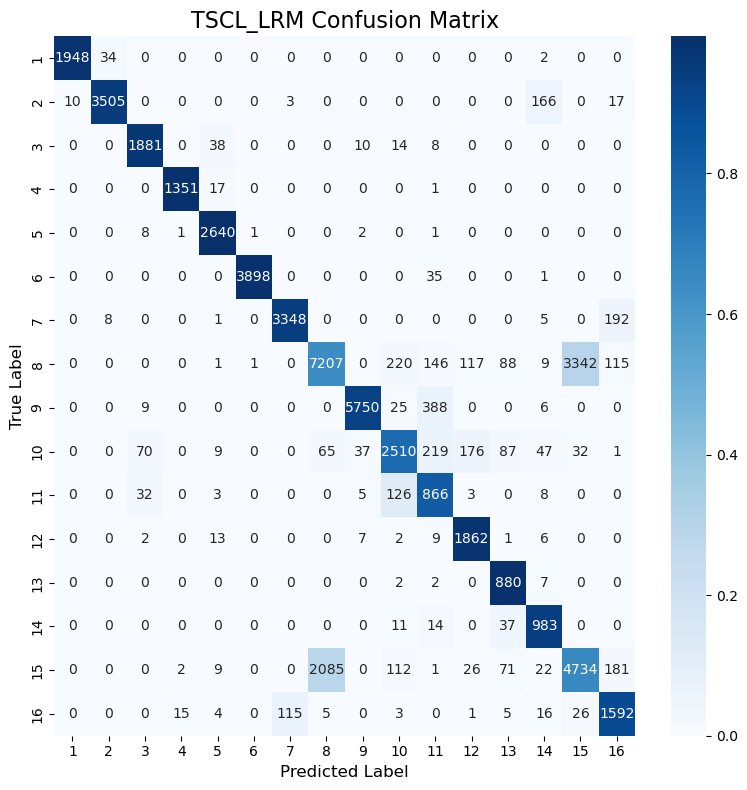

Classification Accuracy: 83.67%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


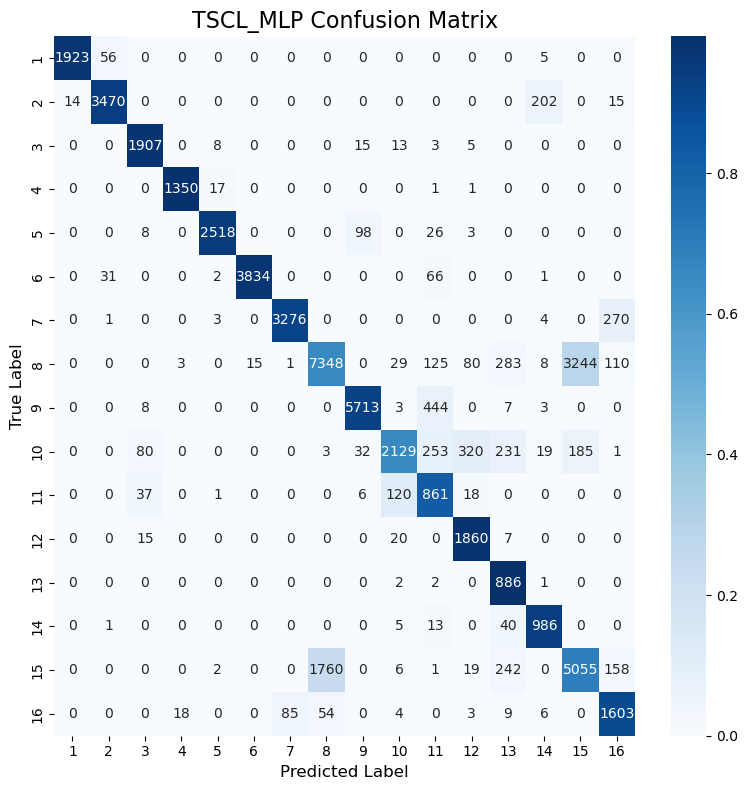

Classification Accuracy: 83.23%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


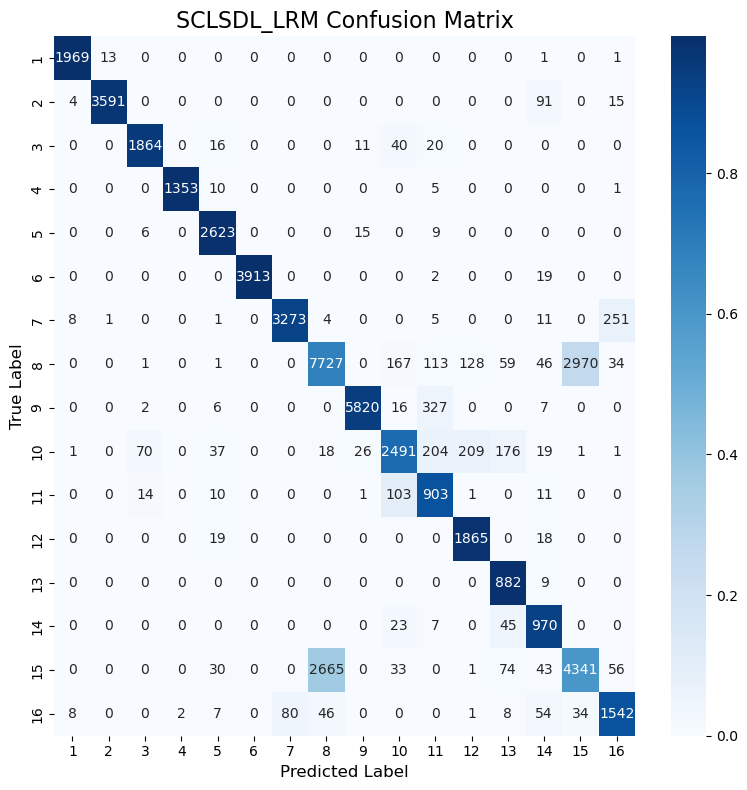

Classification Accuracy: 83.99%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


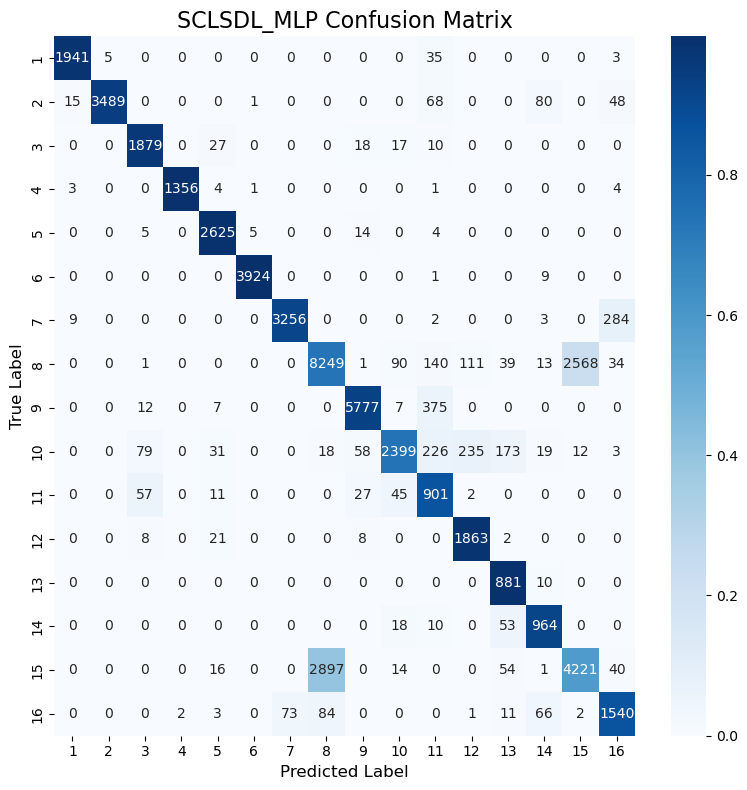

Classification Accuracy: 84.25%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          89.27
1    LRM (CAE)          82.46
2    MLP (CAE)          83.26
3     TSCL LRM          83.67
4     TSCL MLP          83.23
5  SCL_SDL LRM          83.99
6  SCL_SDL MLP          84.25

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          89.27
6  SCL_SDL MLP          84.25
5  SCL_SDL LRM          83.99
3     TSCL LRM          83.67
2    MLP (CAE)          83.26
4     TSCL MLP          83.23
1    LRM (CAE)          82.46
